# DATASTORY AND VISUALISATION ARE AVAILABLES HERE :

### https://rbsteinm.github.io/AppliedDataAnalysis/



In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv
import copy
import sklearn.linear_model
import json
import re
from sklearn import preprocessing
from scipy import stats 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
COLOR_TREAT = '#B0CDDD'
COLOR_NO_TREAT = "#e74c3c"
import warnings
warnings.filterwarnings('ignore')

In [2]:
def percent_categorical(item, df=None, grouper='Active Status' , order = None , title = None , label = None , legend = None) :
    # this allows us to plot the distribution for categorical datas nicely
    # plot categorical responses to an item ('column name')
    # by percent by group ('diff column name w categorical data')
    # select a data frame (default is IA)
    # 'Active Status' is default grouper

    # create df of item grouped by status
    grouped = (df.groupby(grouper)[item]
    # convert to percentage by group rather than total count
                .value_counts(normalize=True)
                # rename column 
                .rename('percentage')
                # multiple by 100 for easier interpretation
                .mul(100)
                # change order from value to name
                .reset_index()
                .sort_values(item))

    # create plot
    
    f, axarr = plt.subplots(1, 2, figsize = (15,8))
    
    sns.barplot(x=item,
                         y='percentage',
                         hue=grouper,
                         data=grouped,
                         palette='RdBu' , order = order , ax = axarr[0]
                         )
    
    
    
    sns.countplot( x = item , data= df , hue = grouper , palette='RdBu' , order = order , ax = axarr[1])
    
    
    
    
    if title == None:
        title = ['' , '']
    
    axarr[0].set_title(title[0] , size =15)
    axarr[1].set_title(title[1] , size =15)
    if label == None :
        label = item
    axarr[0].set_xlabel(label , size = 15)
    axarr[1].set_xlabel(label , size =15)
    
    axarr[0].tick_params(axis='both', which='major', labelsize=15)
    axarr[1].tick_params(axis='both', which='major', labelsize=15)
    
    axarr[0].set_xticklabels(order , rotation=45 )
    axarr[1].set_xticklabels(order , rotation=45 )
    
    axarr[0].set_ylabel('Percent' , size = 15)
    axarr[1].set_ylabel('Counts',  size =15 )
    
    if legend != None:
        
        for ax in axarr :
            leg_handles = ax.get_legend_handles_labels()[0]
            ax.legend(leg_handles, [legend[1], legend[2]], title=legend[0])
            plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
            plt.setp(ax.get_legend().get_title(), fontsize='15')
    
    return axarr

# Data exploration of conflicts and agreements
## Naïve analysis of the peace agreement dataset :

The Peace agreements dataset contains a large set of variable (69) defining the type of the agreement signed. We list below a few explanations of the features.

** PAID : ** Peace Agreement ID

**Region : **
The regional variable specifies the regional location of the conflict:
1. Europe: Geographic definition, including the states in the Caucasus. (COW numbers 200–395) 
2. Middle East: Egypt, Iran, Iraq, Israel, Jordan, Kuwait, Lebanon, Syria, Turkey, and the states of the Arabian Peninsula (COW numbers 630–698)
3. Asia: Geographic definition, including Oceania, Australia, and New Zealand, and excluding states in the Middle East. (COW numbers 700–990)
4. Africa: Geographic definition, excluding states in the Middle East (eg. Egypt). (COW numbers 400– 625)
5. Americas: Geographic definition, including states in the Caribbean. (COW numbers 2–165)

**GWNO : ** Gleditsch & Ward System Membership Table, it represents the country code

**CID : ** - Conflict ID

** Ended : ** 1 represents a PA that was terminated, 0 its success.

This dataset contains also some binary features to define the type of the agreement. There are binary features for :
- Behavioral conduct of the warring parties
- Regulation of governmental incompatibility
- Regulation of territorial incompatibility
- Justice issues
- Implementation issues
- Termination Variables : which corresponds to the evaluation of the agreement
- Type of process : is a full or partial peace agreement process

In [3]:
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)
regiondic = {
    1:'Europe',
    2:'Middle East',
    3:'Asia',
    4:'Africa',
    5:'Americas'
}
paType = {1:'Full Peace',2:'Partial Peace',3:'Peace Process'}
incompatibility = {1:'Territorial', 2:'Governmental',3:'Territorial & Governmental'}

pa['pa_type'].replace(paType, inplace=True)
pa['Region'].replace(regiondic, inplace=True)
pa['Inc'].replace(incompatibility, inplace=True)
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = ['UN intervention' if ele in inter else 'No UN intervention' for ele in pa.PAID]

## Distribution of the agreements by region

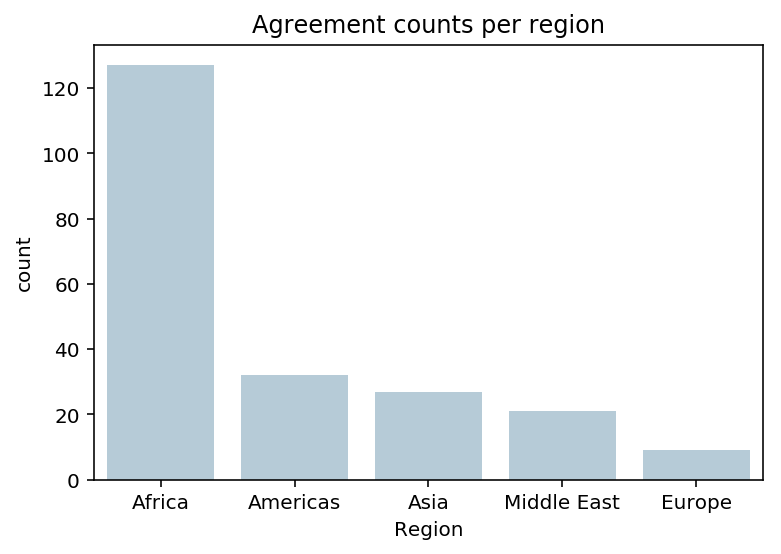

In [4]:
sns.countplot(x='Region', data=pa, color=COLOR_TREAT, order=pa.Region.value_counts().index)
plt.title('Agreement counts per region')
plt.xlabel('Region');

This plot shows the number of peace agreements per region. We can see that most agreements concern African conflicts. It should be noted that this plot sums the number of Peace agreements per region. There are more peace agreements signed in the african region but the percentage of conflicts that are treated by Peace agreements differs a lot.

## Distribution of agreements by year

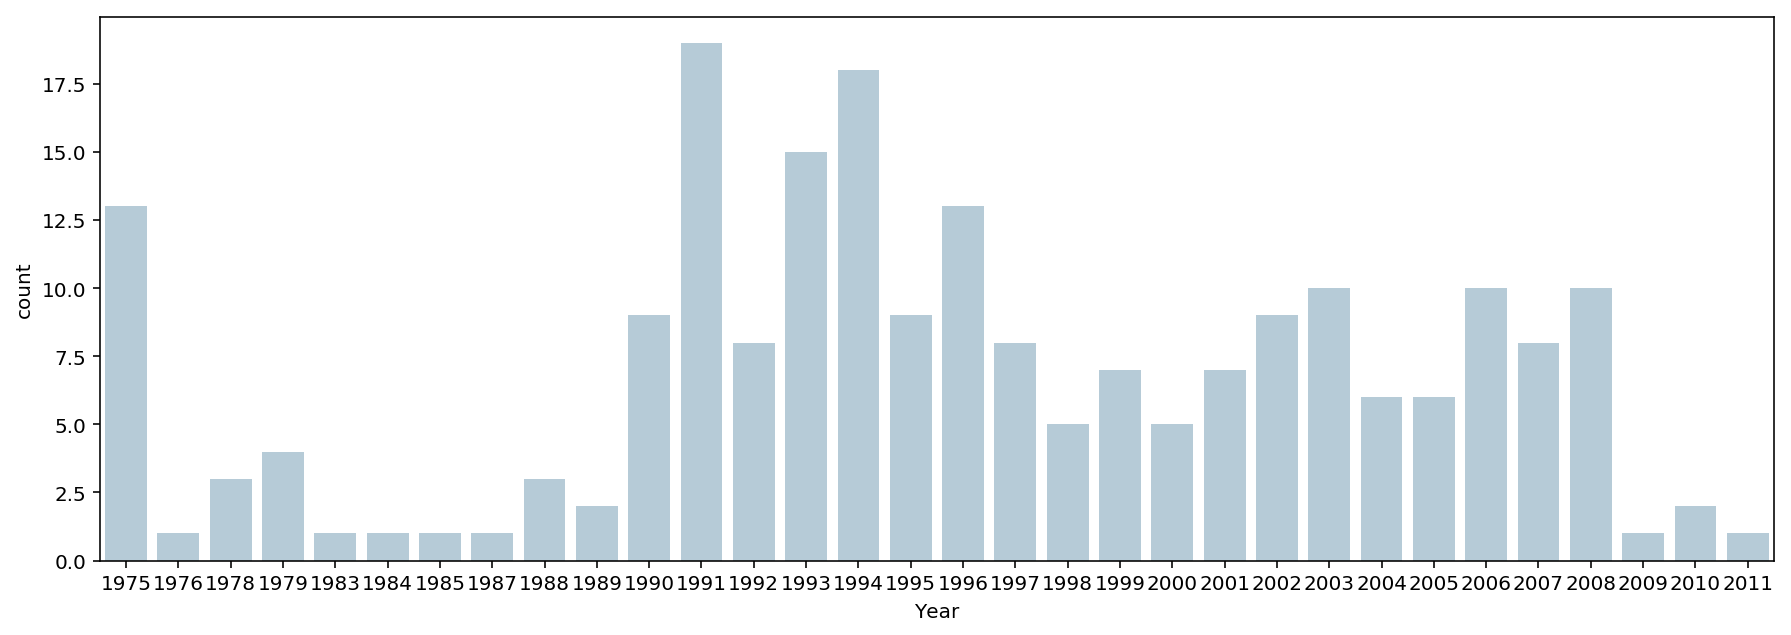

In [5]:
plt.figure(figsize=(15,5))
sns.countplot(x='Year', data=pa, color=COLOR_TREAT)

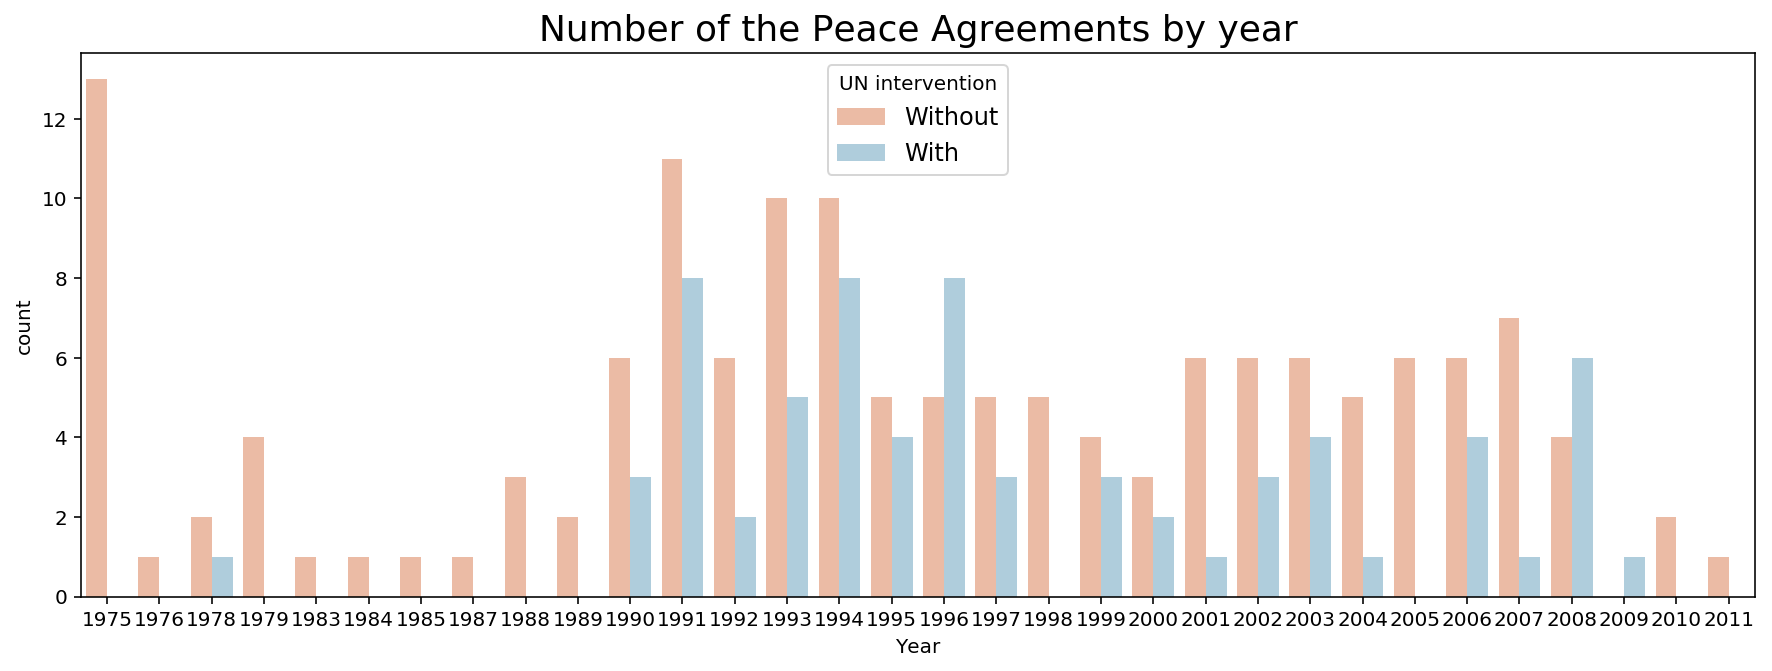

In [6]:
plt.figure(figsize=(15,5));
sns.countplot(x='Year', data=pa, hue='UN', palette='RdBu');
plt.title('Number of the Peace Agreements by year', Fontsize=18)
plt.legend( ['Without' , 'With'] ,fontsize = 'large' , title = 'UN intervention')

## Year distibution of Peace agreements
1991 is the year where most peace agreements were signed. There has been two periods with a low amount of peace agreement, from 1983 to 1987 and from 2009 to 2011. Until 1990, The UN were not taking part to Peace agreements except for the Peace Process agreement between Namibia and South Africa in 1978.

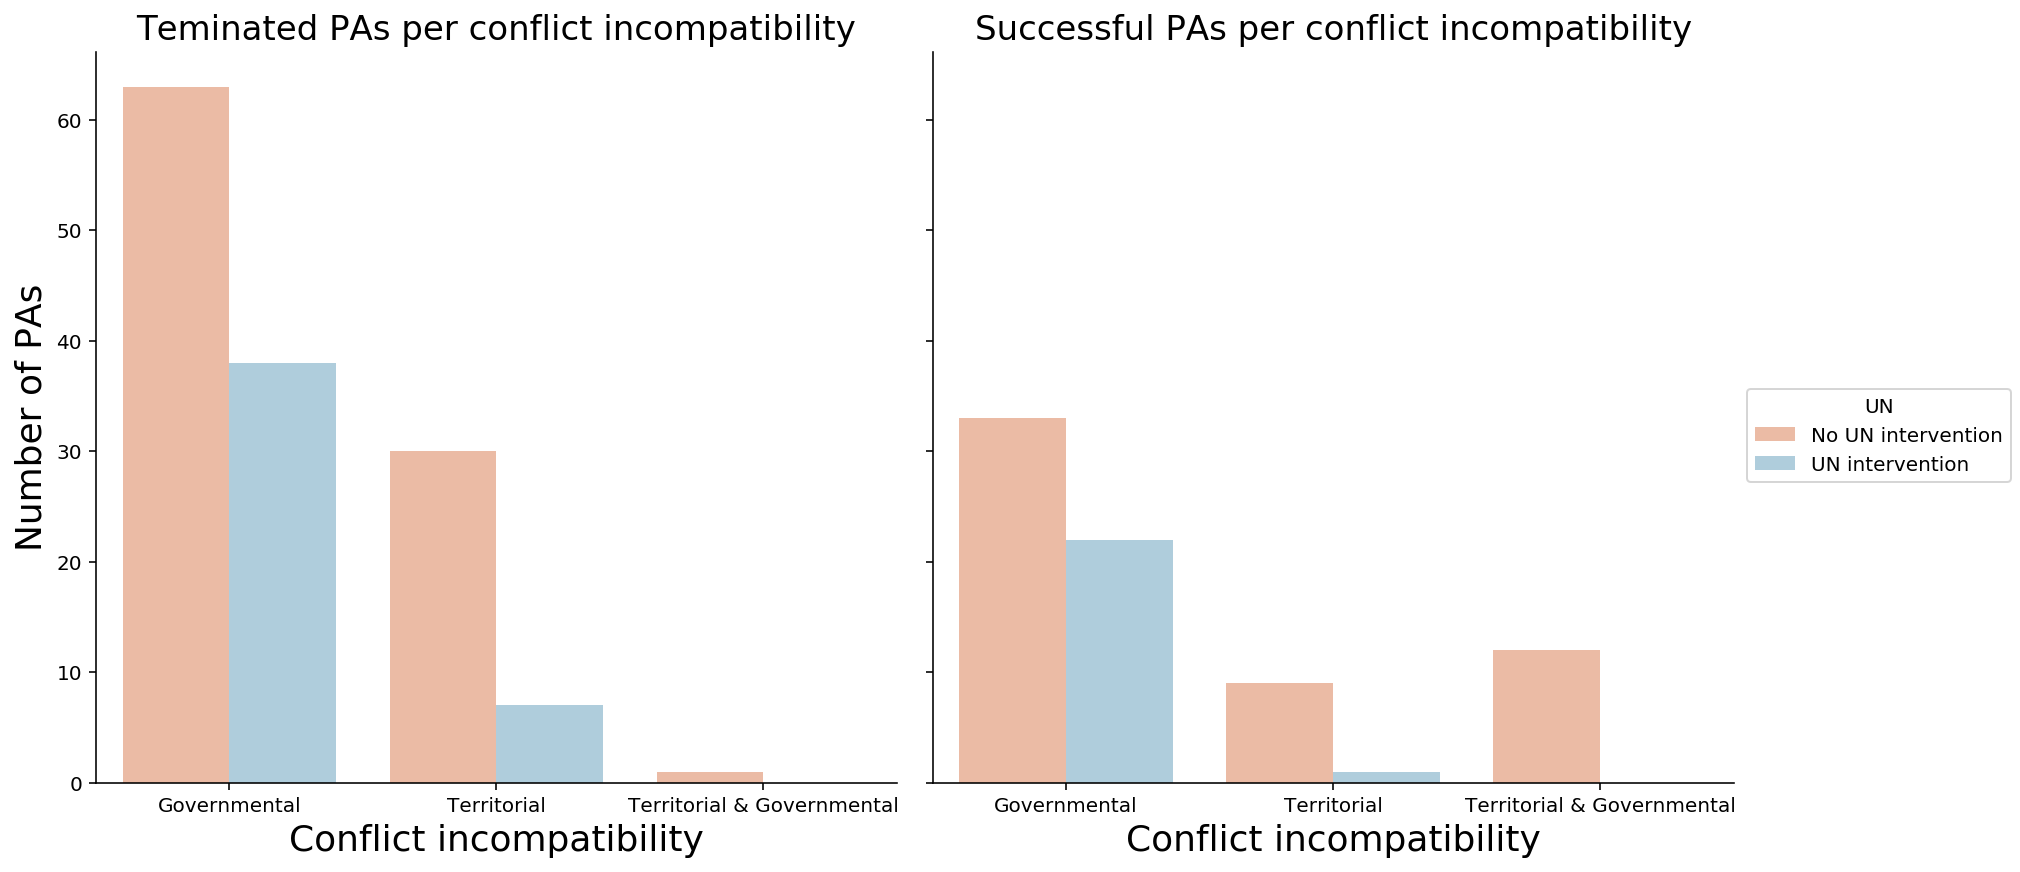

In [7]:
ax = sns.factorplot(kind='count', x='Inc', hue='UN', col='ended', size=6, data=pa, palette='RdBu');
plt.xlabel('Conflict incompatibility', fontsize=18)
ax.axes.flat[0].set_xlabel('Conflict incompatibility', fontsize=18)
ax.axes.flat[0].set_ylabel('Number of PAs', fontsize=18)
ax.axes.flat[0].set_title('Teminated PAs per conflict incompatibility', fontsize=17)
ax.axes.flat[1].set_title('Successful PAs per conflict incompatibility', fontsize=17)
plt.savefig('frontend/img/images/PA_Inc.png', transparent=True, bbox_inches='tight')

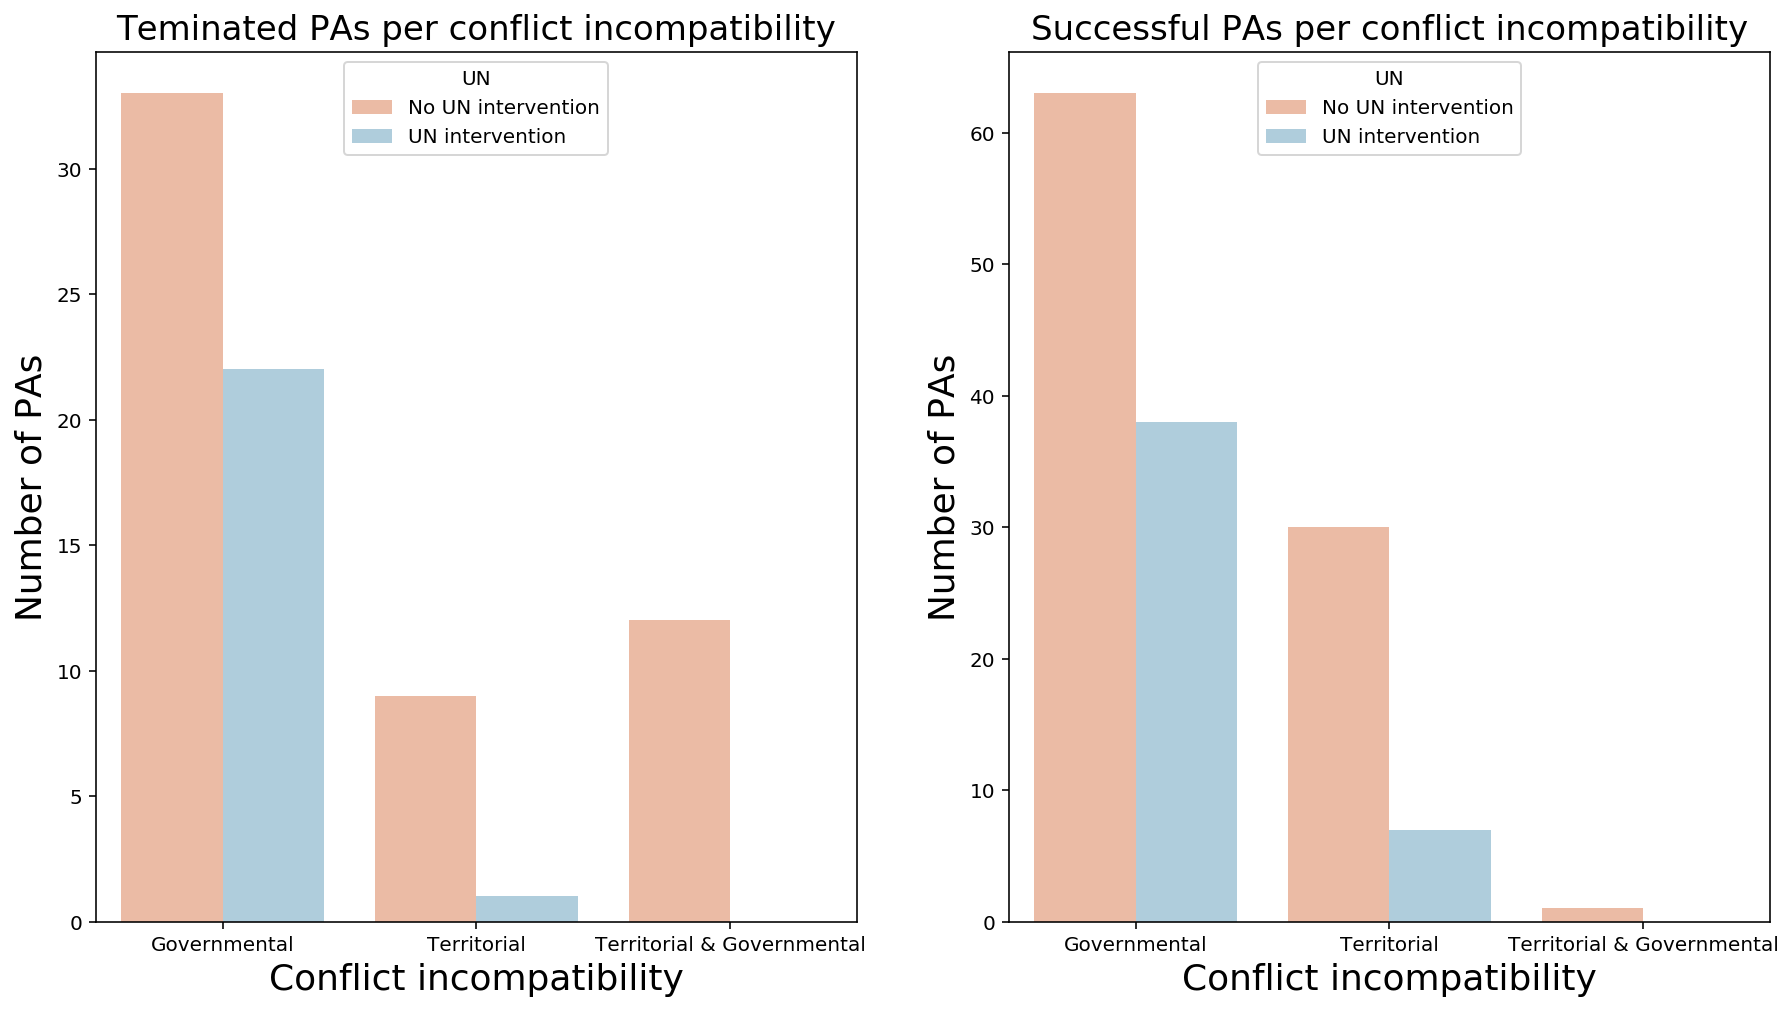

In [8]:
f, axarr = plt.subplots(1, 2, figsize = (15,8))
pa_ended = pa[pa.ended == 1]
pa_valid = pa[pa.ended == 0]
sns.countplot(x='Inc' , data=pa_ended, hue='UN', palette='RdBu', ax=axarr[0])
sns.countplot(x='Inc' , data=pa_valid, hue='UN', palette='RdBu', ax=axarr[1])
plt.xlabel('Conflict incompatibility', fontsize=18)
axarr[0].set_xlabel('Conflict incompatibility', fontsize=18)
axarr[1].set_ylabel('Number of PAs', fontsize=18)
axarr[0].set_ylabel('Number of PAs', fontsize=18)
axarr[0].set_title('Teminated PAs per conflict incompatibility', fontsize=17)
axarr[1].set_title('Successful PAs per conflict incompatibility', fontsize=17)
plt.savefig('frontend/img/images/PA_Inc.png', transparent=True, bbox_inches='tight')

The UN is more involved in governmental conflicts than territorial ones and has a higher percentage of success than ones where it is not involved. The UN never took part to Peace Agreements supposing to settle governmental and territorial conflicts. The governmental and territorial conflicts are the ones with the lowest success rate

- type of incompatibility \ success rate
- Governmental \ 0.65
- Territorial  \ 0.78
- Gov & Terr   \ 0.07

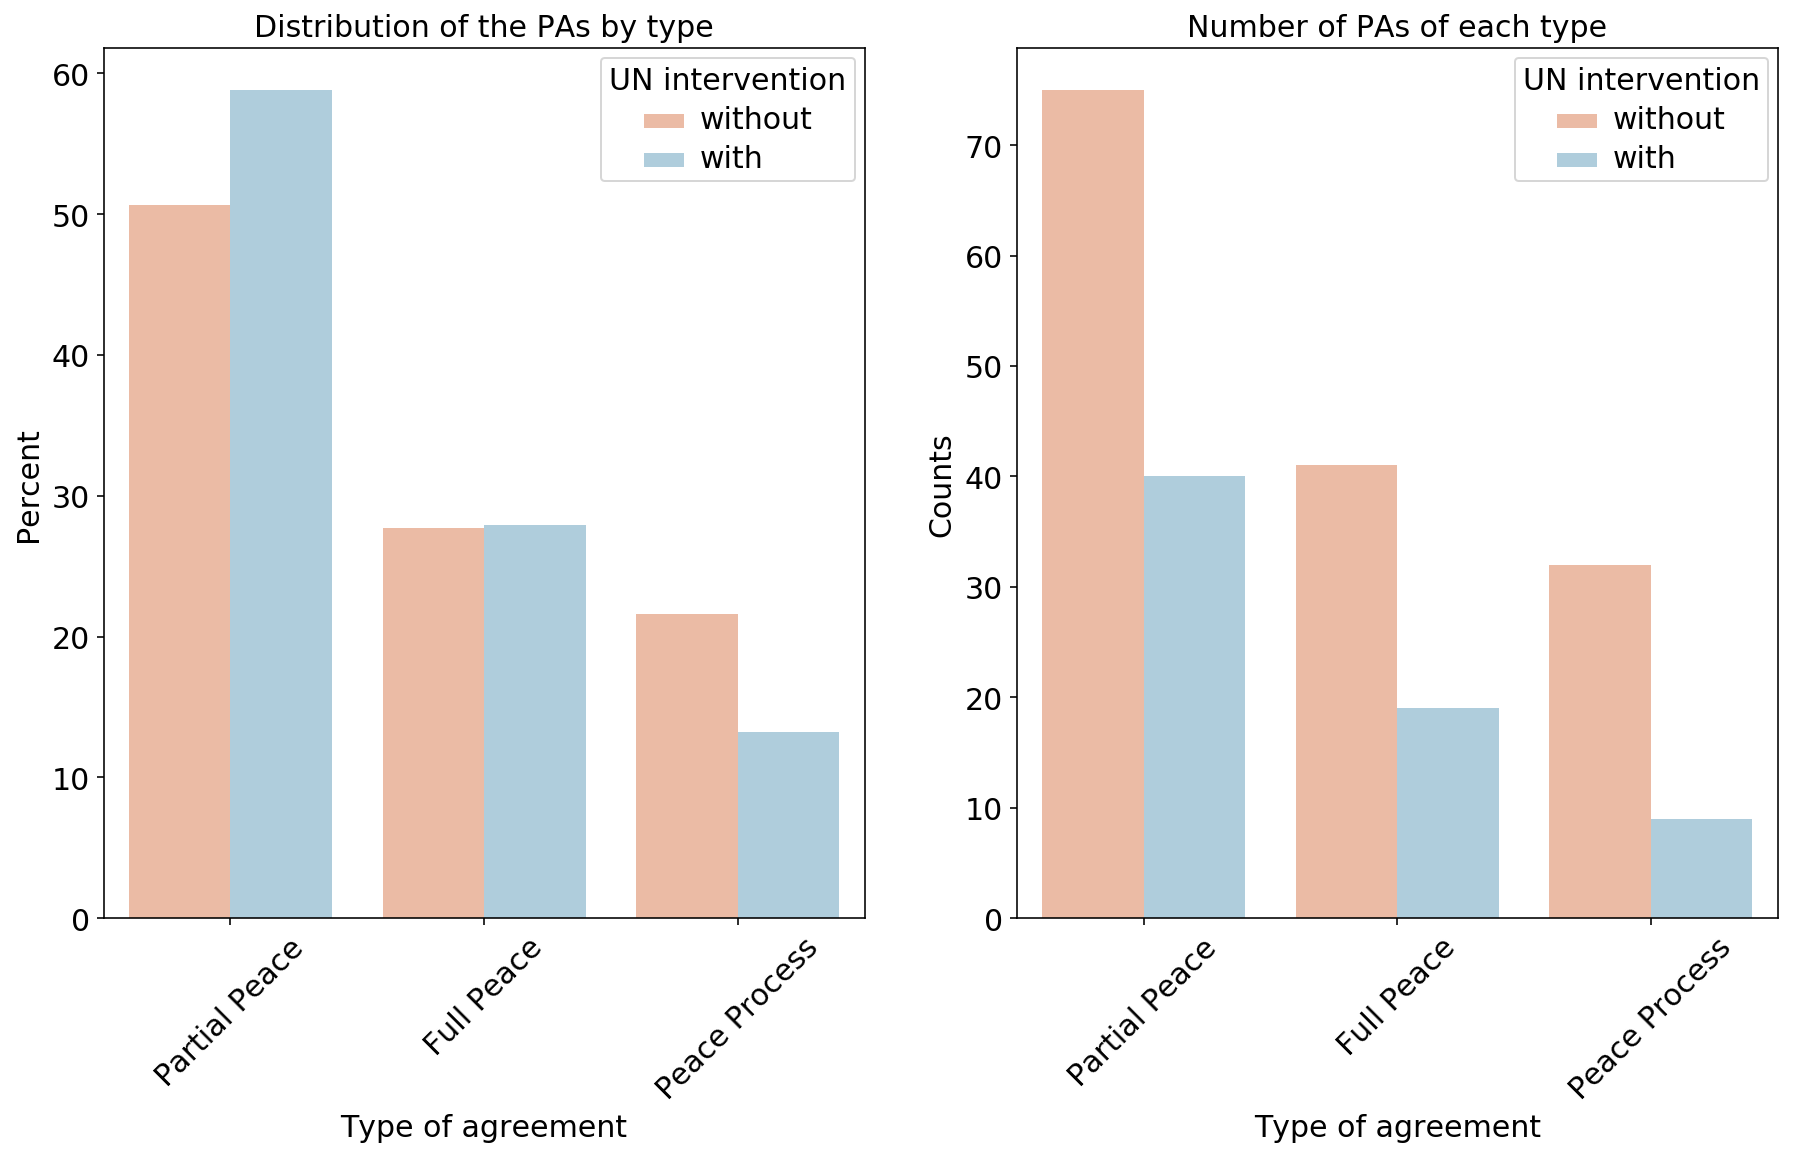

In [9]:
percent_categorical('pa_type' , df=pa , grouper = 'UN' , order = pa.pa_type.value_counts().index,
                   title = ['Distribution of the PAs by type' , 'Number of PAs of each type'],
                   label = 'Type of agreement' , 
                   legend = ['UN intervention' , 'without' , 'with']);

## Executive strength of peace agreements
Most peace agreements are partial peace agreements. Peace Process agreements are generally agreements that are signed at the begginning of a conflict and call for future peace agreements. This figure that UN involvment in the peace agreements does not change much the distribution of the the PAs types.



## UN involvment in the Peace agrements
First create a new dataset with only the agreements where the UN took part then, create a new column in the pa dataset (1 if the agreement was signed by the UN, else).

In [10]:
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
#pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('UN')]
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]

In [11]:
#Let's check how many conflicts did the UN solved
pa.groupby("UN").PAID.count()

UN
0    148
1     68
Name: PAID, dtype: int64

In [12]:
to_be_categorical = ['termdur' , 'noconf11' , 'CoVi01' ,'DyVi05' ]
for categ in to_be_categorical:
    pa[categ] = pd.Categorical(pa[categ] , pa[categ].unique())

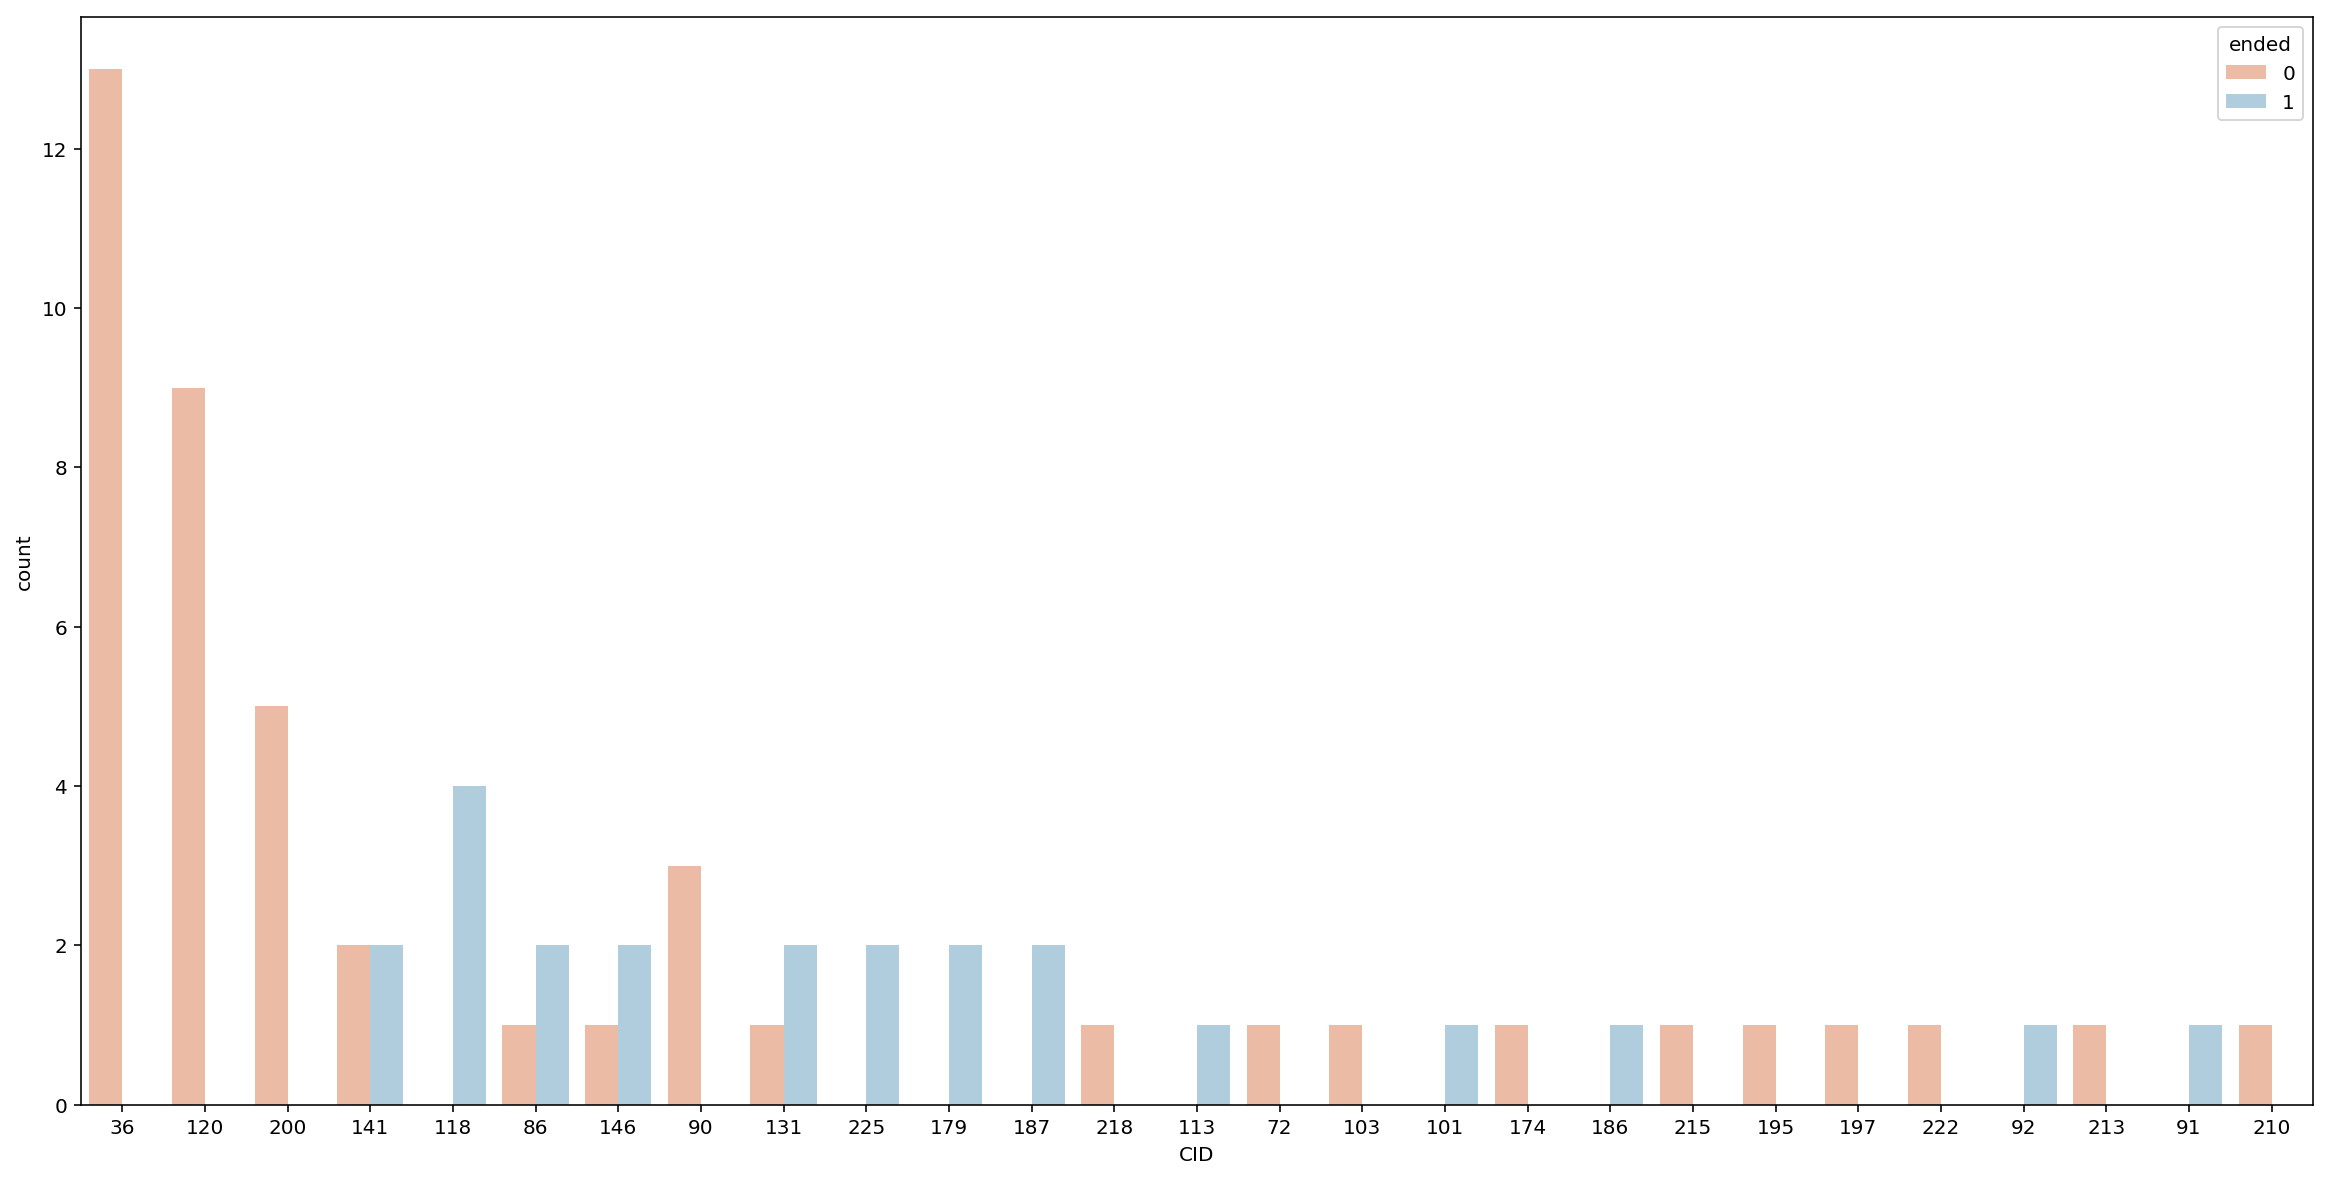

In [13]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data= pa_UN, hue='ended', order=pa_UN.CID.value_counts().index, palette='RdBu')

Out of the 216 agreements, The United Nations were involved as a third party in 68 of them which means 31%. We detect three groups of conflicts out of 35 concerned. 10 conflicts were not solved with the agreements, 3 conflicts were solved in three agrements with the one or two agreements that terminated. 11 conflicts had all of their respective agreements still valid as of 2011.


## Analysis of the Conflict ID variable

In [14]:
print('Number of conflicts treated in this dataset : %s' %(len(pa.CID.unique())))

Number of conflicts treated in this dataset : 60


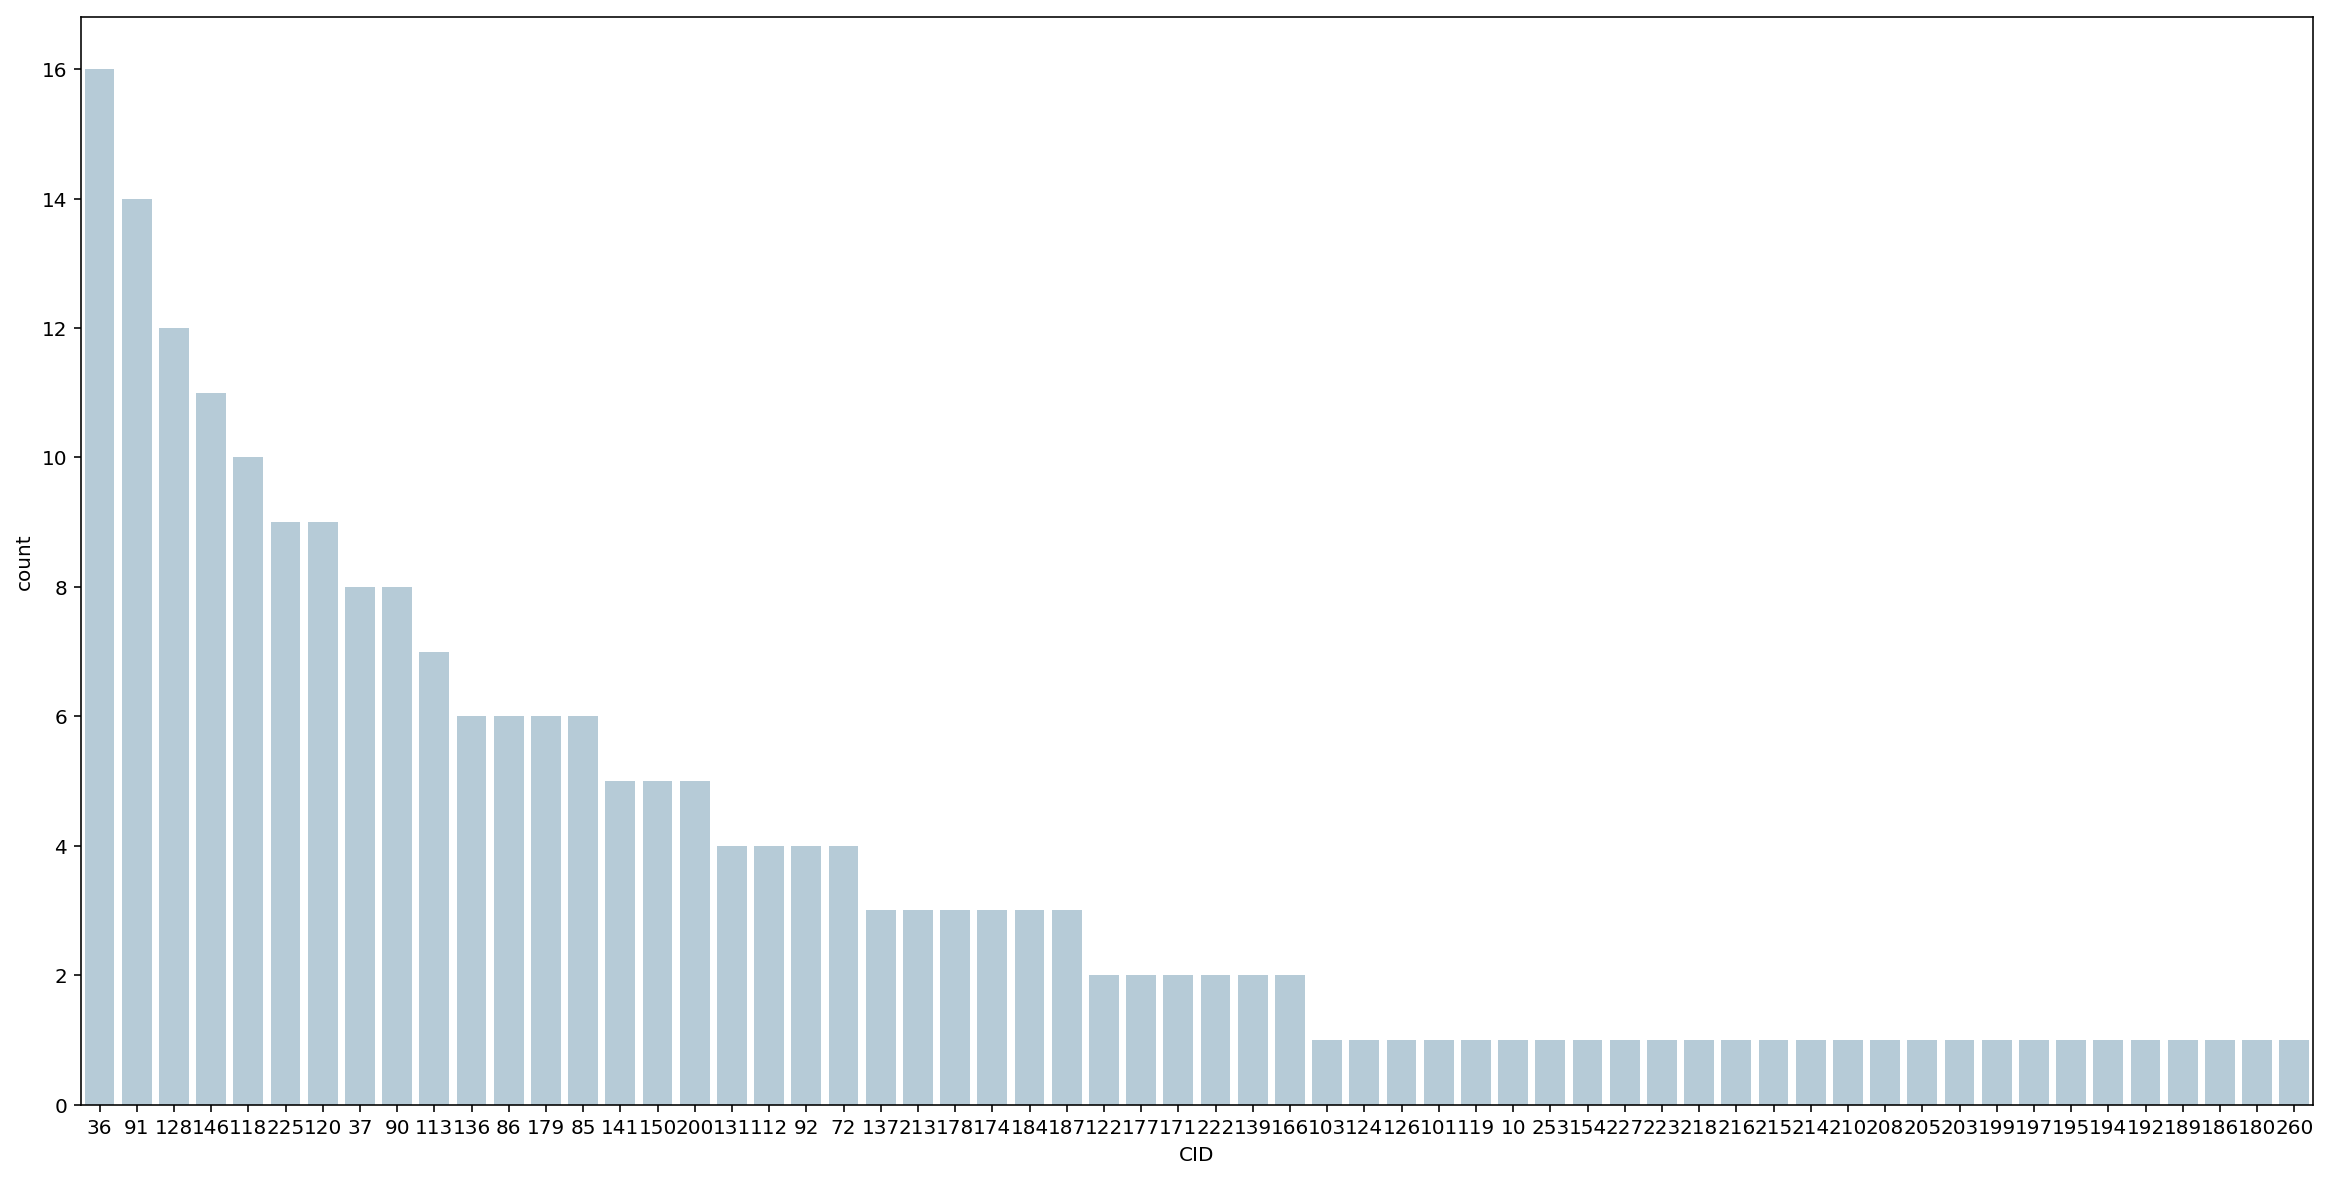

In [15]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data=pa, order=pa.CID.value_counts().index, color=COLOR_TREAT)

This plot shows that approximtely half of the conflicts were treated with one agreement. We wil split the rest of the exploration into two groups, the ones solved in one agreements and one grouping all the others.

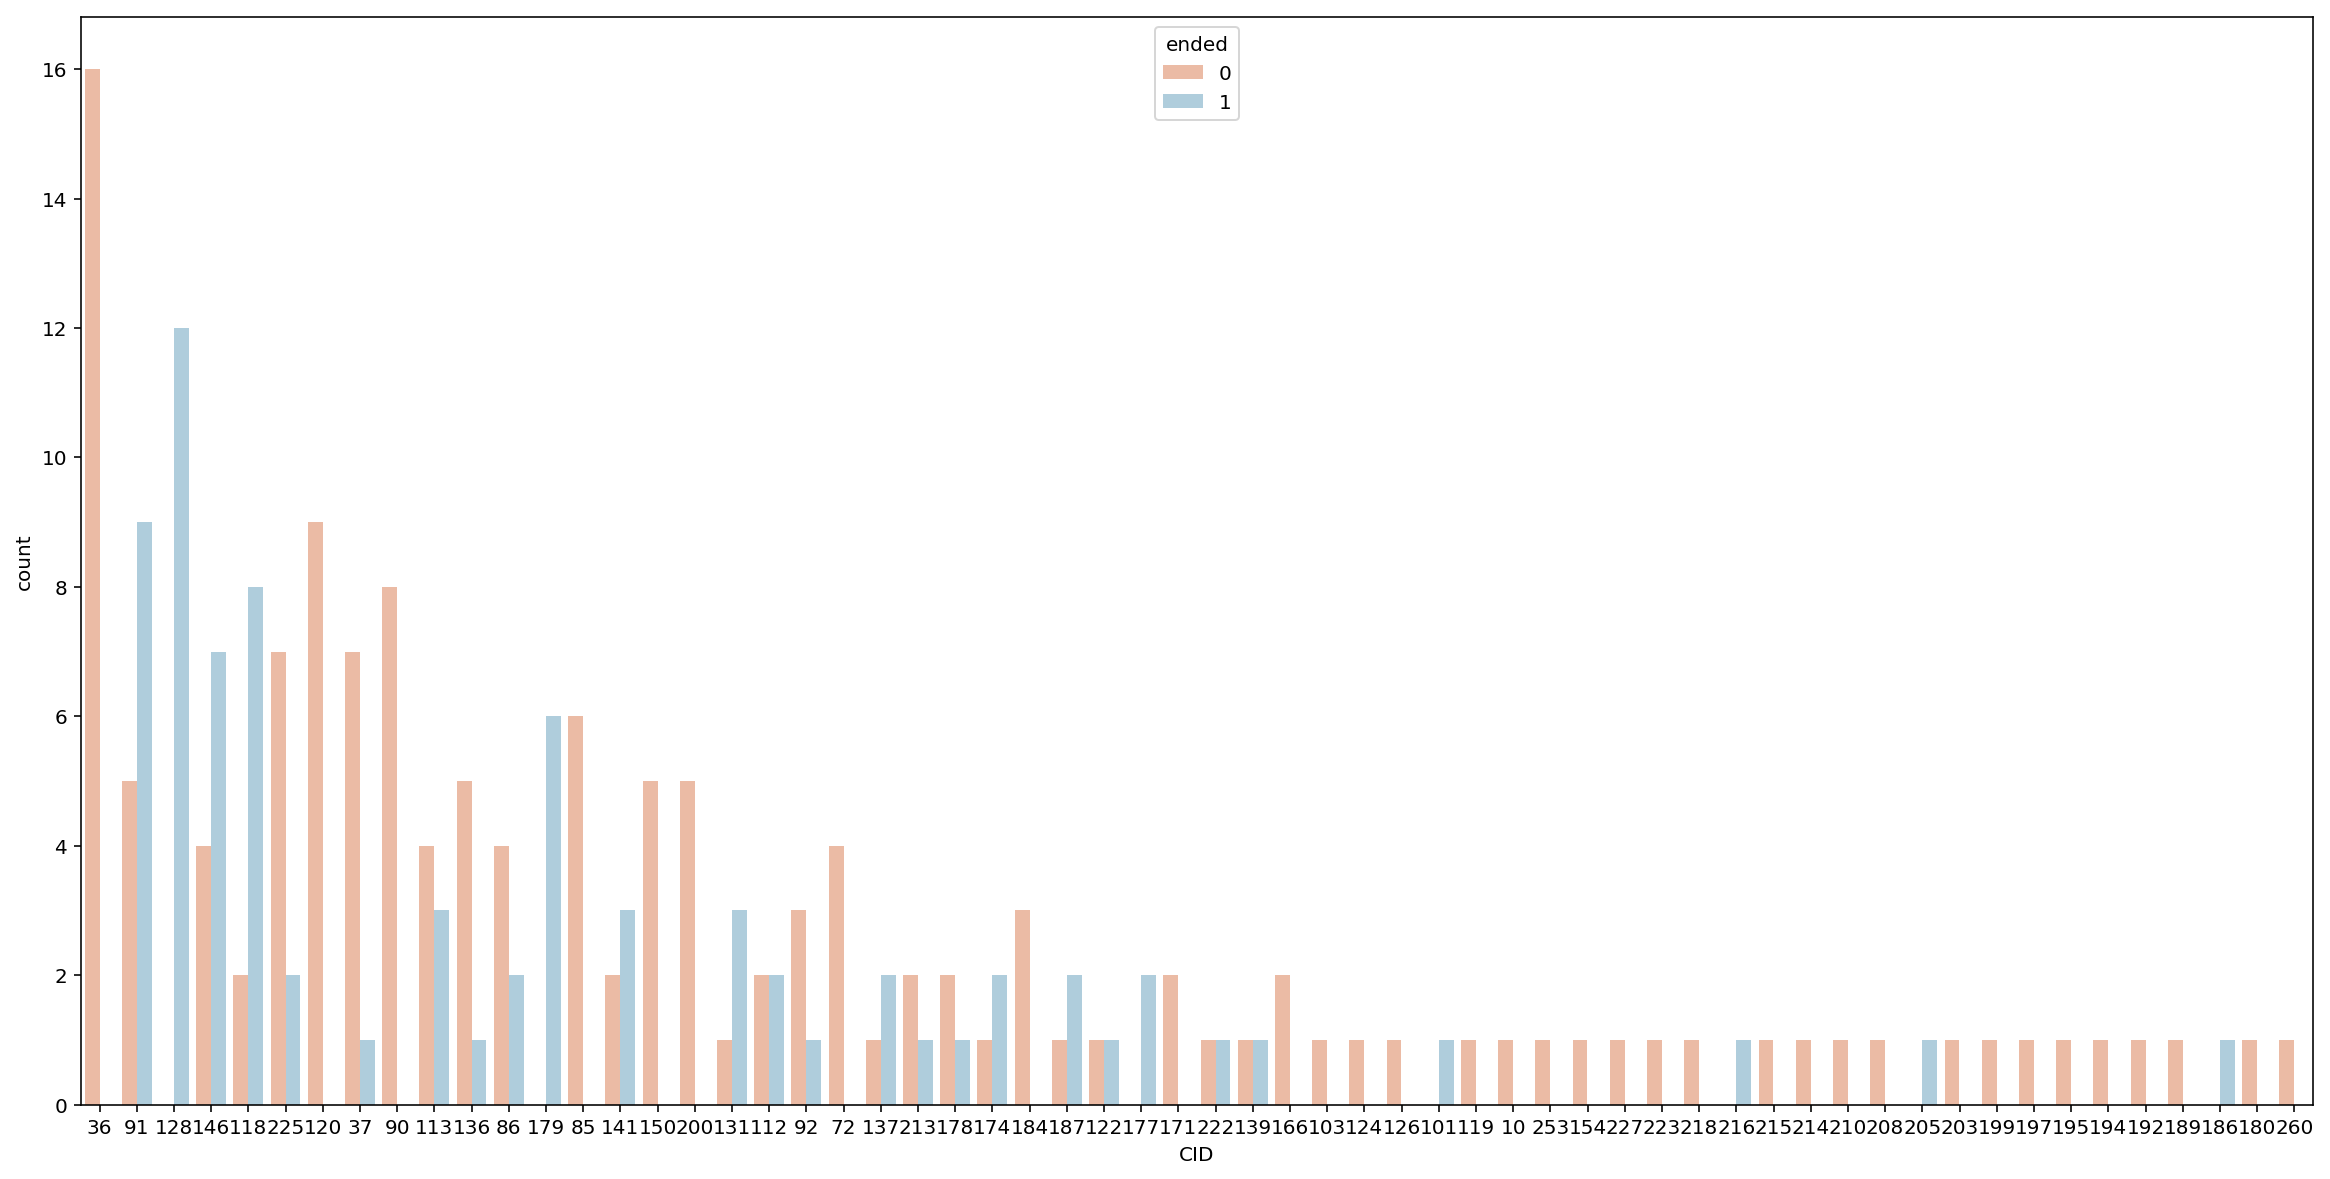

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data= pa, hue='ended', order=pa.CID.value_counts().index, palette='RdBu')

Most conflicts ended with agreements that are still valid today. 
All agreements of the conflicts (179, 128, 177, 101, 216 205, 185) were terminated which means that none of them worked. 


## Analysis of the conflicts that could not be ended by the peace agreements

In [17]:
pa_128 = pa.loc[pa['CID'] == 128]
#pa_128.to_csv('Unsolved_CID128.csv')

**Conflict 128 :**

Conflict between Iran and Iraq. Each of the 12 agreements were signed in 1975. Despite the first agreements, that was signed by The Shah of Iran and Saddam Hussein, all of them were signed by the same two representatives of Iran and Iraq, respectively by ABBAS-ALI KHALATBARY, Minister for Foreign Affairs of Iran and SAADOUN HAMADI, Minister for Foreign Affairs of Iraq. 
These agreements that were active in 1975, were than terminated between 1975 and 1980 until they were reactivated. Although the agreements were reactivated in 1980. Conflicts between Iran and Iraq did not stop in 1980, hence we can consider those agrrements as failures.

In [18]:
pa_179 = pa.loc[pa['CID'] == 179]
#pa_179.to_csv('Unsolved_CID179.csv')

**Conflict 179 :**

This conflict concerned the Government of the Republic of Rwanda and the Rwandese Patriotic Front. The six agreements were signed between 1992 and 1993. The incompatibility is governmental.
The five first agreements were signed to provide partial peace and the last one in august 1993 was supposed to prvide full peace to the region. None of the agreements provided for the holding of national talks to solve incompatibility and for the integration of rebels into civil service.
In April 1994, a genocide broke out and the peace agreements were never fully implemented.

**Conflict 101 : **

This conflict originated from a governmental incompatibility between South Africa and Namibia. The agreement was signed in 1978 and lasted two months. The agreement contained provisions for political incompatibilities leading to independence for Namibia, justice provisions with the return of refugees and release of political prisoners and behavior regulations such as (ceasefire, withdrawal of foreign forces and demobilisation of local armies).
 
**Conflict 216 : **

Government of Guinea Bissau - Military Junta for the Consolidation of Democracy, Peace and Justice. Incompatibility 2, The peace agreement lasted for 6 months.

** Conflict 205 : **

The agreement covered indigenous rights and culture and strengthened the position of the indigenous people in Mexico. incompatibility 2. The accord was never implemented and thus further peace talks that were planned in September the same year were suspended by EZLN. No exact date for the ending of the peace accord has been found.

All of the conflicts that were treated by only one agreement and had terminated originated from governmental imcompabilities. 

## Analyze conflicts solved in one agreements that are still valid as of 2011


In [19]:
idx = pa['CID'].value_counts()
idx_1 = idx[idx.values == 1]
idx_1.index

Int64Index([103, 124, 126, 101, 119,  10, 253, 154, 227, 223, 218, 216, 215,
            214, 210, 208, 205, 203, 199, 197, 195, 194, 192, 189, 186, 180,
            260],
           dtype='int64')

In [20]:
indx_1_ended = []
for ind in idx_1.index:
    #print(ind)
    a = pa.ended[pa['CID'] == ind]
    if a.iloc[0] == 0: # ended is the column 17 
        indx_1_ended.append(a.index)
    
pa_one = pa.iloc[np.array(indx_1_ended)[:,0], :]
pa_one.head(2)

,PAID,Region,GWNO,CID,Name,DyadName,actorId,Inc,pa_name,Year,...,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss,UN
196,8111991102301,Asia,811,103,Cambodia (Kampuchea): government,"Government of Cambodia (Kampuchea) - KR, Gover...","811, 1112, 1114, 1115",Governmental,Agreement on a Comprehensive Political Settlem...,1991,...,1,0,0,-99,-99,1,3,Full Peace,0,1
62,67868019790330,Middle East,"678, 680",124,North Yemen - South Yemen,Government of Yemen (North Yemen) - Government...,"678, 680",Territorial & Governmental,Kuwait agreement,1979,...,0,1,0,-99,1,1,1,Partial Peace,2,0


**Let's analyse the different combination of behavioral provisions that were taken and led to the success of the these agreements.**

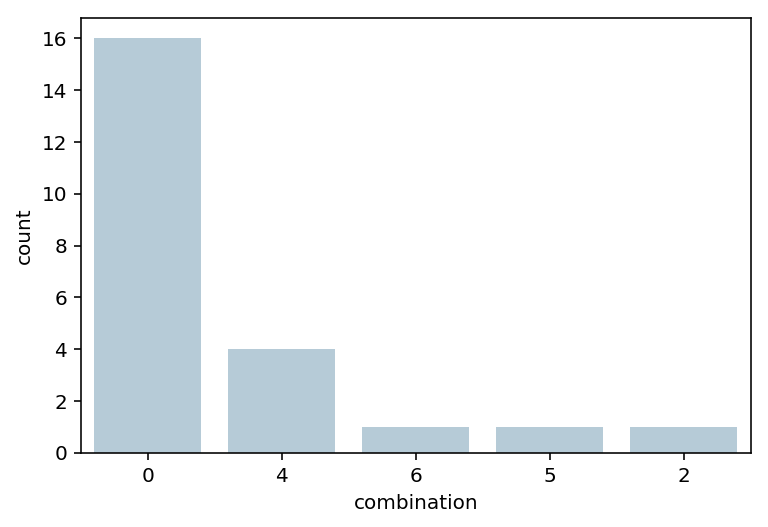

In [21]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 5
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)
pa_1behavior = pa_one.iloc[:, 20:25]
pa_1behavior['combination'] = pa_1behavior.apply(whatcombi, axis=1)
sns.countplot(x='combination', data=pa_1behavior, order=pa_1behavior.combination.value_counts().index, color=COLOR_TREAT)

8 successfull agreements established peace in providing for a ceasefire. 3 provided for the withdrawal of foreign forces and 3 others provided for a ceasefire, the integration of rebels into the army and the disarmement of the warring parties.

**Let's analyse the different combination of governmental and territorial incompatibility provisions that were taken and led to the success of the these agreements.**

Because we merged the incompabilities, the number of possible combinations to analyse equals to $2^{18}$ hence we saved the results to save computation time.

In [22]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 18
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)
#pa_1incompatibility = pa.iloc[:, 25:43]
#pa_1incompatibility['combination'] = pa_1incompatibility.apply(whatcombi, axis=1)
#pa_1incompatibility.to_csv('pa_1PA_success.csv')
pa_1incompatibility = pd.read_csv('data/pa_1PA_success.csv')
#pa_1incompatibility['inc'] = pa.iloc[np.array(indx_1_ended)[:,0], 8]

In [23]:
a = copy.deepcopy(pa_1incompatibility.groupby('combination').count().pp)
a.sort_values(ascending=False, inplace=True)

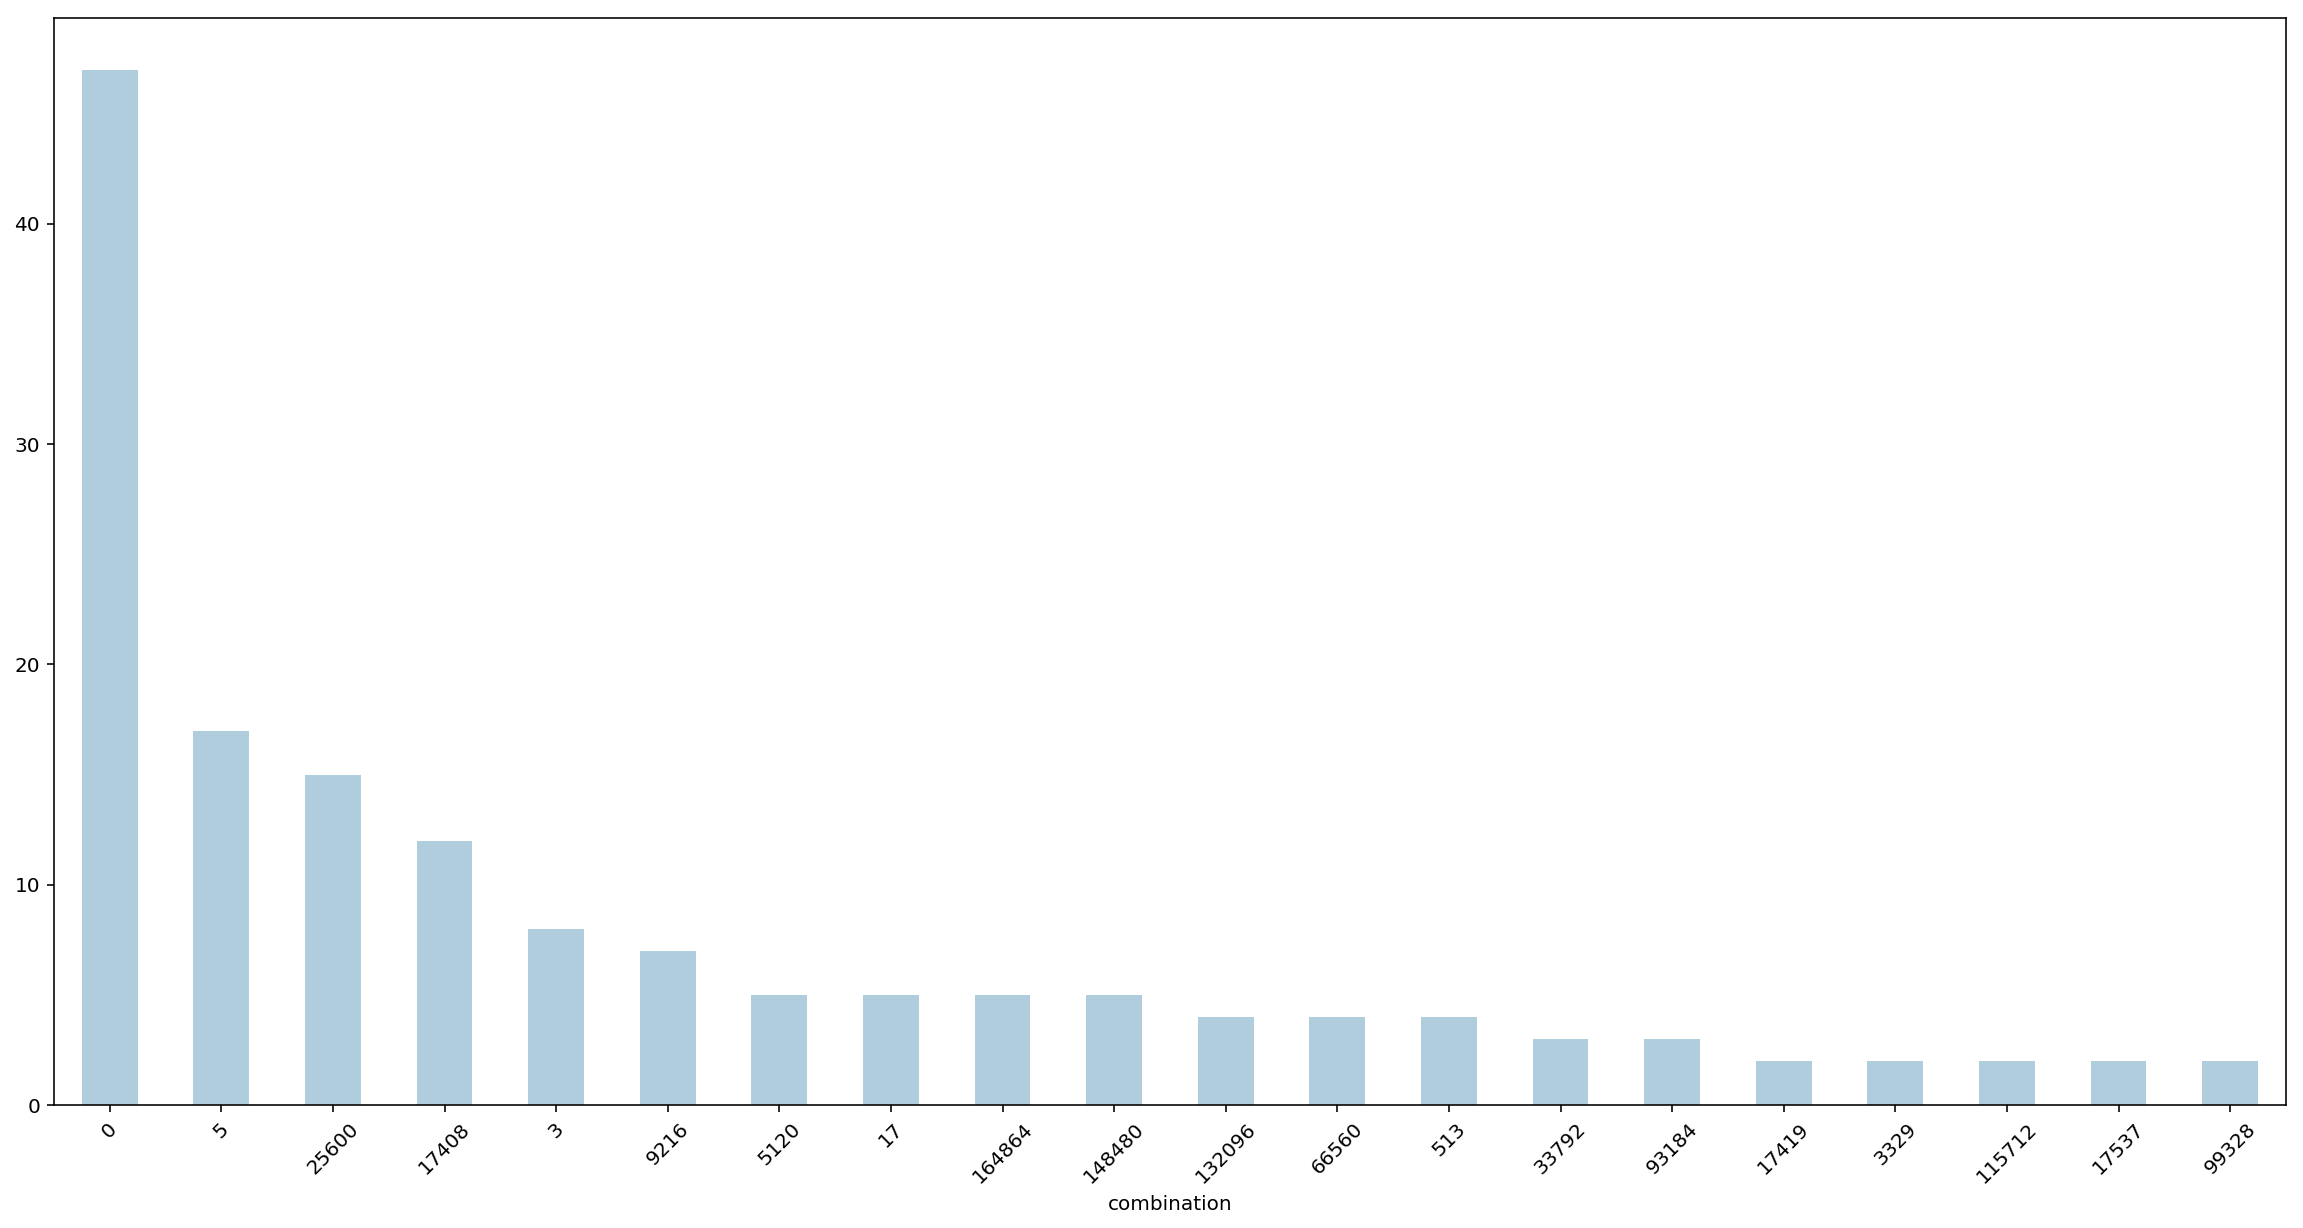

In [24]:
plt.figure(figsize=(20,10))
a[:20].plot('bar', rot=45, color=COLOR_TREAT)
#sns.countplot(x='combination', data=pa_1incompatibility, order=pa_1incompatibility.combination.value_counts().index)

Most of the time, no incompatibility provisions is set in those successful agreements. The abscence of incompatibility provisions might be an insight to explain their success as they do not have high expectations. The second most recurrent agreements treat territorial incompatibilities and grant the disputed region local governance. Governmental incompatibilities are mostly solved with provisions for elections and an interim government.

## Whatcombi :  This function returns corresponding combination to a pandas row dataframe
This function is to be used for each type of provisions.

In [25]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 2
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)

## Analysis of the agreements termination consistency in the variables :

- **ended** 
    - 0) if the agreements still holds
    - 1) if the agreement terminated
    
- **DyVi05** 
    - 1) the dyad violence restarted or continued
    - 0) the violence ended in this dyad
    - -99) Not applicable, agreement signed previous year

In [26]:
pa_result = pa.loc[:, ['ended', 'DyVi05']]
pa_result.head()

,ended,DyVi05
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0


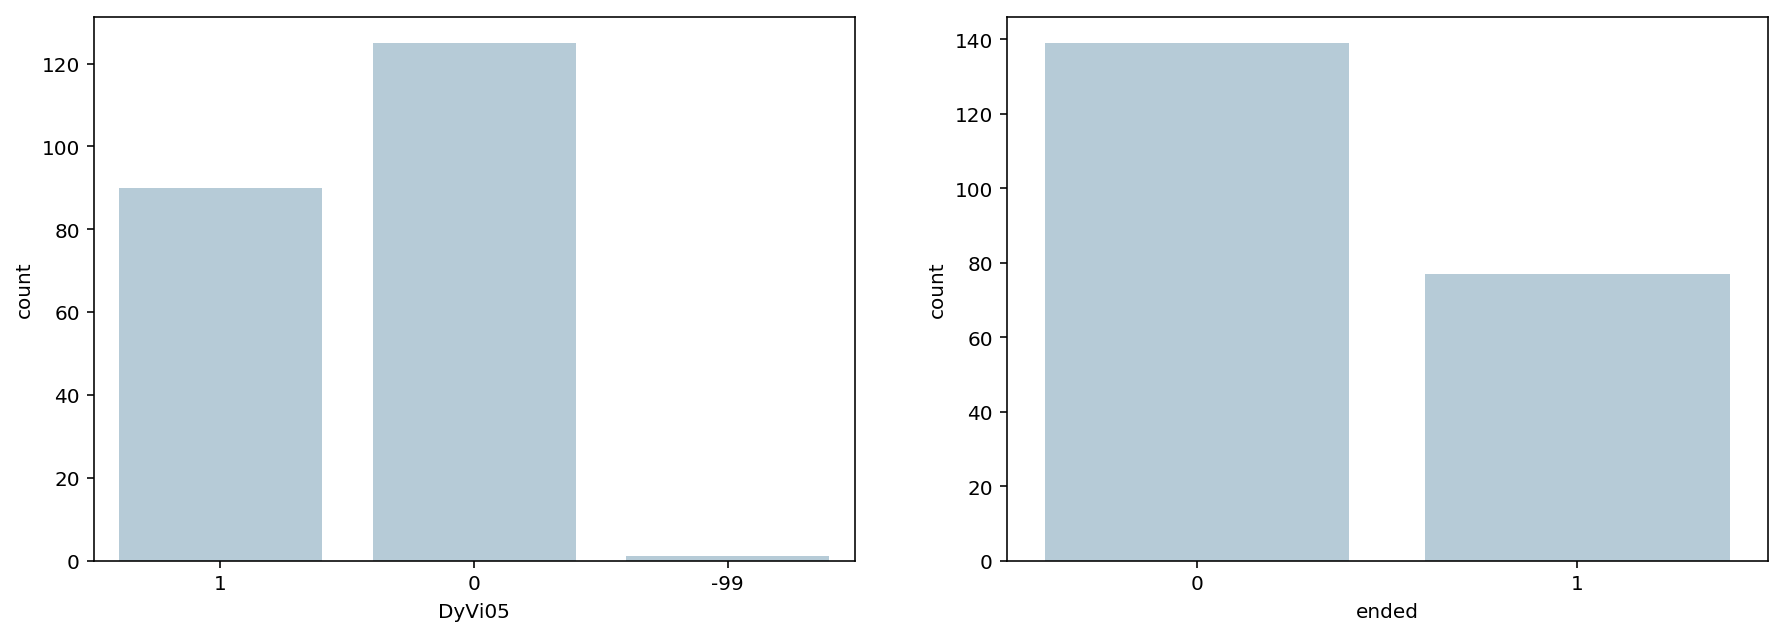

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='DyVi05', data=pa, color=COLOR_TREAT)
plt.subplot(122)
sns.countplot(x='ended', data=pa, color=COLOR_TREAT)

Thoses plots show that approximately 140 agreements ended there corresponding conflict. This information should be crossed with the number of conflicts treated in this dataset as there are only 60 unique conflicts.

In [28]:
pa_result['combination'] = pa_result.apply(whatcombi, axis=1)

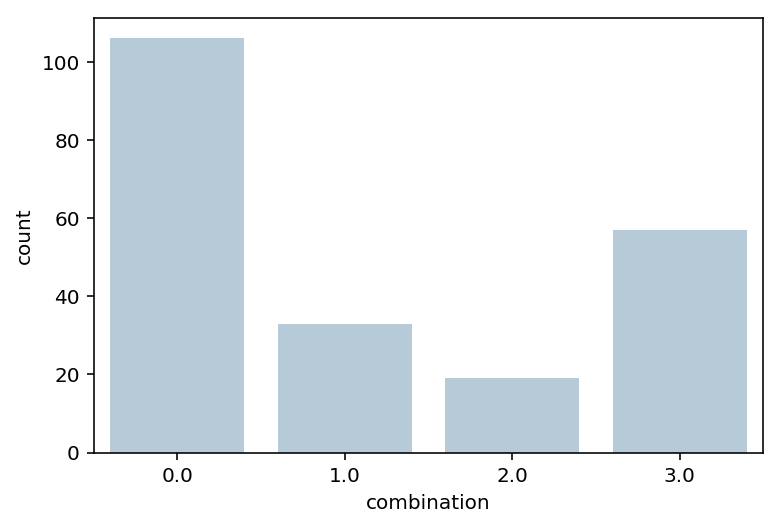

In [29]:
sns.countplot(x='combination', data=pa_result, color=COLOR_TREAT)

Approximately 160 out of 216 (74%) agreements have the same values for the *ended* and *DyVi05* variables. Hence we can say that those variables are consistent.

## Behaviour variables analysis

In [30]:
pa_behavior = pa.iloc[:, 14:18]
pa_behavior.head()

,cease,Intarmy,DDR,Withd
0,0,0,0,0
1,1,0,1,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


In [31]:
# run only once
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 4
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)
pa_behavior['combination'] = pa_behavior.apply(whatcombi, axis=1)

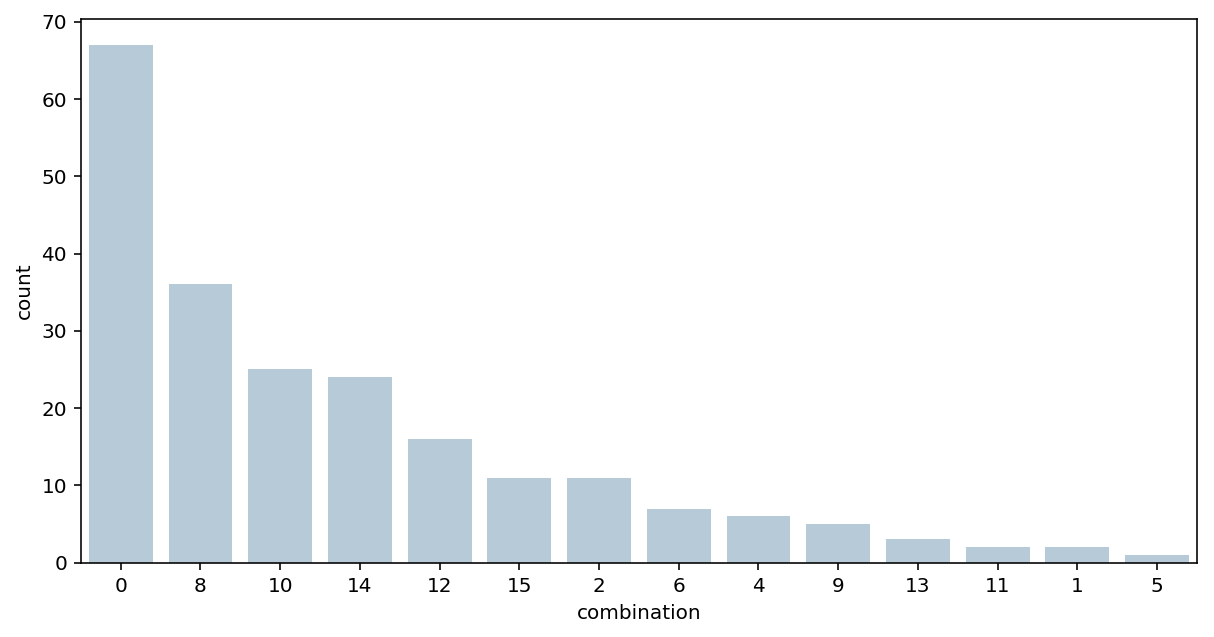

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(x='combination', data=pa_behavior, order=pa_behavior.combination.value_counts().index, 
              color=COLOR_TREAT)

1. Most agreements do not treat behavioral instructions
2. The second most recurrent combination concerns agreements that provided a ceasefire
3. third most recurrent :  ceasefire, Disarmement of foreign forces
4. fourth : ceasefire, integration in national army, disarmement of warring parties

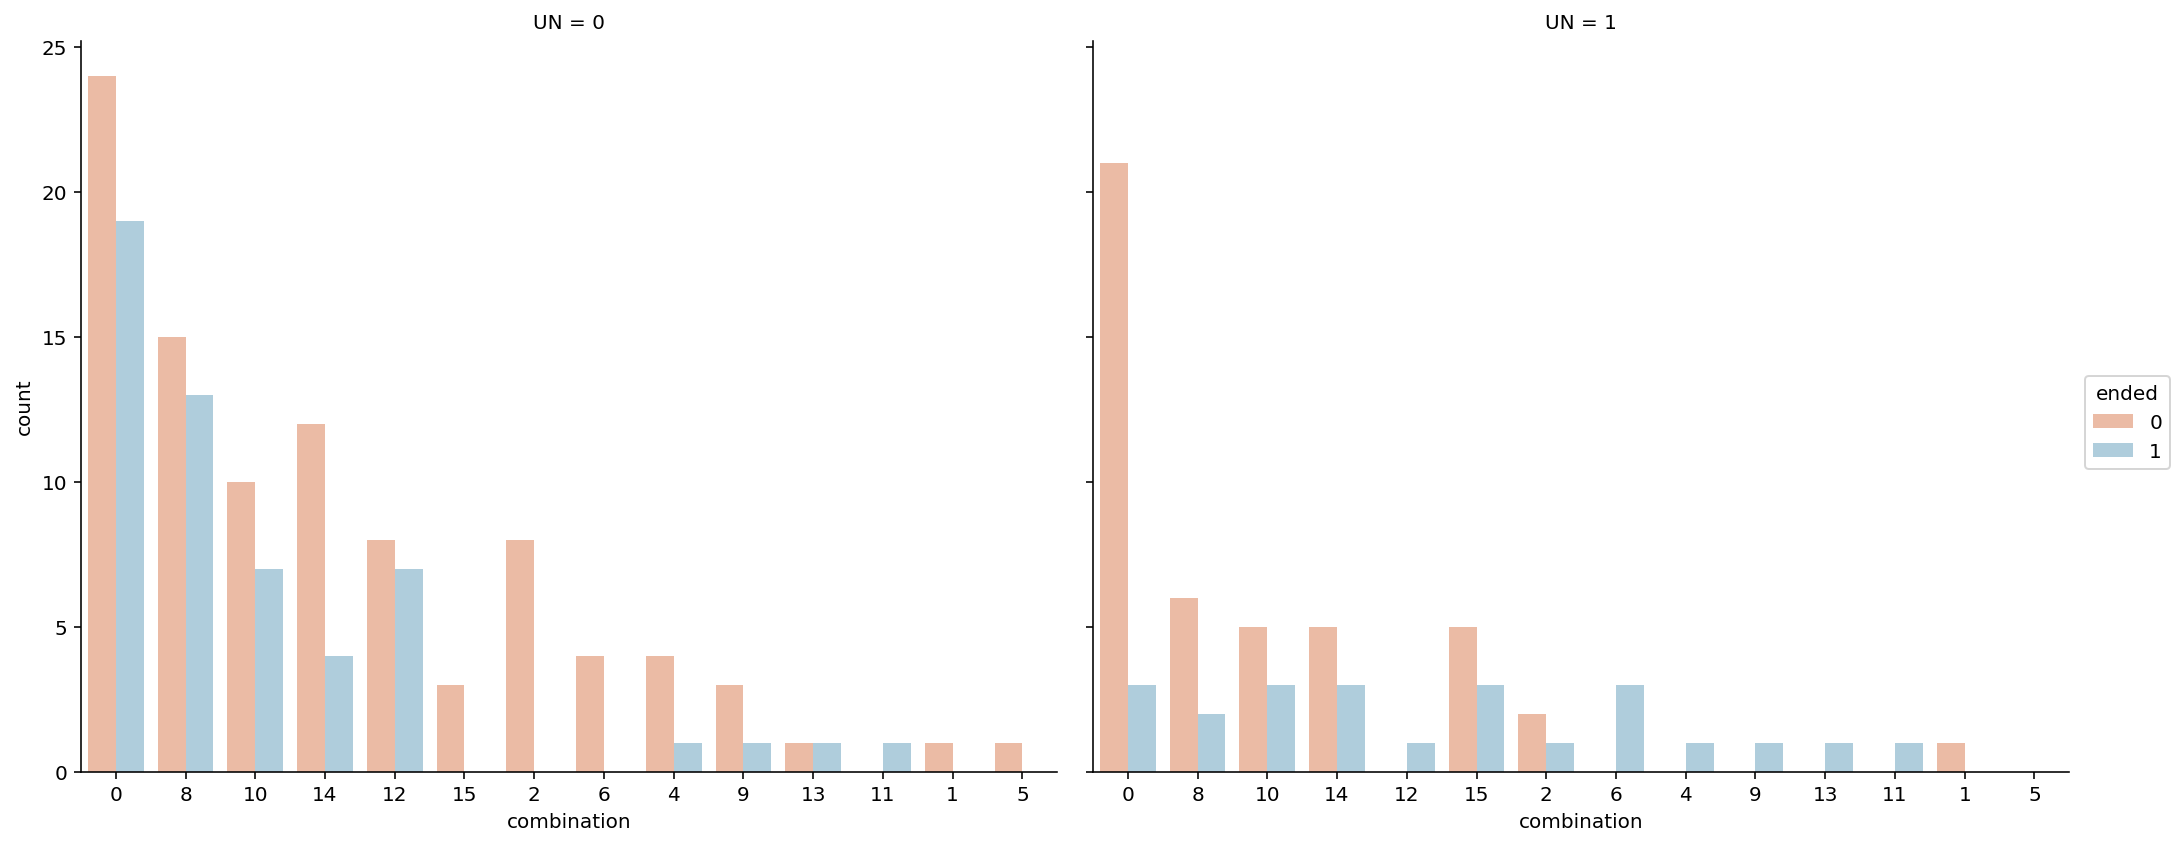

In [33]:
pa_behavior['ended'] = pa['ended']
pa_behavior['UN'] = pa['UN']
sns.factorplot(x='combination', data= pa_behavior, hue='ended', col='UN', kind='count', size=6, aspect = 1.2, 
               palette='RdBu', order=pa_behavior.combination.value_counts().index);

There are no much difference in agreements that terminate or not. However Two kinds of agreements were never terminated. The ones which provided for the creation of a new national army or the integration of rebels into the army and the withdrawal of foreign forces. No much difference can be established between UN agreements and the others considering the small amount of data available.

## Incompatibility variables analysis
### Government incompatibilities
Run the whatcombi box for n = 7 which leads to $2^7$ possible combinations

In [34]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 7
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)
pa_incompatibility_gov = pa.iloc[:, 19:26]
pa_incompatibility_gov.head()

,pp,Intgov,Intciv,Elections,Interrim,Natalks,Shagov
0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0


In [35]:
pa_incompatibility_gov['combination'] = pa_incompatibility_gov.apply(whatcombi, axis=1)

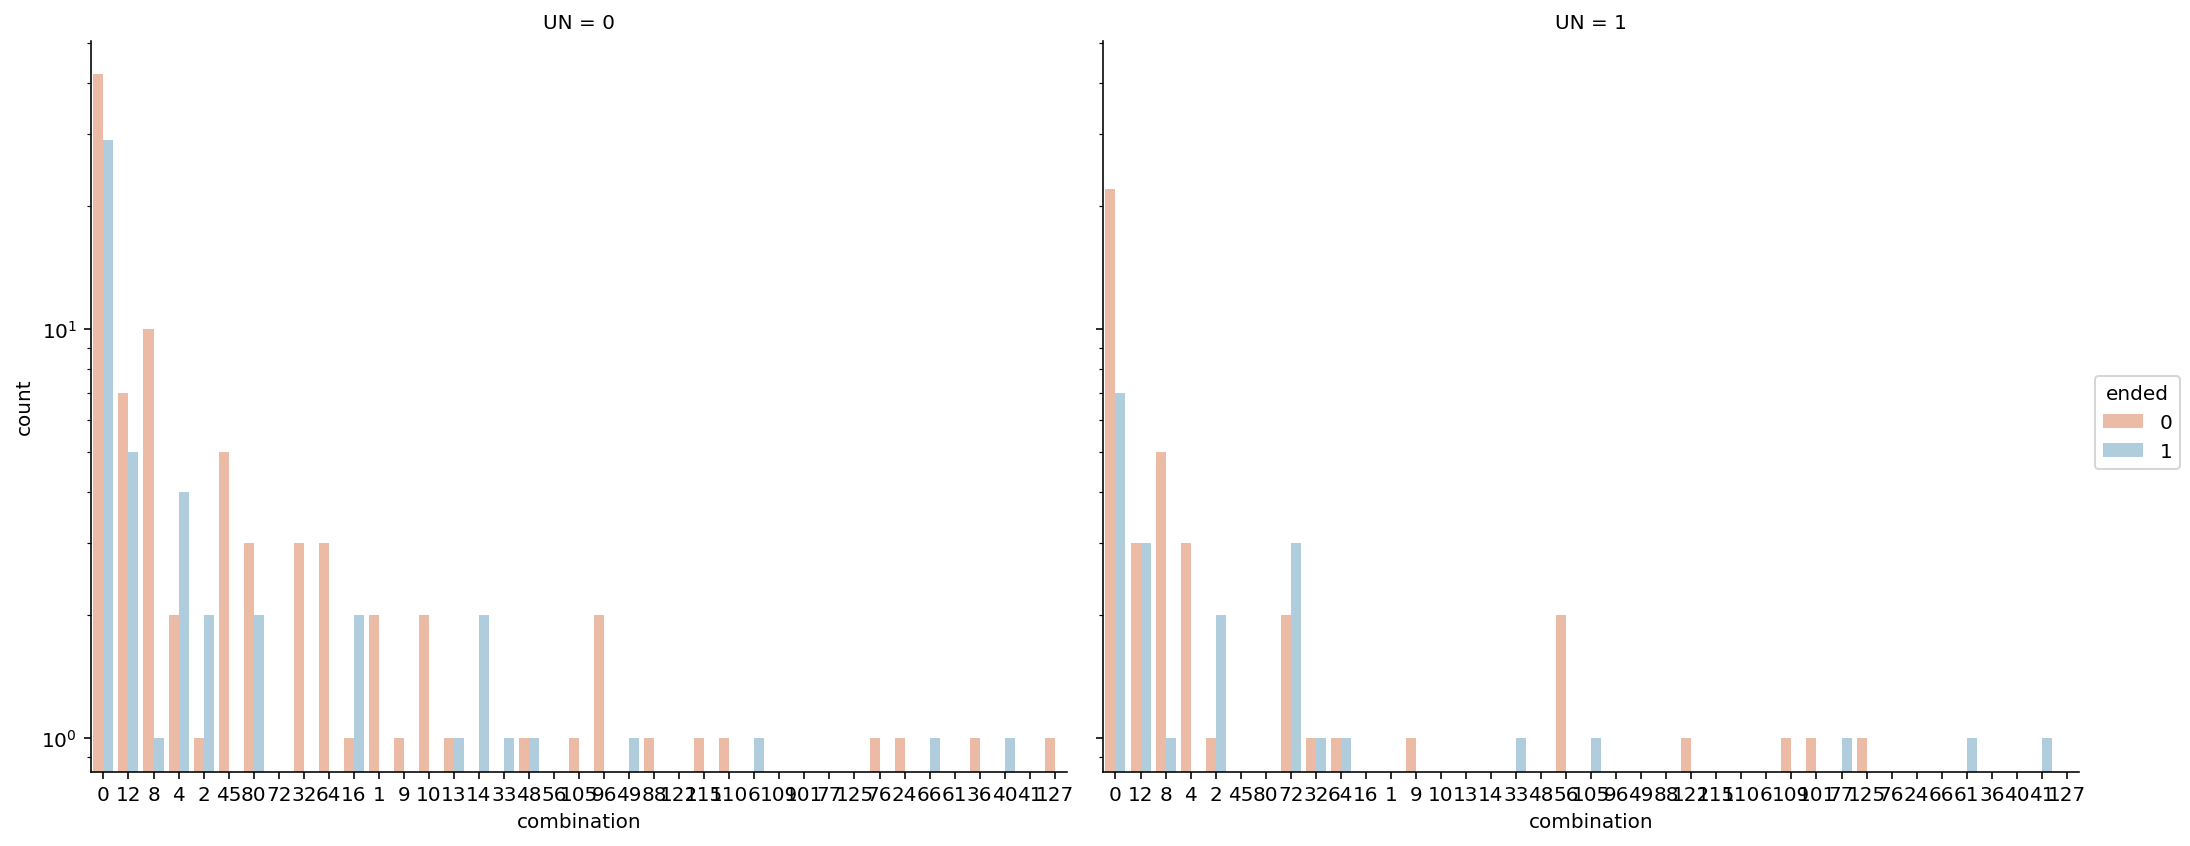

In [36]:
pa_incompatibility_gov['UN'] = pa["UN"]
pa_incompatibility_gov['ended'] = pa['ended']
sns.factorplot(x='combination', data=pa_incompatibility_gov, hue='ended', col='UN', kind='count', size=6, aspect = 1.2,
              palette='RdBu', order=pa_incompatibility_gov.combination.value_counts().index)
plt.yscale('log')

While most agreements do not deal with governmental incompatibilities, the ones that do mostly provide for elections and electoral reforms for rebel integration into the interim government.

The main difference that can be observed between UN agreements and non UN agreements is that the UN agreements usually provide provisions for an interim government and elections while non UN agreements msotly only provide provisions for an election.

The *Pol_prov* feature could be used to generalize the inclusion of political provisions in the agreement

### Territorial incompatibilities
run whatcombi box with n = 9

In [37]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 9
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)
pa_incompatibility_ter = pa.iloc[:, 27:36]
pa_incompatibility_ter.head()

,Aut,Fed,Ind,Ref,Shaloc,Regdev,Cul,Demarcation,Locgov
0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,1,0,0


In [38]:
pa_incompatibility_ter['combination'] = pa_incompatibility_ter.apply(whatcombi, axis=1)

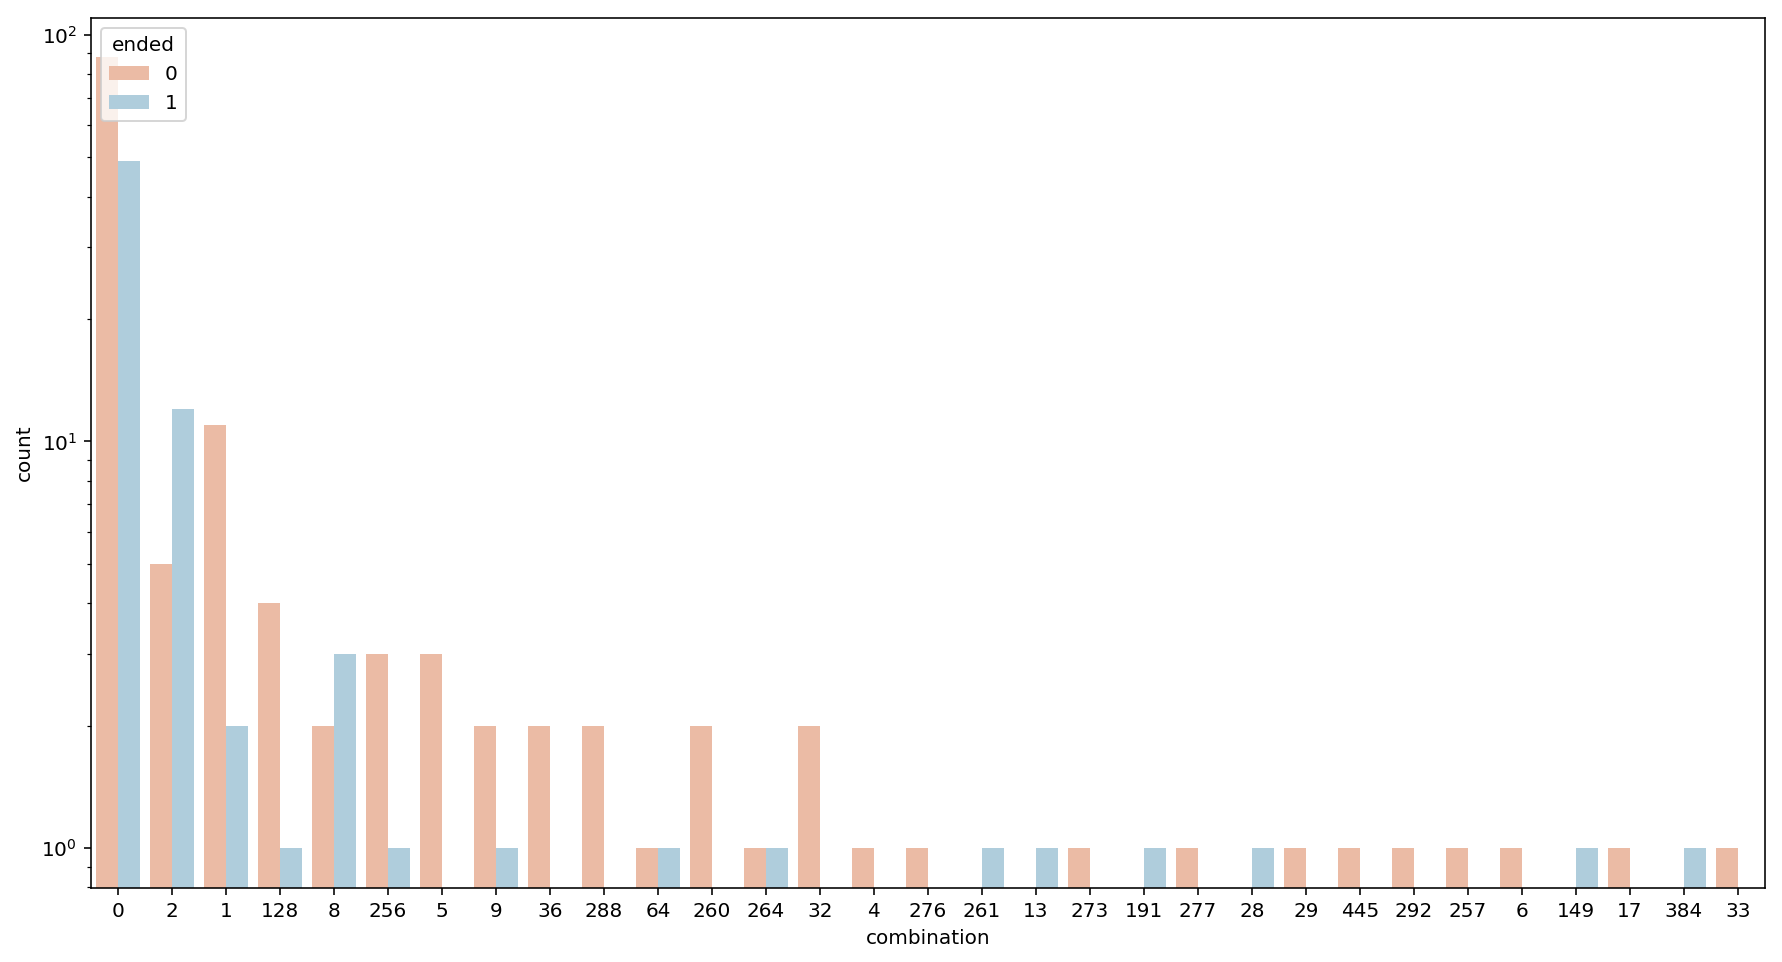

In [39]:
pa_incompatibility_ter['UN'] = pa["UN"]
pa_incompatibility_ter['ended'] = pa['ended']
plt.figure(figsize=(15,8))
sns.countplot(x='combination', data=pa_incompatibility_ter, hue='ended',
             palette='RdBu', order=pa_incompatibility_ter.combination.value_counts().index)
plt.yscale('log')

There is no significant difference between UN agreements and the rest to display it. However we can see with this plot that when agreements have territorial provisions, it generally concerns the demarcation of a border or the government granting the disputed region to the other warring party.

## Justice variables analysis
Run whatcombi box with n = 4

In [40]:
def whatcombi(pa):
    # returns the corresponding combination number of the dataset
    # set : n and rerun box in fct of the number of binary features to be analyzed
    n = 4
    # Create 2^n vectors of size n representing a combination
    lst = [list(i) for i in itertools.product([0, 1], repeat=n)]
    for i in range(len(lst)):
        a = pa == lst[i]
        # if all values in a are true, it is the good combination
        if all(x for x in a.values):
            return(i)
pa_justice = pa.iloc[:, 37:41]
pa_justice.head()

,Amn,pris,Recon,Return
0,0,0,0,0
1,0,1,0,1
2,0,1,0,0
3,1,0,0,1
4,0,1,1,0


In [41]:
# run only once
pa_justice['combination'] = pa_justice.apply(whatcombi, axis=1)

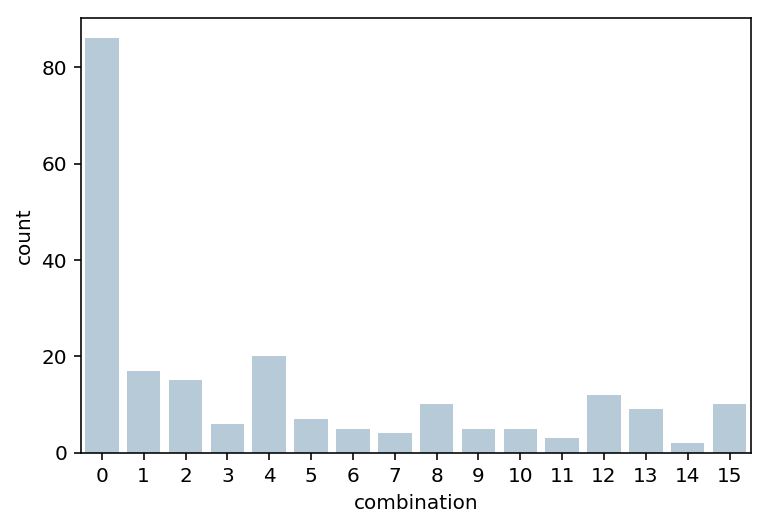

In [42]:
sns.countplot(x='combination', data=pa_justice, color=COLOR_TREAT);

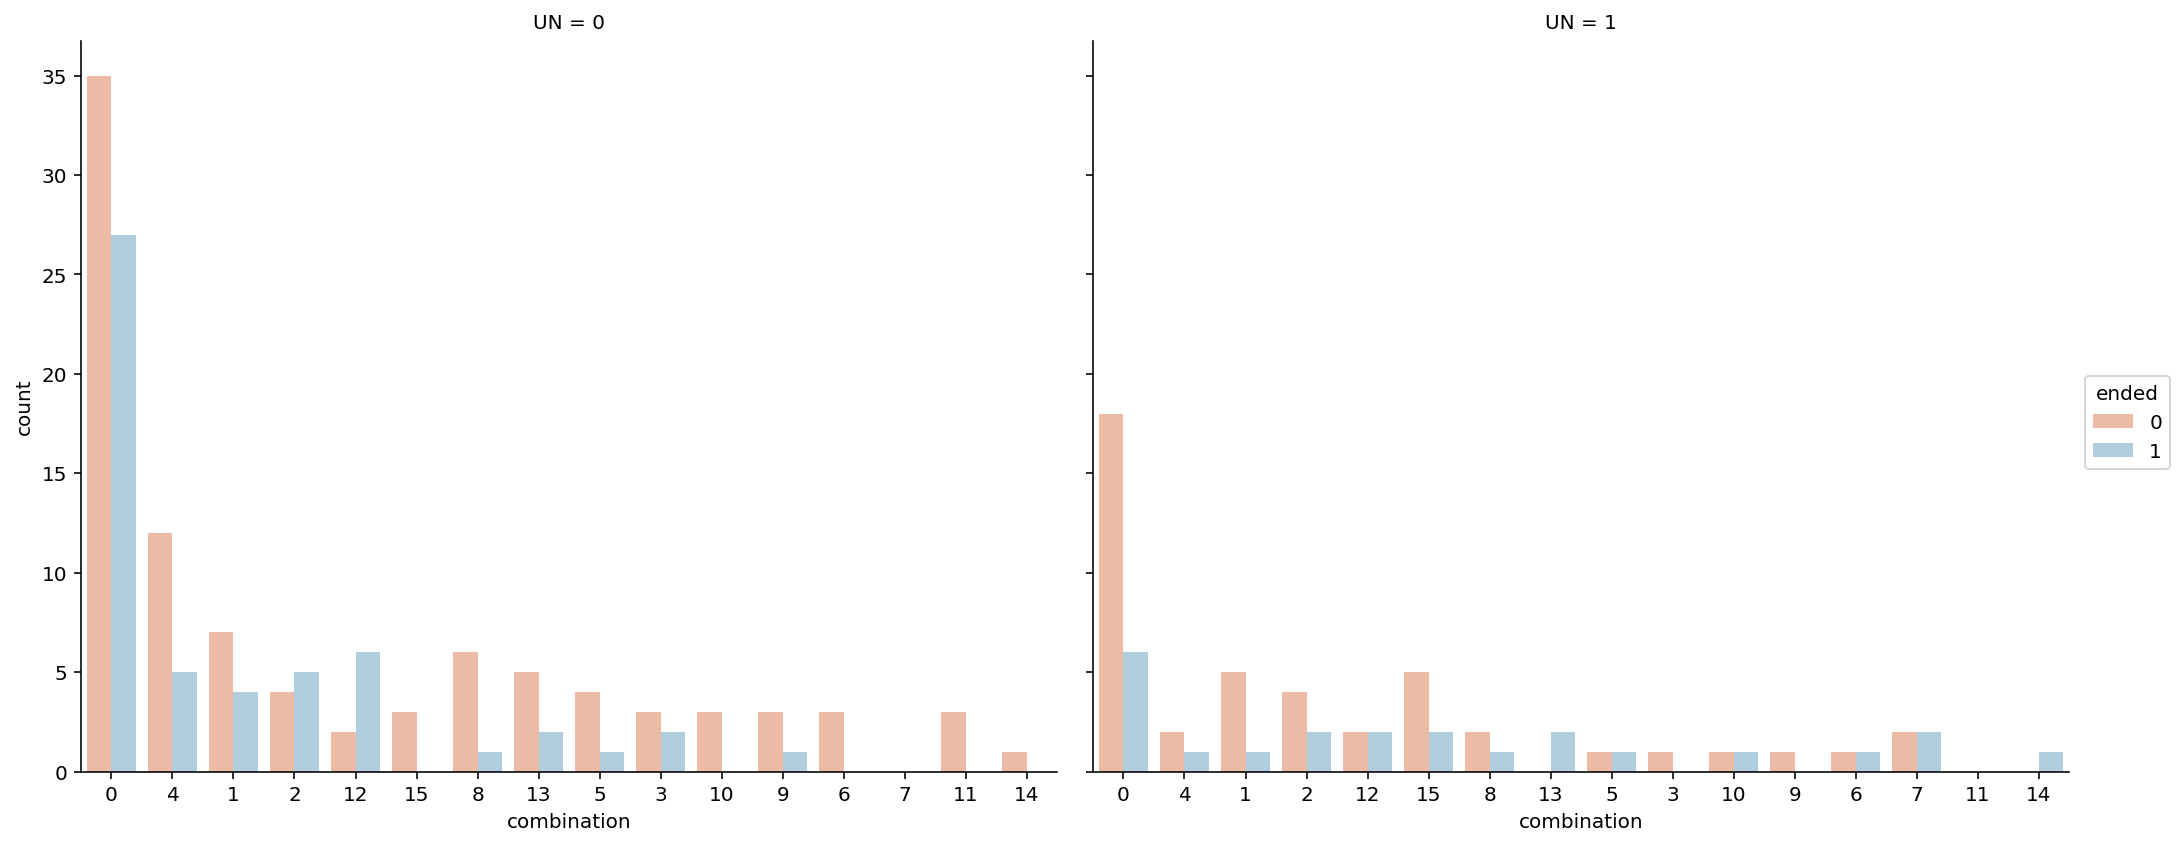

In [43]:
pa_justice['UN'] = pa["UN"]
pa_justice['ended'] = pa['ended']
sns.factorplot(x='combination', data=pa_justice, hue='ended', col='UN', kind='count', size=6, aspect = 1.2,
              palette='RdBu', order=pa_justice.combination.value_counts().index);

- The most recurring combination is the one where no justice issues is treated in the agreement.
- The second most recurring is the one where the agreement provided a release of prisoners

It seems like UN agreements uses a smaller amount of combinations than other agreements, particularly, the combination 13 corresponding to an amnesty, a release of prisoners and the return of refugees. Again this interpretation has to be understood with modesty as we lack data to be more consistent. A less naïve analysis will be made later to solve this issue.

The *Justice_prov* feature is set to one if any of the justice provisions was applied in the agreement. This variable could be of good use to reduce the number of features and keep an insight of the rather or not 'Justice' issues treated in the agreement.

## Implementation variables analysis

In [44]:
pa_implementation = pa.iloc[:, 42:46]
# study ended results in fct of all combinations of the binary features
pa_implementation.head()

,Reaffirm,Outlin,PKO,Co_impl
0,0,1,0,0
1,0,0,0,0
2,0,1,0,1
3,0,1,1,0
4,0,0,0,1


In [45]:
# run only once
pa_implementation['combination'] = pa_implementation.apply(whatcombi, axis=1)

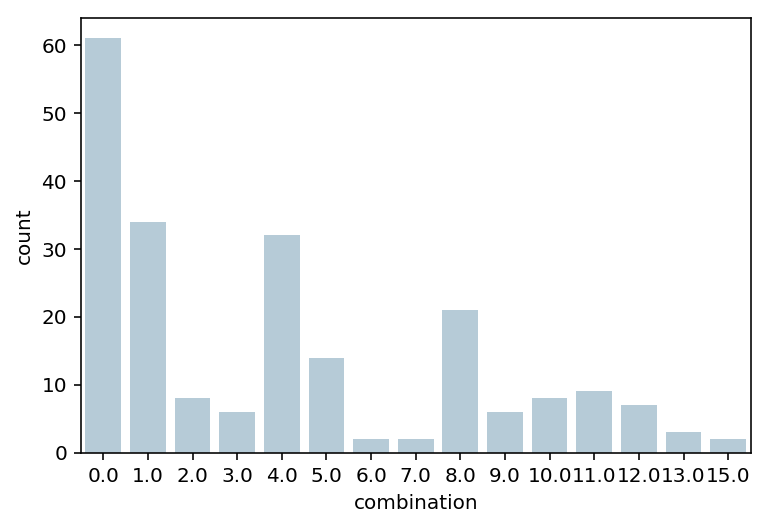

In [46]:
sns.countplot(x='combination', data=pa_implementation, color=COLOR_TREAT);

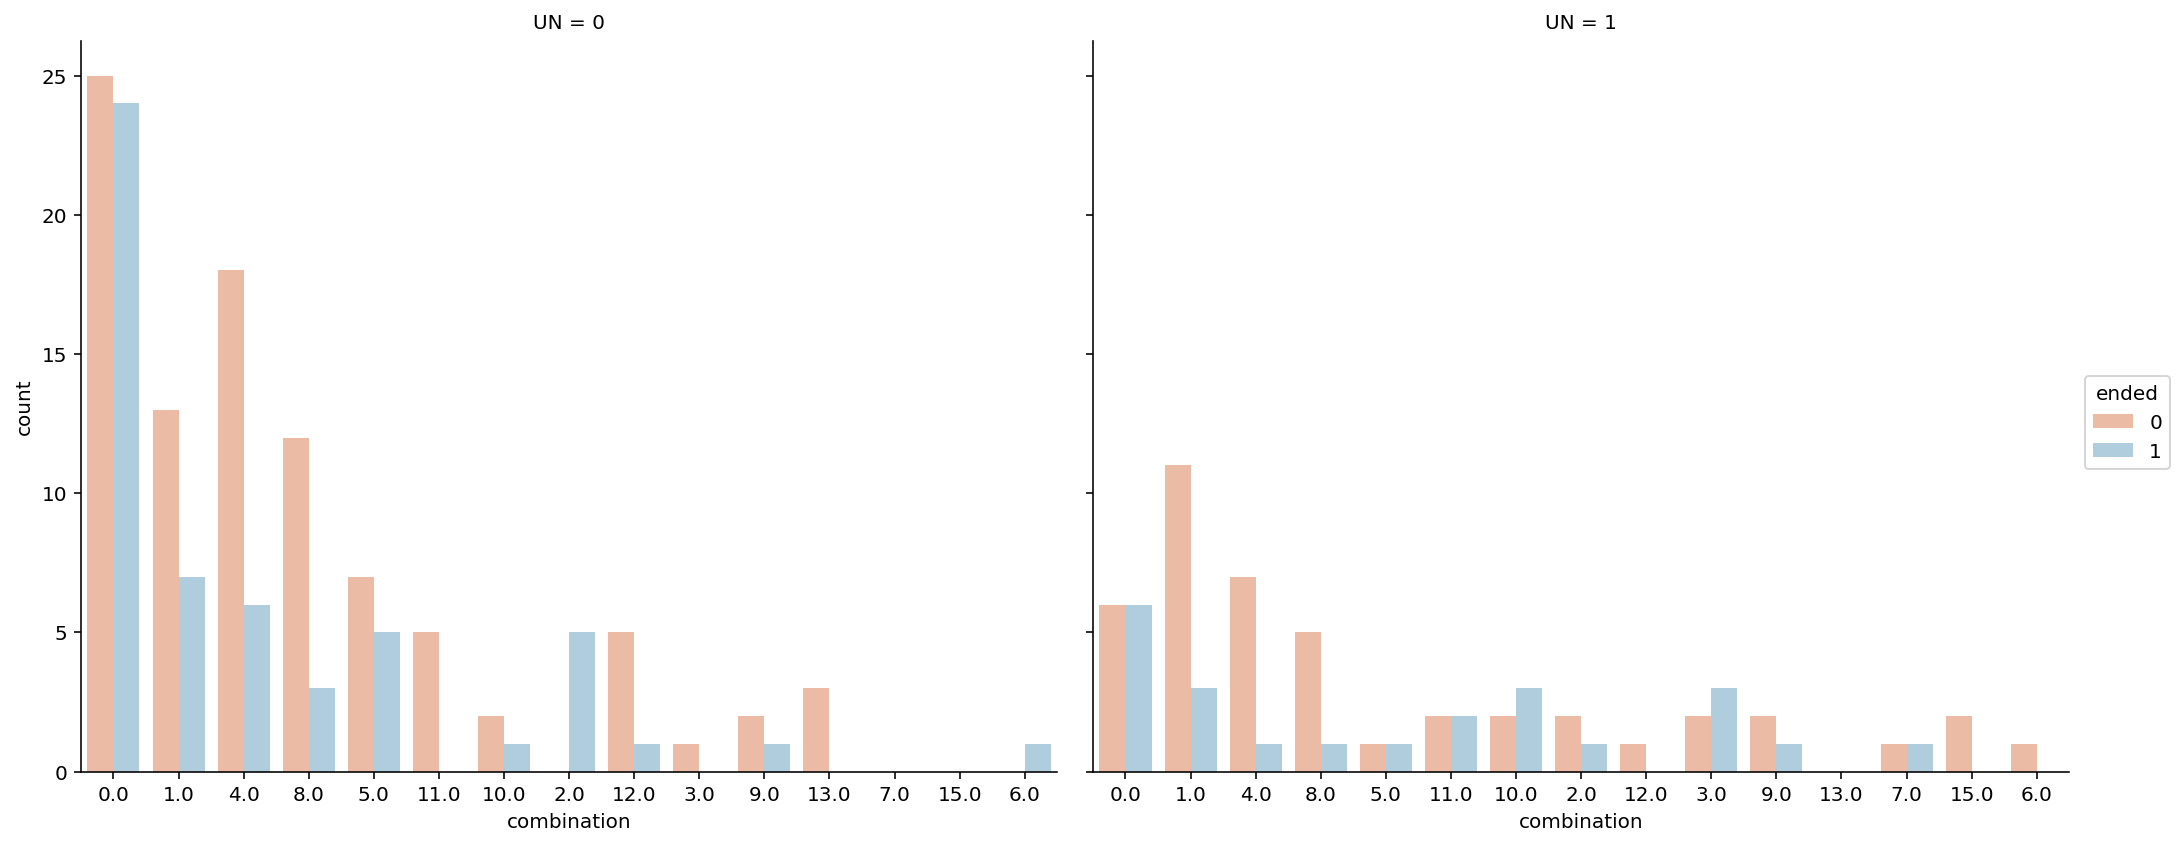

In [47]:
pa_implementation['UN'] = pa["UN"]
pa_implementation['ended'] = pa['ended']
sns.factorplot(x='combination', data=pa_implementation, hue='ended', col='UN', kind='count', size=6, aspect = 1.2,
              palette='RdBu', order=pa_implementation.combination.value_counts().index);

- The most recurring implementation is the one where the agreement did not reaffirm earlier agreements, did not outline a negotiating agenda including negotiations on the incompatibility, did not provide for the deployment of a peace-keeping operation and did not provide for the establishment of a commission or committee to oversee implementation of the agreement.

- The second most combination recurring only provided for the establishment of a commission or committee to oversee implementation of the agreement.

- The third most recurring combination outline a negotiating agenda including negotiations on the incompatibility

- Fourth : reaffirm earlier agreements and provided the establishment of a commission or committee to oversee implementation of the agreement.

A small diference between the agreements where the UN was involved and those where it wasn't are the ones where a provision for peace keeping operations is made. This is of course logical because the UN is the entity that generally decides for such missions.

## Temination variables
- **DyVi05** - Violence with the same parties restarted within 5 years

    - 1) Yes, the dyad violence restarted or continued
    - 0) No, the violence ended in this dyad
    - -99) Not applicable, agreement signed previous year


- **CoVi01** - Terminated the whole conflict the following year, signed an active year
    - 2) Part of a peace process which ended the violence.
    - 1) Yes, the conflict was terminated
    - 0) No, the conflict continued
    - -99) Not applicable, for example, the peace agreement was not signed in a conflict active year.


- **noconf** - Signed in a conflict inactive year.

The peace agreement was signed in an inactive conflict year i.e. in a year with less than 25 battle- related deaths recorded by the UCDP.
    - 1) Yes 
    - 0) No

- **termdur** - Number of years since last activity.

The number of inactive years between end of conflict and signature of the peace agreement.


- **Noconf11** - Still terminated as of 2011
    No active conflict years recorded from agreement until 2011 1) Yes, no active conflict years from agreement til 2011, 
    - 0) No, conflict restarted before 2011
    - -99) Not applicable, signed in 2011
    
The *termdur* will be used to relate agreement signed on active years to ones signed on inactive year. This should allow us to give more strentgh to an agreement that was signed fewer years after the end of the conflict than one signed a long time after. 

The *DyVi05* feature will be used as the second success evaluation variable. The *CoVi01* feature will be used to evaluate the time efficiency of the agreement.

# The Naive Analysis


First, let's just compute the proportions straight from our Peace Agreements database.
We observe that 34% of the agreements that included the UN ended, this proportion goes up to 36% for the agreements that did not include the UN. A chi square two-sample proportion test gives us a p-value of 0.82 so we don't reject the null hypothesis that these proportions are equal. This totally naive analysis can't give us a conclusion to our problematic, we can not say anything about the UN performances at this point.

p-value is high so we cannot reject the null hypothesis that the proportions are independent.

In [48]:
#let's reimport the data as we used it a lot in the previous analysis, we want it to be clean
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
endeddic = {0: 'Active' , 1: 'Broken'}
pa.ended.replace(endeddic , inplace= True)
pa.groupby(['UN' , 'ended']).count()['PAID']

UN  ended 
0   Active    94
    Broken    54
1   Active    45
    Broken    23
Name: PAID, dtype: int64

In [49]:
#Fisher exact test (see data story for more insights)
oddsratio, pvalue = stats.fisher_exact([[94, 45], [54, 23]])
pvalue

0.76089422709451249

array([<matplotlib.axes._subplots.AxesSubplot object at 0x120378c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x120154e80>], dtype=object)

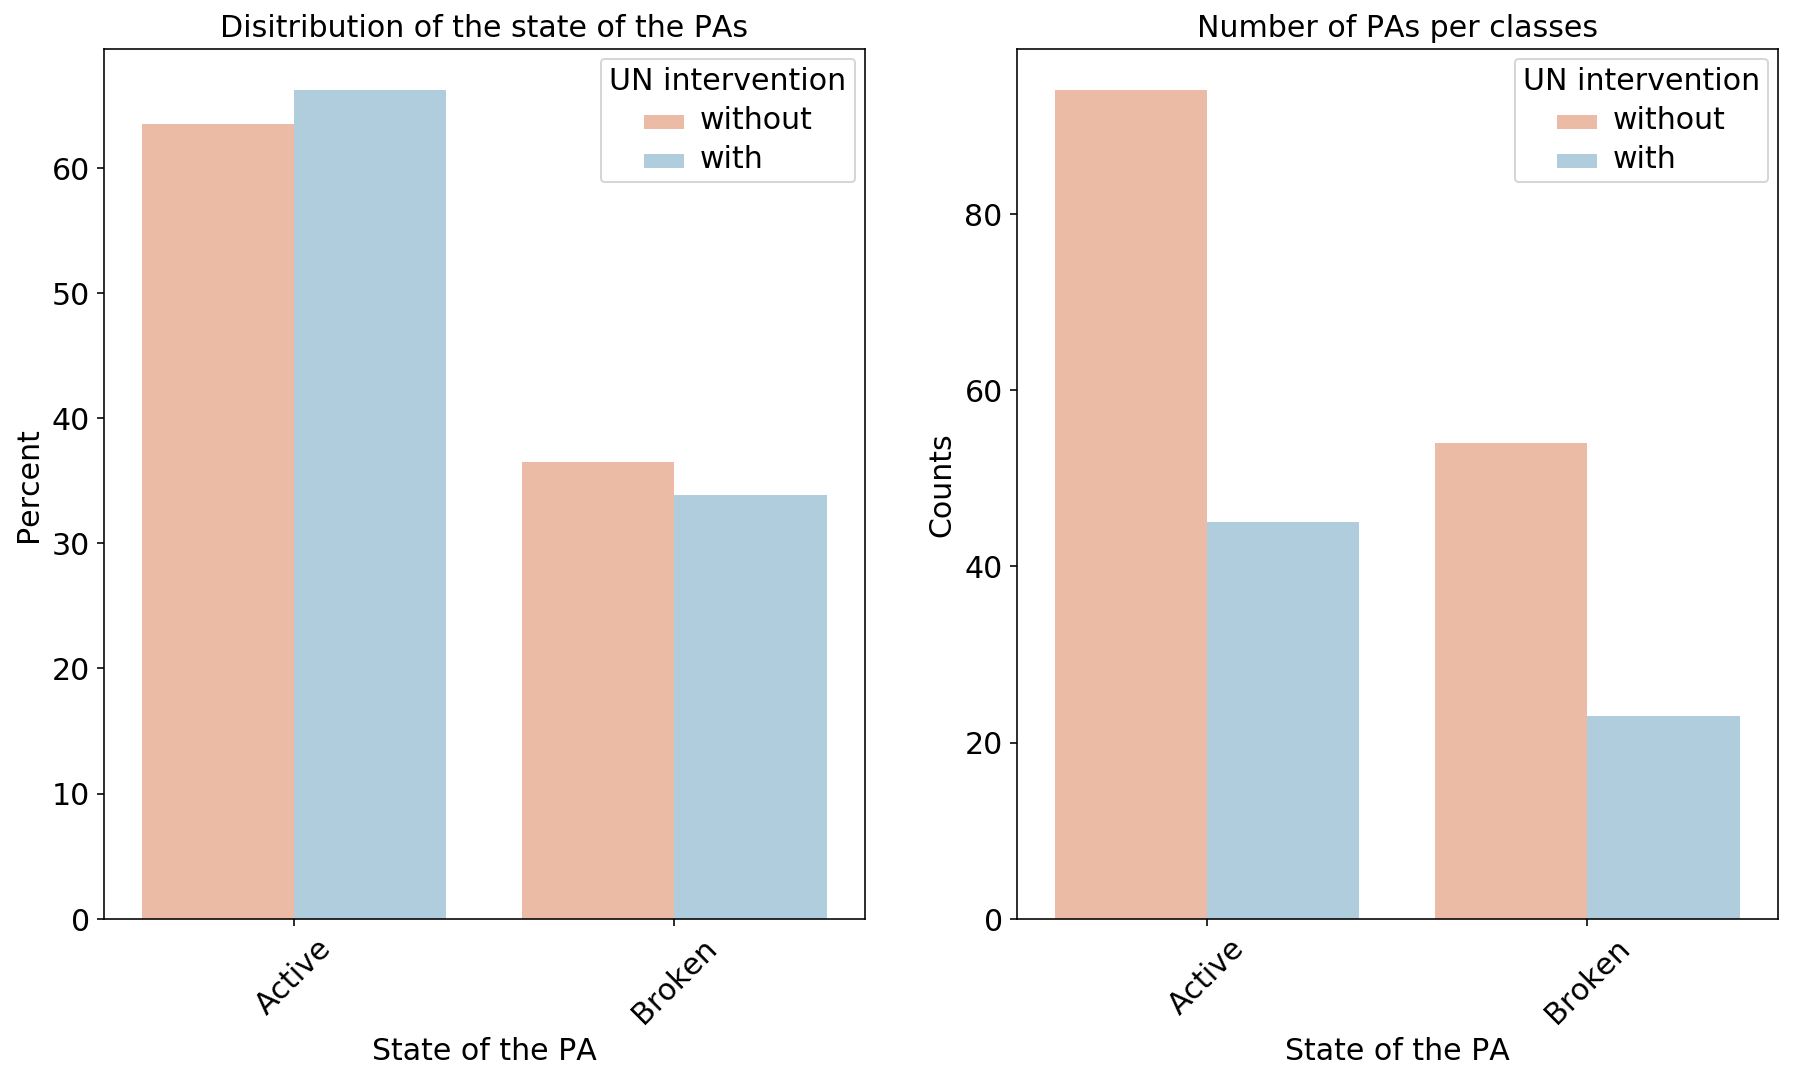

In [50]:
percent_categorical('ended', df=pa, grouper='UN' , 
                   order = ['Active' , 'Broken'] , title = ['Disitribution of the state of the PAs' , 'Number of PAs per classes'],
                   label = 'State of the PA',
                   legend = ['UN intervention' , 'without' , 'with'])

# Propensity score to have a less naive analysis

We perform a propensity score matching on the Peace agreements in order to match the UN peace agreements with similar peace agreements in order to have an analysis that is less naive.

In [51]:
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)

In [52]:
#Create a column for the pas that has the UN as a 3rd party
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]




to_be_categorical = ['termdur' , 'noconf11' , 'CoVi01' ,'DyVi05' ]
for categ in to_be_categorical:
    pa[categ] = pd.Categorical(pa[categ] , pa[categ].unique())
pa.groupby('UN').count()

,PAID,Region,GWNO,CID,Name,DyadName,actorId,Inc,pa_name,Year,...,Co_impl,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss
UN,,,,,,,,,,,,,,,,,,,,,
0,148,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
1,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68


In [53]:
pa.iloc[:, 14:-1].head()

,cease,Intarmy,DDR,Withd,Mil_prov,pp,Intgov,Intciv,Elections,Interrim,...,Co_impl,DyVi05,CoVi01,noconf,termdur,noconf11,inclusive,no_dyad,pa_type,Out_iss
0,0,0,0,0,0,0,0,0,0,0,...,0,1,-99,0,-99,0,2,1,3,4
1,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-99,1,1,1,1,0
2,1,0,0,0,1,0,0,0,0,0,...,1,0,1,0,-99,1,1,1,3,4
3,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,-99,0,1,1,2,4
4,0,0,1,0,1,0,0,0,0,0,...,1,0,1,0,-99,1,2,1,1,0


In [54]:
import sklearn.linear_model
import sklearn.preprocessing
#removing the useless features, the features are described in the previous part
pa_reg = pa.iloc[:, 14:-1]

#prepocess by standardizing the dataset
pa_reg = preprocessing.scale(pa_reg)
#Perform a logistic regression in order to get the propensity score for each individuals
model = sklearn.linear_model.LogisticRegression()
model.fit(pa_reg, pa.UN)
pred = model.predict_proba(pa_reg)

Here we check the performance of our model, we have an accuracy of 89% which is quite good for a very simple logistic regression.

In [55]:
#Check the performance of the model
sum(model.predict(pa_reg) == pa.UN)/len(pa_reg)

0.7777777777777778

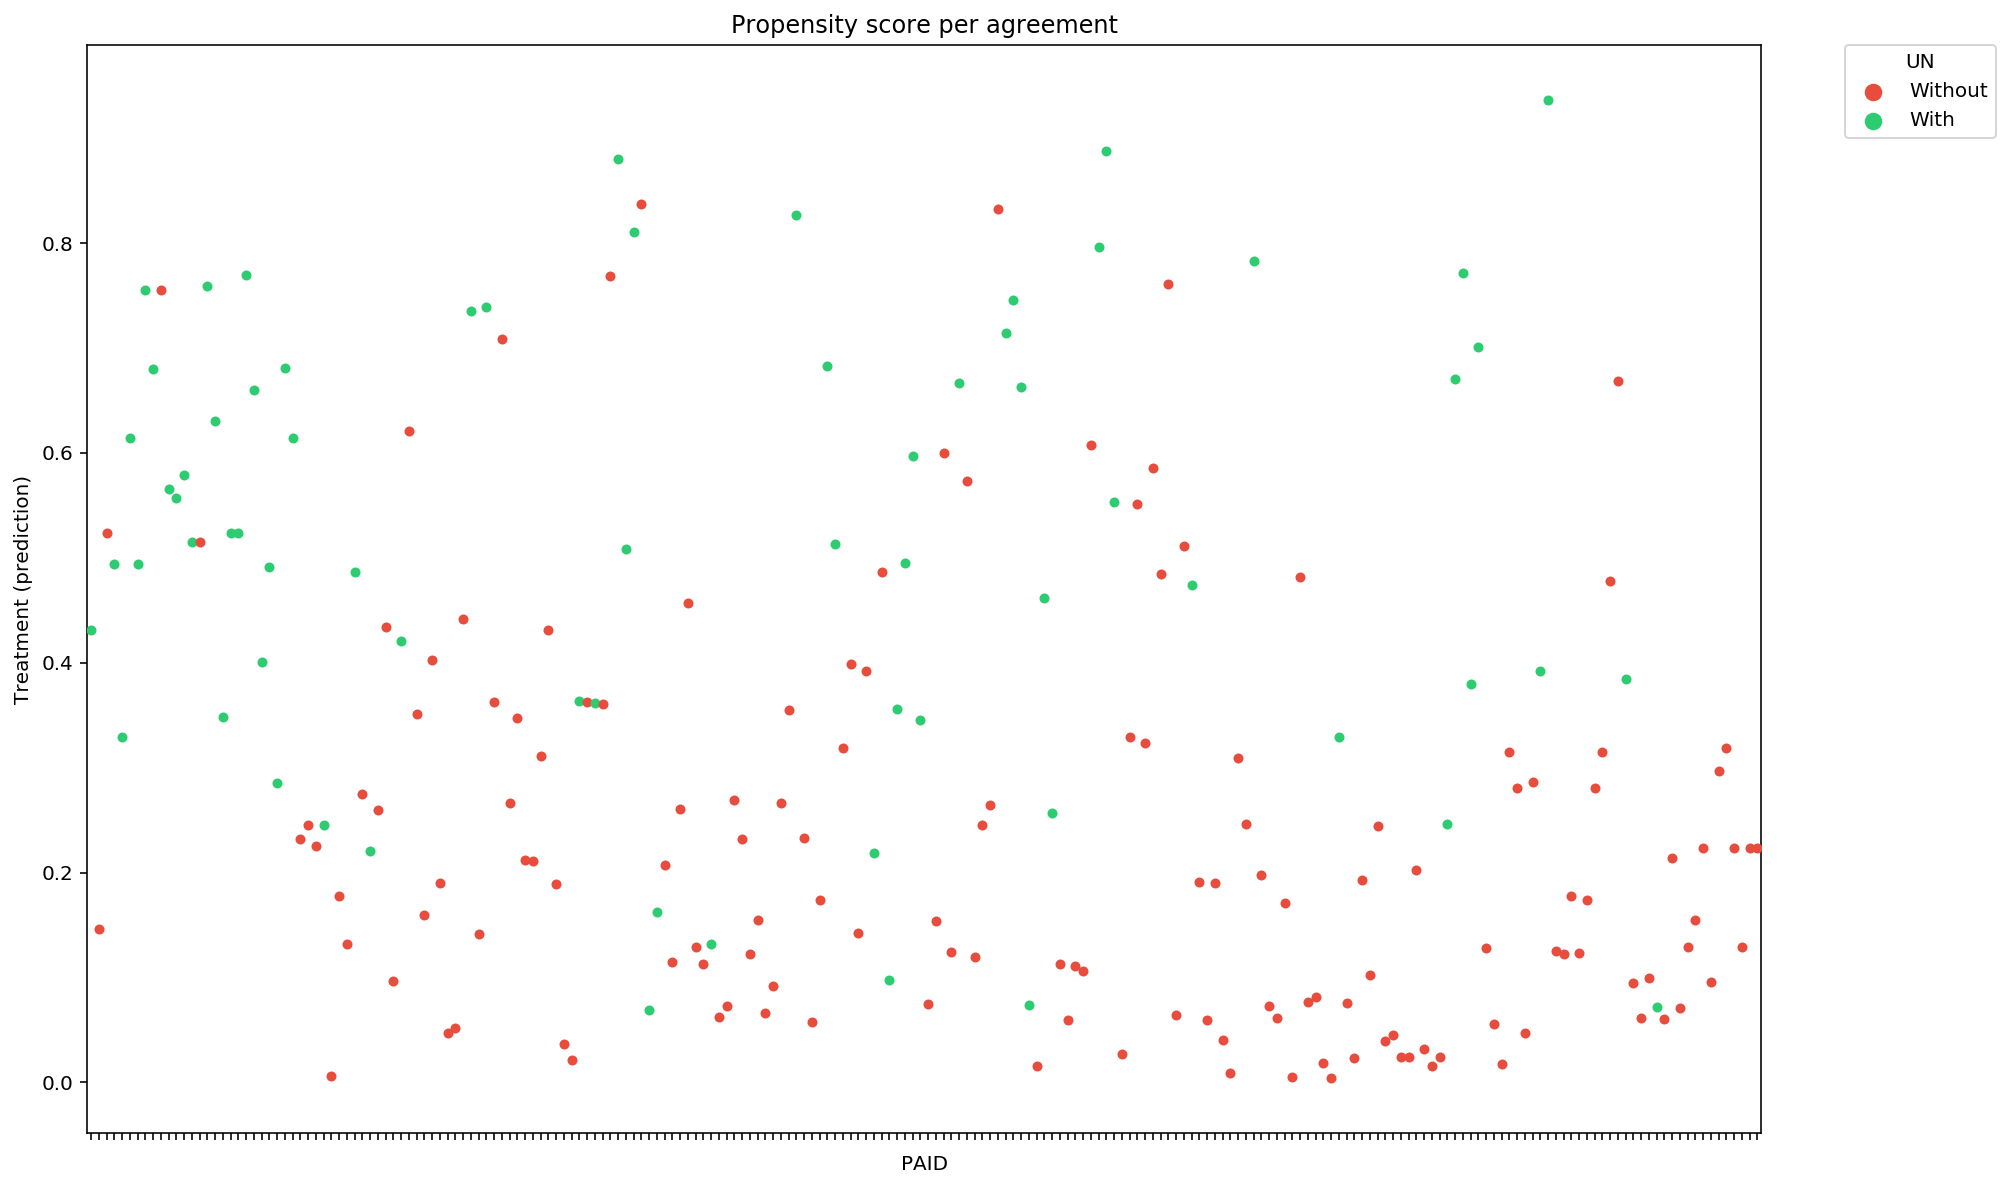

In [56]:
#Scatter plot of the propensity score
plt.figure(figsize=(15, 10))
pa['pred'] = pred[:,1]
ax = sns.stripplot(x='PAID', y='pred', hue='UN', data=pa, palette={0:"#e74c3c", 1: "#2ecc71"})
ax.set(xticklabels=[], ylabel='Treatment (prediction)')
plt.title('Propensity score per agreement')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=ax.get_legend_handles_labels()[0], labels=['Without', 'With'], title='UN')

This plot shows us what the propensity score for each PAID is. The UN PAID are in green and should have a score around 1 whereas the PAID without the UN are in red and should have a score around 0. Even if we have some outliers, this is what we observe on the plot.

In [57]:
#Check that every PAID has a pred value
pa.pred.isnull().values.any()

False

Here we do the matching.

We saw in class that matching among the propensity score is almost the same as matching among the features.

In order to do this matching, we will procede in the following way:


- First, we will create a complete bipartite graph. It means that the vertices are partitioned into two subsets V1 (the people who received the training) and V2 (the people who did not receive the traing) such that no edge has both endpoints in the same subset, and every possible edge that could connect vertices in different subsets is part of the graph. This way will will be sure to match UN PAID people with PAID without the UN

- We will give a weight to these edges: Let's take two PAID,we denote by $w_1$ the propensity score of the UN PAID and $w_2$ the propensity score of the other PAID (no UN). The weight of the edge between them will be:
$$W = - |w_{1} - w_{2}| $$

- Finally we will use a maximum weight matching with max cardinality algorithm. Note that we have a minus sign in our weights because we want to minimize the weights even though we are using a maximum weight matching algorithm. We are using the method implemented in the NetworkX package. This method is based on the “blossom” method for finding augmenting paths and the “primal-dual” method for finding a matching of maximum weight, you can read more about it there : https://dl.acm.org/citation.cfm?id=6502 .

In [58]:
import networkx as nx
from networkx.algorithms import bipartite

#create the nodes
G=nx.Graph()
G.add_nodes_from(pa['PAID'][pa.UN == 0])
G.add_nodes_from(pa['PAID'][pa.UN == 1])

In [59]:
#Bipartite complete graph
for ID_u, score_u in zip(pa.PAID[pa.UN == 0], pa.pred[pa.UN == 0]):
    for ID_v, score_v in zip(pa.PAID[pa.UN == 1], pa.pred[pa.UN == 1]):
        G.add_edge(ID_u, ID_v, weight=-abs(score_u-score_v))

In [60]:
#Let's check if the number of nodes and edges is right
#Number of nodes should be 148+68 = 216 (the graph is bipartite) and number of edges should be 148*68 = 10 064
#because it is complete bipartite
print(G.number_of_nodes())
print(G.number_of_edges())

216
10064


In [61]:
#perform the matching
from networkx.algorithms import max_weight_matching
matching = max_weight_matching(G, maxcardinality=True)

In [62]:
#We have 68 PAIDs that need to be matched, here we notice the dictionnary goes in both ways so 136 entries
len(list(matching.items()))

136

In [63]:
pa_UN = pa[pa['UN'] == 1]
pa_UN['temp'] = 1
pa_UN = pa_UN[['PAID' , 'pred' , 'temp']]
pa_nUN = pa[pa['UN'] == 0]
pa_nUN['temp'] = 1
pa_nUN = pa_nUN[['PAID' , 'pred' , 'temp']]


#We merge the two datasets thanks to the temp column, this new merged dataset mimics the complete bipartite graph:
result = pd.merge(pa_nUN ,pa_UN , on='temp', how='left')
result = result[['PAID_x' , 'PAID_y' , 'pred_x' , 'pred_y']]
result['diff'] = abs(result['pred_x'] - result['pred_y'])
result = result.set_index(['PAID_x', 'PAID_y'])
result['diff'].isnull().values.any()
#result
print(result.loc[list(matching.items())].dropna().shape)
result.loc[list(matching.items())].dropna().head()

(68, 3)


,,pred_x,pred_y,diff
PAID_x,PAID_y,,,
1001999050601,5171993080401,0.245135,0.745630,0.500496
901990033001,921990052101,0.524020,0.524020,0.000000
901994062301,901996121201,0.755594,0.759140,0.003546
901996120701,921990040401,0.514976,0.524020,0.009044
3432001081301,4831994081001,0.131578,0.131472,0.000106


array([<matplotlib.axes._subplots.AxesSubplot object at 0x120a9fb38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1203ff6d8>], dtype=object)

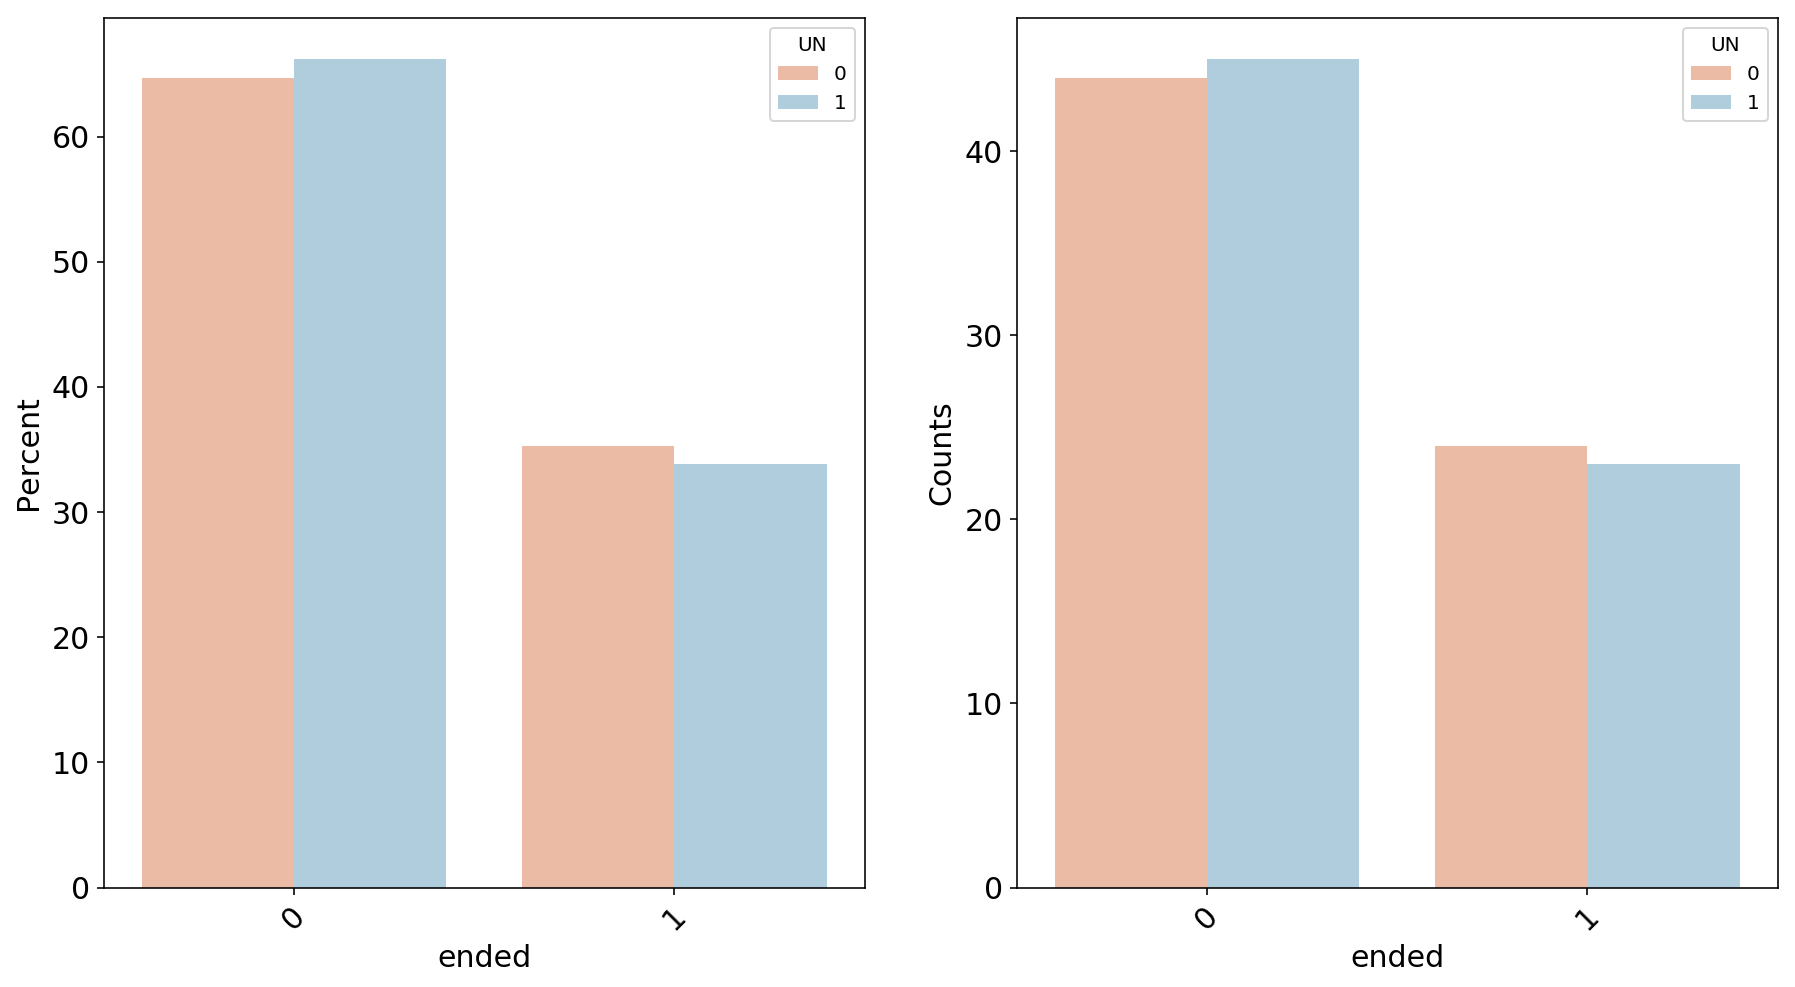

In [64]:
paID = pa.set_index('PAID')
matched = paID.loc[list(matching.keys())]
plt.figure(figsize=(20,10))
percent_categorical('ended', df=matched, grouper='UN' , order = [0,1])

The UN agreements are more 'ended' (so the conflicts start again) than the one without the UN intervention.
But note that this analysis is still biased! 
Indeed, we only looked at the peace agreements here, we also need to look at the conflicts from these peace agreements. Maybe the UN only solved very difficult conflicts.

It is important to remember that we matched the PAs according to the caracteristics of the peace agreements, not the caracteristics of the conflicts. This means our analysis is still biased as we saw in the first part of this story that the UN solved conflicts that were more deadly and governmental than the other 3rd parties.

In a second part we will look at the conflict that were solved and do another matching among them so we can redo this analysis with a filter on the conflict.

# Conflicts

## Cleaning the data

As we studied in the previous part, we will need to balance our study over the conflict that has be solved by the UN vs the others.

Indeed, the previous dataset only gave us informations about the peace agreement per se, we did not have any information about the conflict itself.

UCDP has another data set that describes the conflicts. It is named *ucdp-prio-acd*.

It is a conflict-year dataset with information on armed conflict where at least one party is the government of a state in the time period 1946-2016.

The Conflict IDs are not the same between *ucdp-peace-agreements* and *ucdp-prio-acd* because UCDP changed the way the give IDs. The dataset *ucdp-peace-agreements* uses the old ID notation while *ucdp-prio-acd* uses the new one . Therefore, we need the translation give bt UCDP, *translate_conf*, to link them.

In [65]:
#For nb of deaths
precisedf = pd.read_csv('data/ged171.csv')

#Import the Peace Agreement dataset and the translation table to get the new IDs
#We reimport so we don't have to run the whole notebook again and again
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
pa[pa['UN'] == 1]

reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
#Now let's change the IDs so they match
pa.CID = pa.CID.astype(str)
pa.CID = pa.CID.apply(lambda x: d[x])
pa.CID = pa.CID.astype(dtype = int)

In [66]:
#Import the conflict dataset
df = pd.read_csv('data/ucdp-prio-acd-171.csv')

In [67]:
#Let's observe the data
df.iloc[:10, :11]

,conflictid,location,sidea,sidea2nd,side b,sidebid,sideb2nd,incomp,terr,year,intensity
0,200,Bolivia,Government of Bolivia,NaN,Popular Revolutionary Movement,719,NaN,2,NaN,1946,2
1,200,Bolivia,Government of Bolivia,NaN,MNR,720,NaN,2,NaN,1952,1
2,200,Bolivia,Government of Bolivia,NaN,ELN,721,NaN,2,NaN,1967,1
3,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1946,1
4,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1947,1
5,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1948,1
6,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1949,1
7,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1950,1
8,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1951,1
9,201,Cambodia (Kampuchea),Government of France,NaN,Khmer Issarak,160,NaN,1,Cambodia,1952,1


In [68]:
#Lot's of features so we do that in two times
df.iloc[:10, 11:27]

,cumint,type,startdate,startprec,startdate2,startprec2,epend,ependdate,ependprec,gwnoa,gwnoa2nd,gwnob,gwnob2nd,gwnoloc,region,version
0,1,3,1946-07-18,1,1946-07-21,2,1,1946-07-21,1.0,145,NaN,NaN,NaN,145,5,17.1
1,1,3,1946-07-18,1,1952-04-09,1,1,1952-04-12,1.0,145,NaN,NaN,NaN,145,5,17.1
2,1,3,1946-07-18,1,1967-03-31,3,1,1967-10-16,1.0,145,NaN,NaN,NaN,145,5,17.1
3,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
4,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
5,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
6,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
7,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
8,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1
9,0,1,1946-08-31,3,1946-08-31,3,0,NaN,NaN,220,NaN,NaN,NaN,811,3,17.1


As we notice, there is several rows for the same conflict ID. Indeed, Each conflict is listed in the database and given a unique ID code. The temporal aspect of a conflict is not addressed by this definition; hence, two conflict episodes over the same incompatibility will be assigned the same ID regardless of the time separating them.

This is how UCDP records the data, as explained on their website:

- The observation (or unit) in the table is the conflict-year. Each conflict is listed in all years where fighting in one or more dyad(s) caused at least 25 battle-related deaths. The calendar year is the basic unit of every observation. Thus, if a conflict during the period June–September results in 30 casualties, that year will be recorded as a year of conflict. However, if the same number of casualties occurred in the period November–February and the conflict failed to reach the threshold of 25 battle-related deaths in either calendar year, neither year will be coded as in conflict. Start dates frequently refer to years prior to the first calendar year of a conflict, as the start of a conflict might be in a year with less than 25 fatalities. Small conflicts might not be included.

Taking this into account, we decide to refine this dataset in order to have a single conflict ID per row. In order to do that we will aggregate the dataset at the CID (Conflict ID) level. To do so we will drop some variables that only concern the years of observation and not the conflict in its totality. This variables are :

- `year` : The year of observation, which is not needed anymore as we will observe the conflict in its totality

- `intensity` : The intensity of the conflict in a given year.

- `startdate2` : The starting date of the observation (for a given year then, not the conflict itself).

- `startprec2` : The precision of the `startdate2` variable.

- `epend` : The ending date of the observation (same as above).

- `ependprec` : The precision of the `epend` variable.

These are the variables we droppend because we aggregate the dataset. We will drop some other variables because they are not needed in our analysis :

- `sidea2nd` : If there is a secondary actor in the conflict on side A, we don't think we need that much precision.

- `sideb2nd` : If there is a secondary actor in the conflict on side B, we don't think we need that much precision.

- `terr` : The disputed territory if there is any. We don't need that much precision for a propensity score.

- `startprec` : The precision of the starting date for the conflict. This is useless for our propensity score.

- `gwnoa`, `gwnoa2nd`, `gwnob`, `gwnob2nd`, `gwnoloc` : This is only country codes etc, we don't need that for a propensity score.

- `version` : The version of the dataset.

We will describe the variables we keep in the next markdown, after we show the clean data set.

In [69]:
#Let's remove the features we don't need for our analysis
df.drop(['sidea2nd', 'sideb2nd' , 'terr' , 'year' , 'intensity' , 'startprec' , 'startdate2' , 'epend' , 'ependprec', 'gwnoa', 'gwnoa2nd', 'gwnob', 'gwnob2nd', 'gwnoloc', 'startprec2', 'version', 'sidebid'], axis=1, inplace = True)

In [70]:
#Check how many conflicts we have
print('Number of unique conflicts in this dataset : %s' %(len(df.conflictid.unique())))

Number of unique conflicts in this dataset : 280


In [71]:
print("Number of non-unique locations for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['location'].unique().apply(len) > 1)]))
print("Number of non-unique 'side a' for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['sidea'].unique().apply(len) > 1)]))
print("Number of non-unique 'side b' for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['side b'].unique().apply(len) > 1)]))
print("Number of non-unique incomp for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['incomp'].unique().apply(len) > 1)]))
print("Number of non-unique cumint for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['cumint'].unique().apply(len) > 1)]))
print("Number of non-unique types for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['type'].unique().apply(len) > 1)]))
print("Number of non-unique startdates for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['startdate'].unique().apply(len) > 1)]))
print("Number of non-unique regions for a single conflict: %d" %len(df['conflictid'].unique()[(df.groupby(df['conflictid'])['region'].unique().apply(len) > 1)]))

Number of non-unique locations for a single conflict: 0
Number of non-unique 'side a' for a single conflict: 0
Number of non-unique 'side b' for a single conflict: 84
Number of non-unique incomp for a single conflict: 0
Number of non-unique cumint for a single conflict: 76
Number of non-unique types for a single conflict: 49
Number of non-unique startdates for a single conflict: 0
Number of non-unique regions for a single conflict: 0


In [72]:
#Let's aggregate the data to single CIDs (explanations in the markdown below)
clean_df = df.groupby('conflictid').last()
clean_df.head()

,location,sidea,side b,incomp,cumint,type,startdate,ependdate,region
conflictid,,,,,,,,,
200,Bolivia,Government of Bolivia,ELN,2,1,3,1946-07-18,1967-10-16,5
201,Cambodia (Kampuchea),Government of France,Khmer Issarak,1,0,1,1946-08-31,1953-11-09,3
202,China,Government of China,PLA,2,1,3,1946-12-31,1949-12-08,3
203,Greece,Government of Greece,DSE,2,1,3,1946-03-31,1949-10-16,1
204,Indonesia,Government of Netherlands,Indonesian People's Army,1,0,1,1945-10-13,1949-08-15,3


Here we will explain the variables we retained and how we aggregated them:

- `location` : The location of the conflict, this is always the same for each conflict ID, therefore we just take the value of the last observation for the aggregated dataset.

- `sidea` : The first agent in the conflict (it has to be a government), this is always the same for each conflict ID, therefore we just take the value of the last observation for the aggregated dataset.

- `side b` : The seconf agent in the conflict (it can be a government or an organisation), this is not always the same but after organisation we noticed that it was due to the organisation often changing name. Therefore we use the name of the organisation in the last observation for the aggregated dataset.

- `incomp` : The incompatibility that led to the conflict. this is always the same for each CID, therefore we simply take the value of the last observation. Here are the three possible values :
    - 1 : Territory
    - 2 : Government
    - 3 : Both
    
- `cumint` : It is a variable that says if the conflict did more than 1000 battle related deaths since its begining. Of course it is not the same accross the same CID because it is a cumulative variable, therefore we take the value for the last observation.

- `Type` : The type of conflict. The type can change for the same CID. Though, we think that the most important is what the conflict was at its end (we have the `incomp` variable to tell us how the conflict began). Therefore, we take the last value for the aggregated dataset. There are four types of conflicts :
    - 1 : Extrasystemic armed conflict occurs between a state and a non-state group outside its own territory.
    - 2 : Interstate armed conflict occurs between two or more states. 
    - 3 : Internal armed conflict occurs between the government of a state and one or more internal opposition group(s) without intervention from other states.
    - 4 : Internationalized internal armed conflict occurs between the government of a state and one or more internal opposition group(s) with intervention from other states (secondary parties) on one or both sides.
    
- `startdate` : The date of the start of the conflict, it is the same across all raws for the same CID so we can take whatever line when we aggregate.

- `ependdate` : The end date of the episode observed. If this is the last episode it is the date of the end of the conflict for the CID. We take the date of the last observation when we aggregate then.

- `region` : The region of the conflict, it is always the same across the same CID. Then we take the one for the last observation. The 5 regions are : 
    - 1 : Europe
    - 2 : Middle East
    - 3 : Asia
    - 4 : Africa
    - 5 : America
    
    
Now we will use the other dataset in order to know if there was a Peace Agreement for this conflict. We will add a 0/1 column to capture this information.

In [73]:
#Check the CIDs that were ended by a peace agreement
agreements = pa.groupby('CID').last()
print('Number of unique conflicts that had a peace agreement : %s' %(len(agreements.index)))

Number of unique conflicts that had a peace agreement : 60


In [74]:
#Check the CIDs that were ended by a UN peace agreement
UN_agreements = pa[pa['UN']==1].groupby('CID').last()
Other_agreements = pa[pa['UN']==0].groupby('CID').last()
print('Number of unique conflicts that had a UN peace agreement : %s' %(len(UN_agreements.index)))
print('Number of unique conflicts that had a peace agreement that did not involve the UN: %s' %(len(Other_agreements.index)))
#print(agreements.index)

Number of unique conflicts that had a UN peace agreement : 27
Number of unique conflicts that had a peace agreement that did not involve the UN: 50


In [75]:
#We add a column so we know if the CID had a peace agreement (1) or not (0)
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df["UN_agreement"] = [1 if ele in UN_agreements.index else 0 for ele in clean_df.index]
clean_df["Other_agreement"] = [1 if ele in Other_agreements.index else 0 for ele in clean_df.index]
clean_df.rename({'ependdate':'enddate'} , inplace = True, axis = 1)

In [76]:
#Date time so we can substract and have the duration
clean_df['startdate'] = pd.to_datetime(clean_df['startdate'])
clean_df['enddate'] = pd.to_datetime(clean_df['enddate'])
clean_df['duration'] = (clean_df['enddate'] - clean_df['startdate']).dt.days


#Categorical


  
#Making the categories nicer
regiondic = {'1':'Europe' , '2': 'Middle East', '3': 'Asia' , '4': 'Africa' , '5':'Americas' , '1, 3' : 'Asia',
            '1, 2' : 'Middle East' , '1, 4':'Africa' ,'1, 5': 'Americas','1, 2, 3, 5' :'Middle East' , '1, 3, 5' : 'Middle East'}
typedic = {1 : 'Extrasystemic' , 2 : 'Interstate' , 3 : 'Internal' , 4: 'Internationalized'}
incompdic = {1 : 'Territory' , 2: 'Government' , 3: 'Government and Territory'}
cumintdic = {0: 'Less than 1000 deaths' , 1: 'More than 1000 deaths'}
clean_df.region.replace(regiondic , inplace= True)
clean_df.type.replace(typedic , inplace= True)
clean_df.incomp.replace(incompdic , inplace = True)
clean_df.cumint.replace(cumintdic , inplace = True)


to_be_categorical = ['incomp' , 'cumint' , 'type' ,'region' , 'agreement' , 'UN_agreement' , 'Other_agreement']
for categ in to_be_categorical:
    clean_df[categ] = pd.Categorical(clean_df[categ] , clean_df[categ].unique())

In [77]:
#We now have a clean dataset
clean_df.head(10)

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration
conflictid,,,,,,,,,,,,,
200,Bolivia,Government of Bolivia,ELN,Government,More than 1000 deaths,Internal,1946-07-18,1967-10-16,Americas,0,0,0,7760.0
201,Cambodia (Kampuchea),Government of France,Khmer Issarak,Territory,Less than 1000 deaths,Extrasystemic,1946-08-31,1953-11-09,Asia,0,0,0,2627.0
202,China,Government of China,PLA,Government,More than 1000 deaths,Internal,1946-12-31,1949-12-08,Asia,0,0,0,1073.0
203,Greece,Government of Greece,DSE,Government,More than 1000 deaths,Internal,1946-03-31,1949-10-16,Europe,0,0,0,1295.0
204,Indonesia,Government of Netherlands,Indonesian People's Army,Territory,Less than 1000 deaths,Extrasystemic,1945-10-13,1949-08-15,Asia,0,0,0,1402.0
205,Iran,Government of Iran,KDPI,Territory,More than 1000 deaths,Internal,1946-05-31,1996-07-28,Middle East,0,0,0,18321.0
206,Iran,Government of Iran,Republic of Azerbaijan,Territory,Less than 1000 deaths,Internationalized,1945-11-19,1946-12-16,Middle East,0,0,0,392.0
207,Israel,Government of United Kingdom,IZL [Etzel],Territory,Less than 1000 deaths,Extrasystemic,1939-03-31,1946-12-31,Middle East,0,0,0,2832.0
208,Laos,Government of France,Lao Issara,Territory,More than 1000 deaths,Extrasystemic,1946-03-31,1953-12-31,Asia,0,0,0,2832.0


In [78]:
clean_df.tail(10)

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration
conflictid,,,,,,,,,,,,,
13648,Egypt,Government of Egypt,IS,Territory,More than 1000 deaths,Internal,2014-11-16,2016-12-06,Middle East,0,0,0,751.0
13653,India,Government of India,UNLFW,Territory,Less than 1000 deaths,Internal,2015-04-19,2016-12-31,Asia,0,0,0,622.0
13675,Lebanon,Government of Lebanon,IS,Territory,Less than 1000 deaths,Internal,2014-06-25,2015-12-15,Middle East,0,0,0,538.0
13692,"Afghanistan, United Kingdom, United States of ...",Government of Afghanistan,"Government of United Kingdom, Government of Un...",Government,More than 1000 deaths,Interstate,2001-10-07,2001-11-13,Middle East,0,0,0,37.0
13694,Libya,Government of Libya,IS,Territory,More than 1000 deaths,Internationalized,2015-03-14,2016-12-07,Africa,0,0,0,634.0
13721,Algeria,Government of Algeria,Jund al-Khilafah,Territory,Less than 1000 deaths,Internal,2015-04-05,2015-05-20,Africa,0,0,0,45.0
13809,Syria,Government of Syria,SDF,Government and Territory,Less than 1000 deaths,Internal,2015-12-06,2016-11-28,Middle East,0,0,0,358.0
13886,Jordan,Government of Jordan,IS,Territory,Less than 1000 deaths,Internal,2016-03-02,2016-12-29,Middle East,0,0,0,302.0
13902,Turkey,Government of Turkey,IS,Territory,More than 1000 deaths,Internal,2015-07-23,NaT,Middle East,0,0,0,NaN


In [79]:
#Check that we have all the CIDs for peace agreement
print(len(clean_df[clean_df['UN_agreement'] == 1].index))
print(len(clean_df[clean_df['agreement'] == 1].index))

27
60


## Data exploration

In this section, we will observe the distributions for the conflict over the `agreement` variable as we will want to have a propensity score matching for the conflicts that did or did not receive a peace agreement. (And later for conflicts that did or did not receive a peace aggreement from the UN).

We don't have any problems of missing values in this dataset, the only that we encounterd are for `enddate` and it simply means that the conflict is ongoing.

The correlations we are interrested in are the ones of the different features with the `agreement` variable. These will be checked when we will plot the distributions.

In [80]:
#A function to have nice plots
def plot_distrib(s1, s2, title, xLabel, yLabel, ax=None):
    bins = np.histogram(s1)[1]
    sns.distplot(s1, kde=False, color=COLOR_NO_TREAT, norm_hist=True, ax=ax, bins=bins)
    sns.distplot(s2, kde=False, color=COLOR_TREAT, norm_hist=True, ax=ax, bins=bins)
    if ax is None:
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.legend(['No agreement', 'Agreement'])

## `Start_Year` distribution
When we observe the graph that displays the number of conflicts per year, we observe several peaks. The peaks are in 1946 (this corresponds to the first Indochina war), 1948 (which corresponds to the first Arab-Israeli war and the conflict for the independence of Burma). The last peak we notice is in 2015 and it corresponds to the beginning of several conflicts against IS.
When looking at the number of conflicts that received at least one peace agreement, we notice that most of them began between the 1960s and the 1990s.

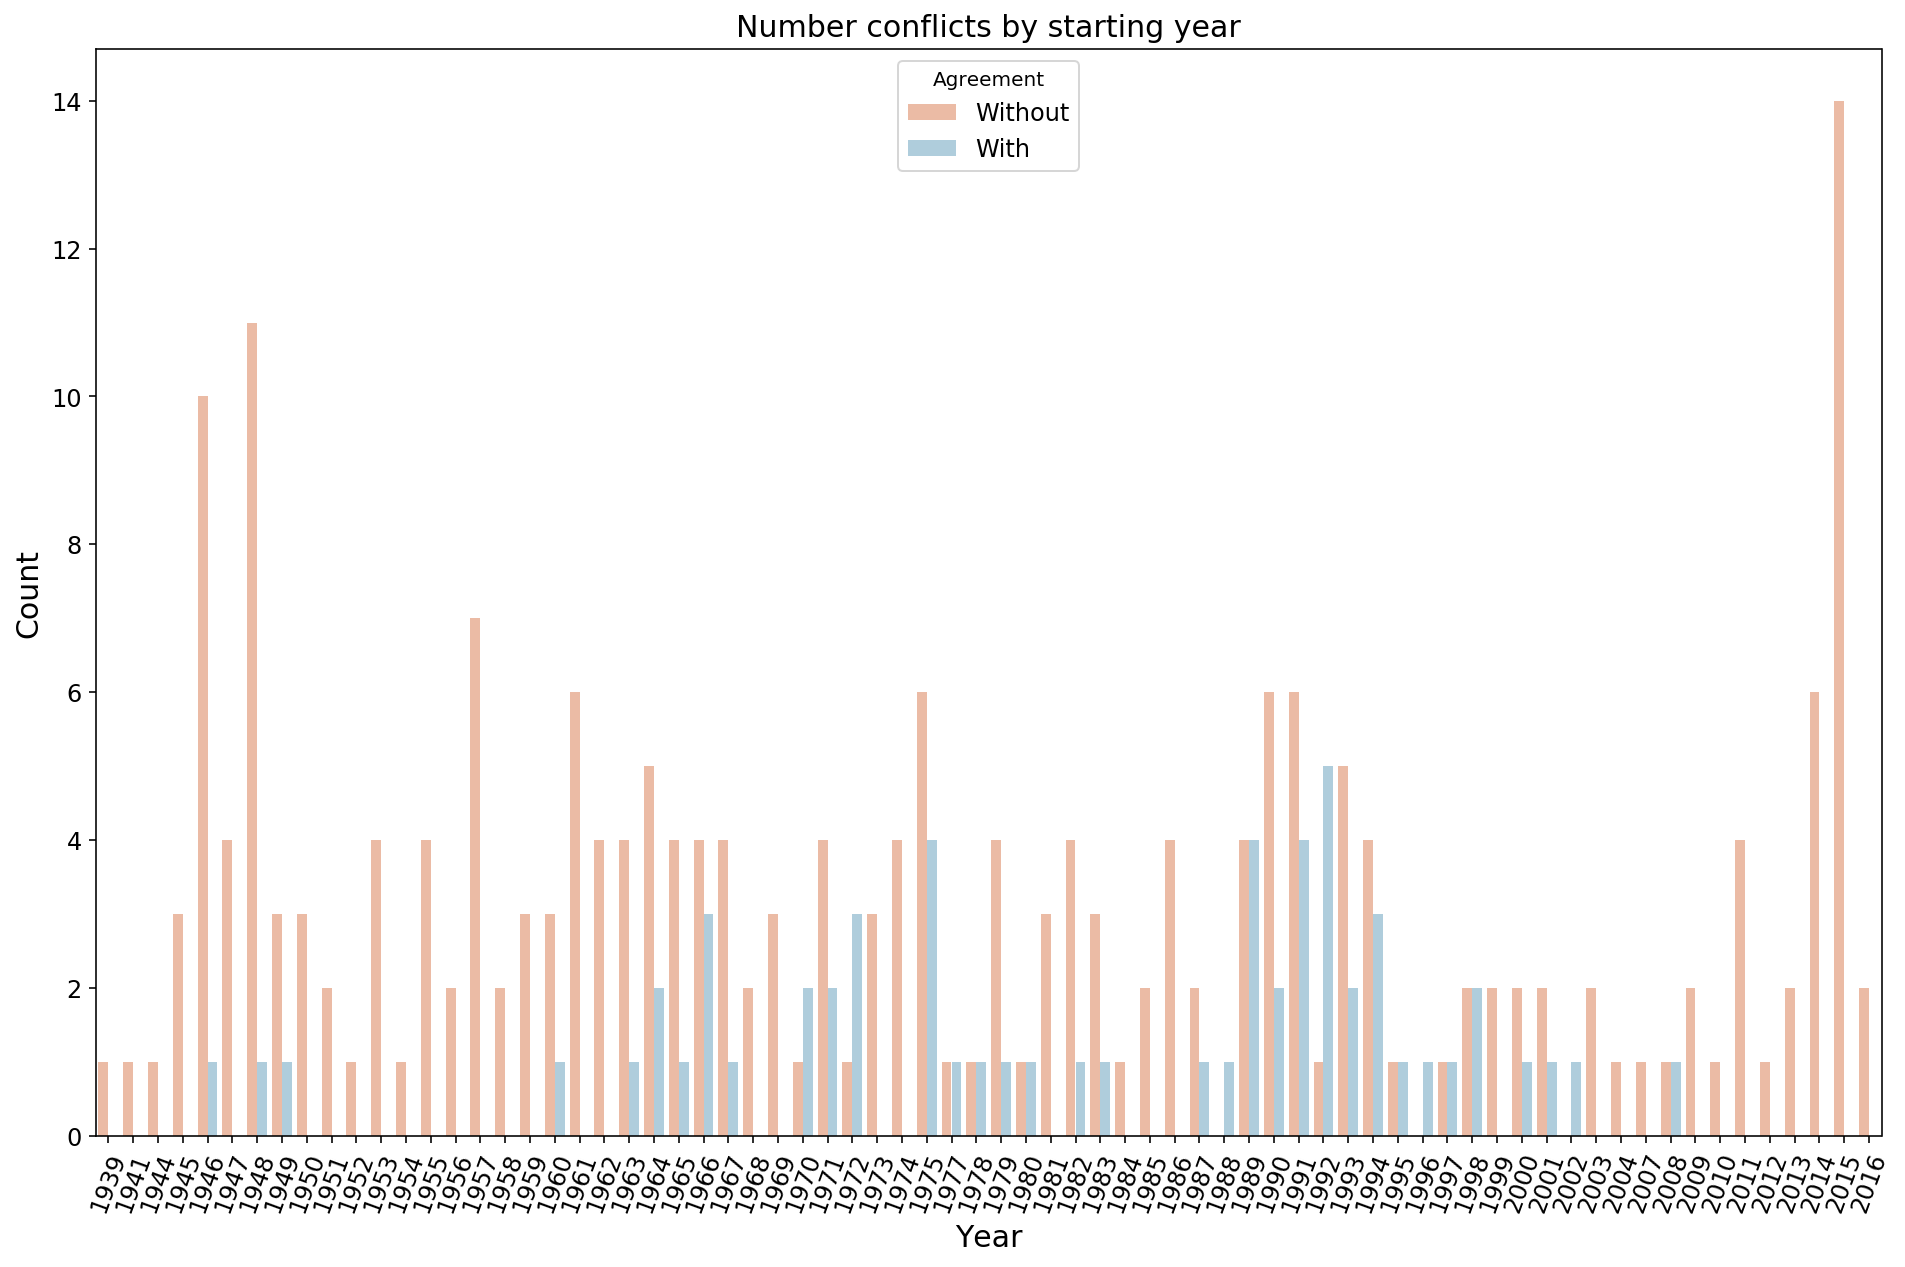

In [81]:
clean_df['Year'] = pd.DatetimeIndex(clean_df['startdate']).year
plt.figure(figsize=(16,10))
sns.countplot(x='Year', data=clean_df, hue='agreement' , palette = 'RdBu')
plt.title('Number conflicts by starting year' , size =15)
plt.xlabel('Year' ,size = 15)
plt.ylabel('Count' , size =15)
plt.xticks(rotation=70 , size = 12)
plt.yticks(size = 12)
plt.legend( ['Without' , 'With'] ,fontsize = 'large' , title = 'Agreement' , )
plt.savefig('frontend/img/images/conflict_year.png', transparent=True , bbox_inches = 'tight')

# `Region` distribution

### With respect to the PA

We divided the world in 5 region, and included the Oceania continent in the Asia region. When analysing the distribution, we observe that more than 50% of the conflicts happened in Africa or in Europe. Another interesting fact is that less than 10% of the conflicts were situated in the Middle East, although it is known to be a region with a lot of tensions.

Although, when observing this new graph, we notice that the average length of a conflict in the Middle East is very high. Indeed, in average, a conflict lasts more than 5000 days in this region, this way higher than the regions where plenty of conflicts happened, i.e Europe and Africa.

More than 50% of the conflicts that benefited from a peace agreement are in Africa
From now we will observe how the conflicts that did or did not have a peace agreement were distributed according to several features. We begin with the distribution across the regions.

We observe that the conflicts that did or did not receive a peace agreement are not equally distributed across the regions. A large proportion of conflicts that took part in Europe or in Africa benefited from a or several peace agreements whereas there is almost no peace agreements in the Middle East or in Asia. Indeed, looking at the distribution, more than 50% of the conflicts that received at least one peace agreement are located in Africa. less than 30% of the conflicts that did not benefit from a peace agreement were in Africa.

If we look at the percentage of conflicts that received a PA for each regions, we notice that 1/3rd of the conflicts received a peace agreements in Africa, 1/4th in Europe, but only 7% in the Middle East.

Looking at the p-value for the KS two sample test, we can reject the null hypothesis as it is smaller than 0.05.

We reject the null hypothesis that say that the two samples come from the same distribution.

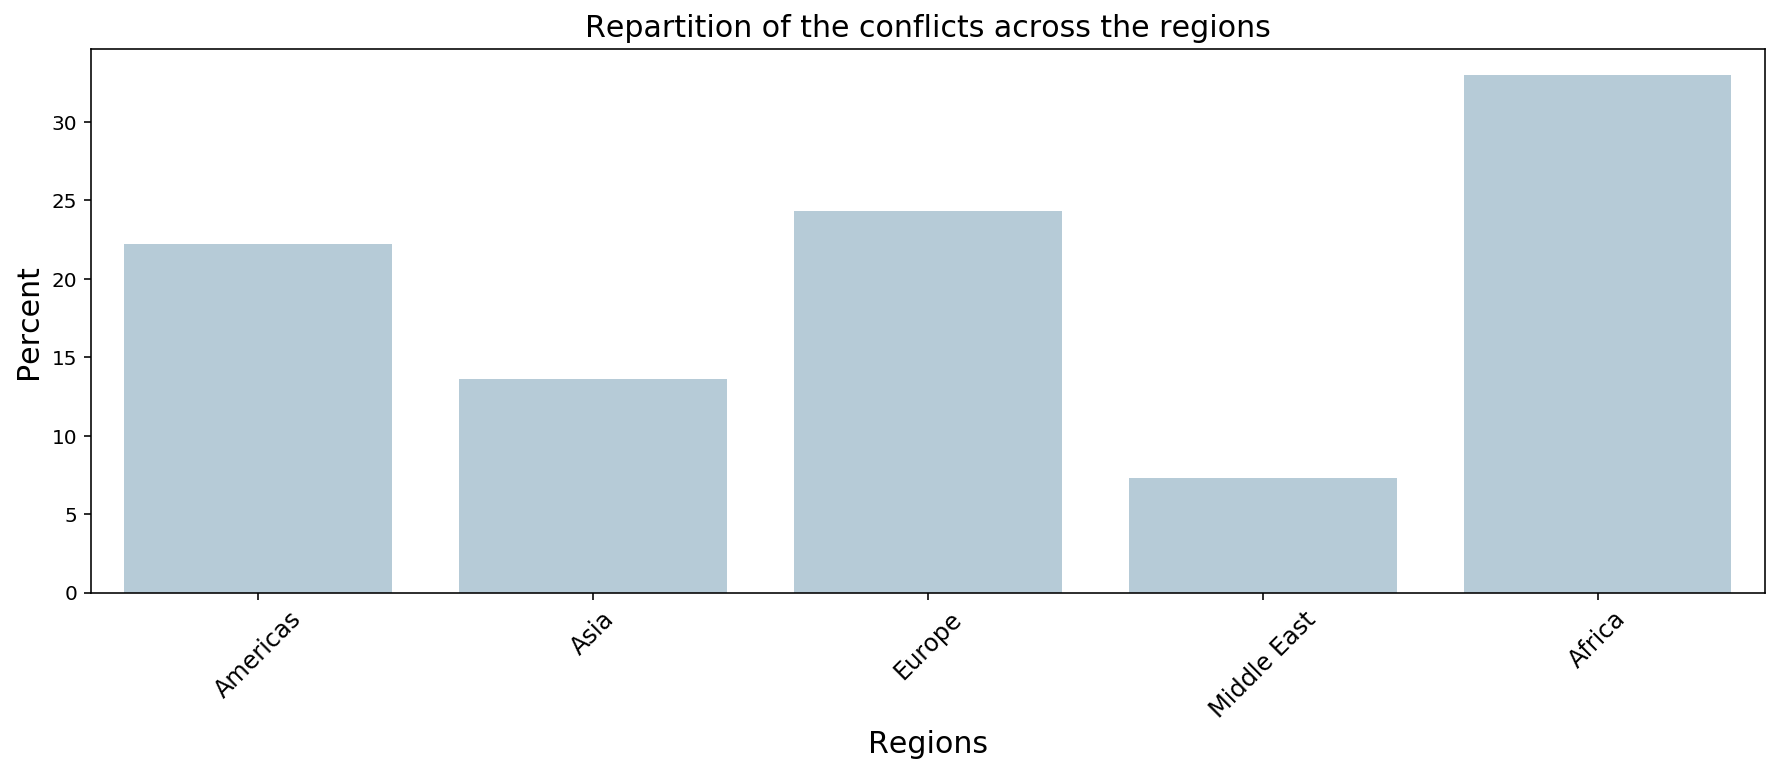

In [82]:
regper = (clean_df[clean_df['agreement'] == 1].groupby('region').count() /(clean_df[clean_df['agreement'] == 0].groupby('region').count() + clean_df[clean_df['agreement'] == 1].groupby('region').count()))['location']
plt.figure(figsize=(15,5))
sns.barplot( x = regper.index , y = (regper.values*100) , color = COLOR_TREAT )
plt.xlabel('Regions' , size = 15)
plt.ylabel('Percent' , size = 15)
plt.xticks(rotation=45 , size = 12)
plt.title('Repartition of the conflicts across the regions' , size = 15)

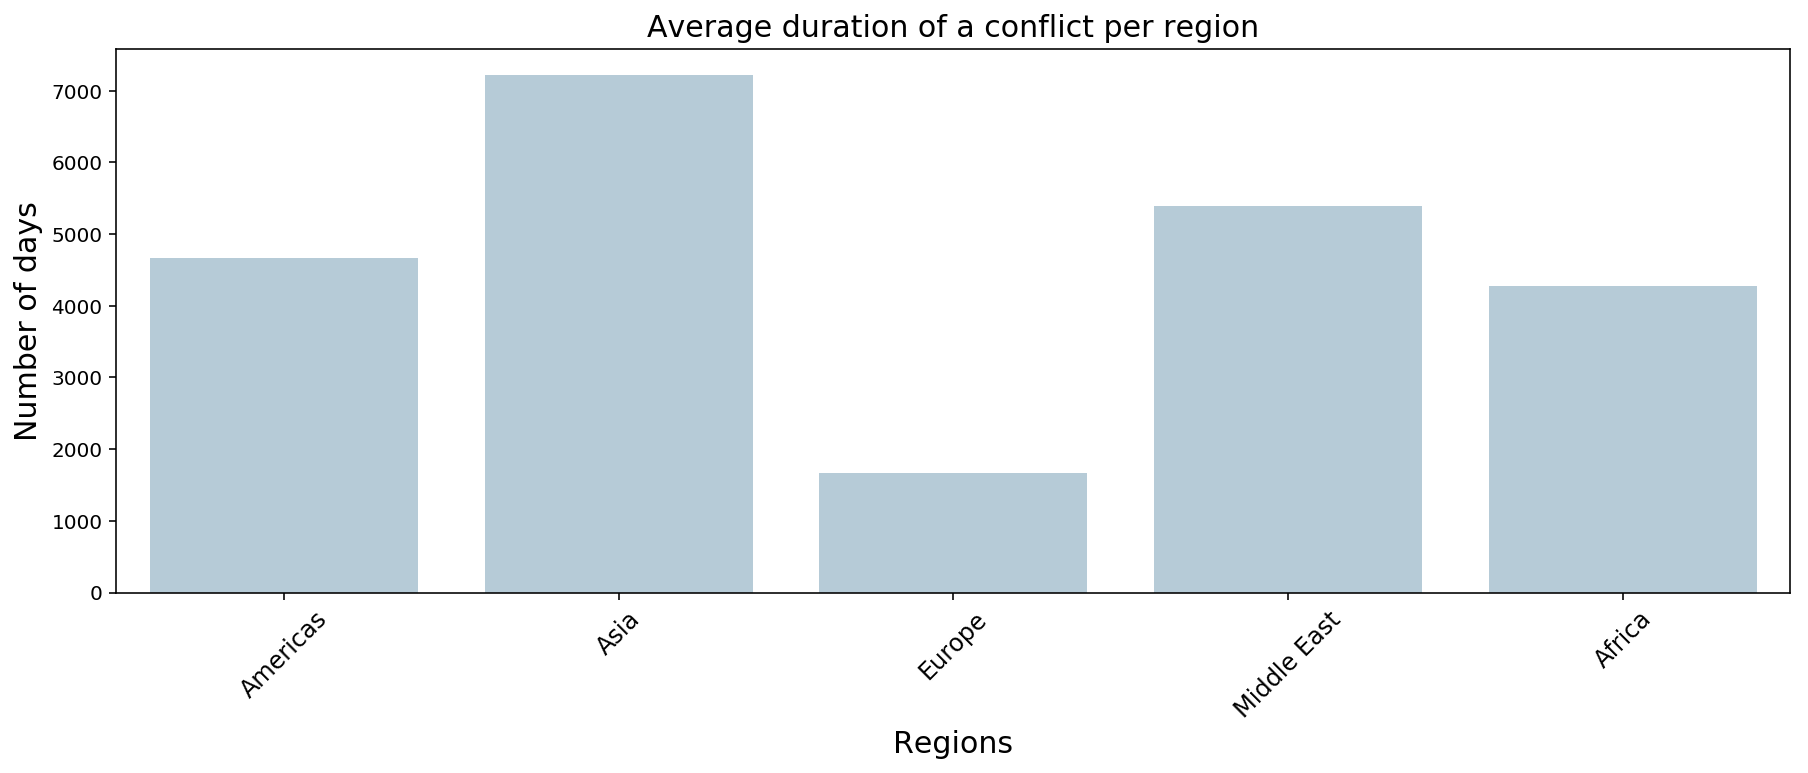

In [83]:
regionduration = clean_df.groupby('region').mean()['duration']
plt.figure(figsize=(15,5))
sns.barplot(x = regionduration.index , y = regionduration.values ,  color = COLOR_TREAT )
plt.xlabel('Regions' , size = 15)
plt.ylabel('Number of days' , size = 15)
plt.xticks(rotation=45 , size = 12)
plt.title('Average duration of a conflict per region' , size = 15)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1187106d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11c4535c0>], dtype=object)

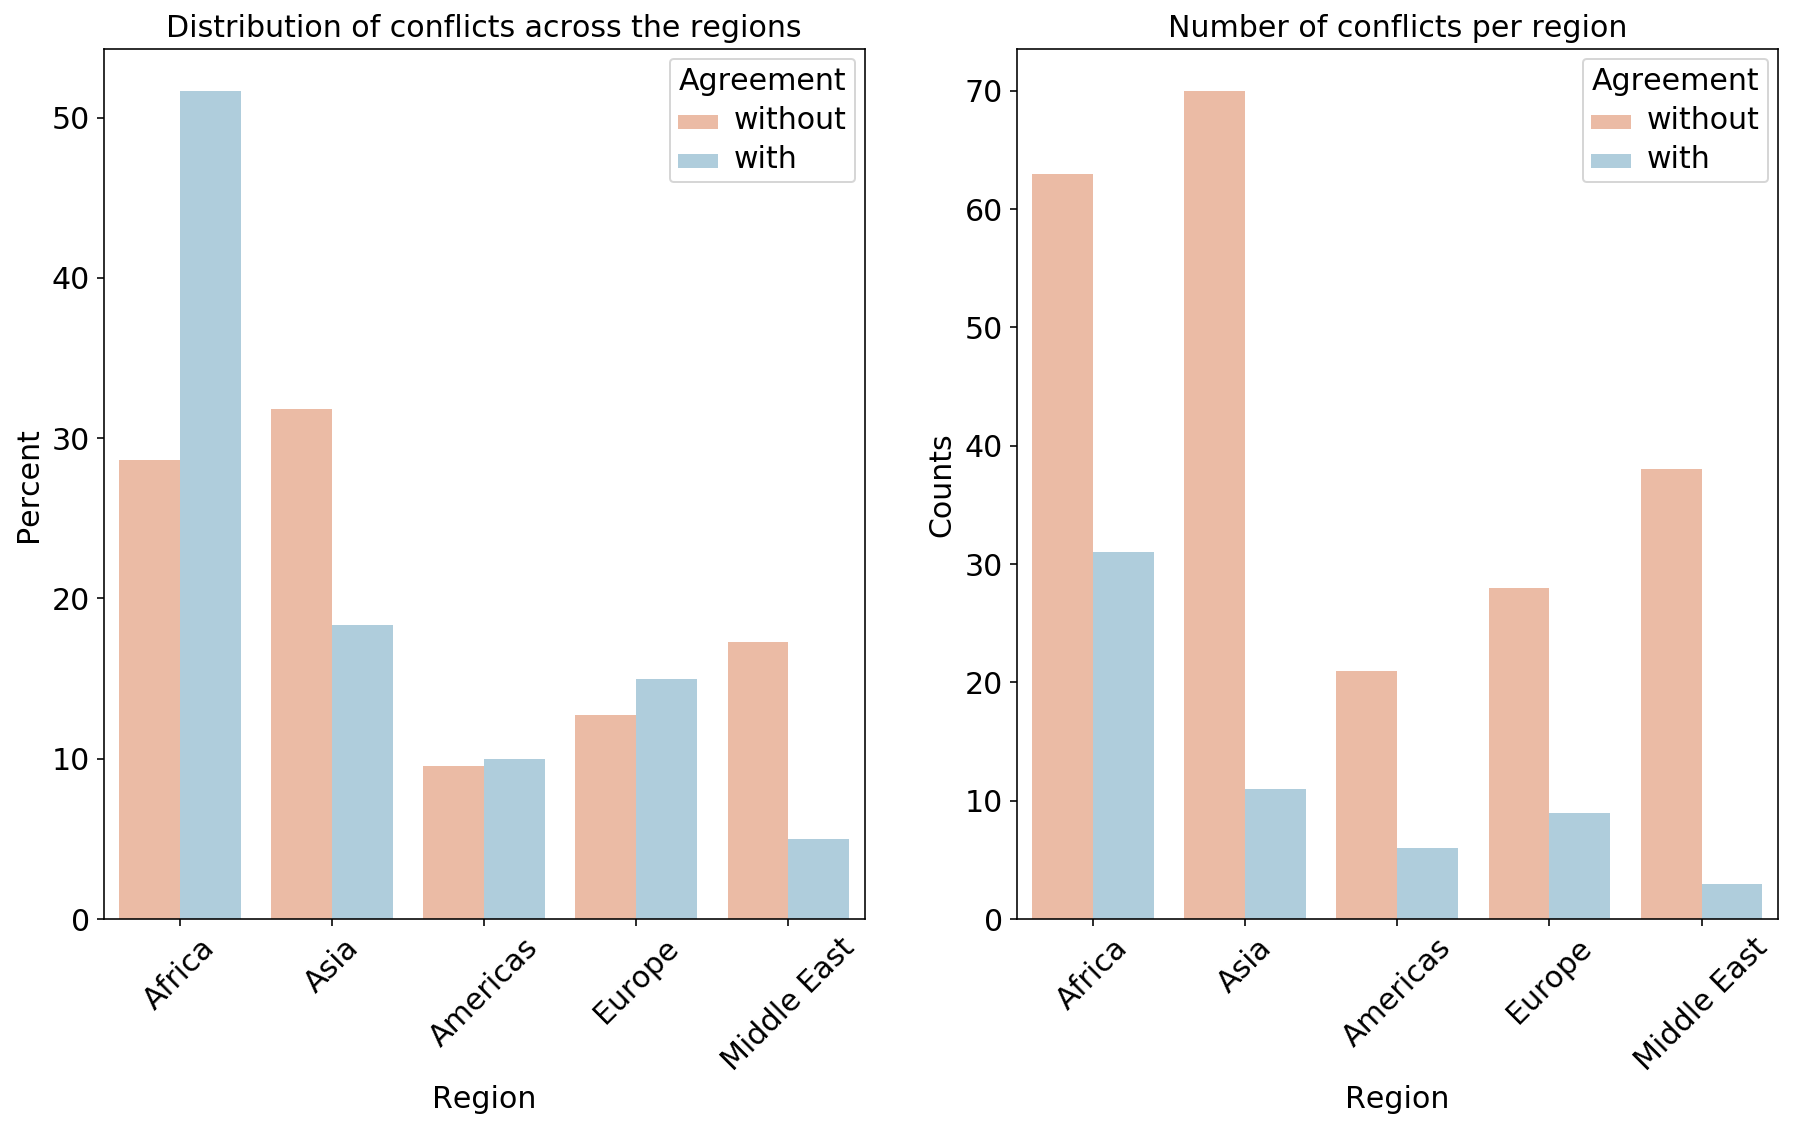

In [84]:
percent_categorical('region' , df= clean_df , grouper = 'agreement' , 
                    order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East'],
                   title = ['Distribution of conflicts across the regions' , 'Number of conflicts per region'] ,
                    label = 'Region', legend = ['Agreement' , 'without' , 'with'])

In [85]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(clean_df['region'][clean_df['agreement'] == 0], clean_df['region'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.235       0.009


### With repsect to the UN

Here we filter the conflicts in order to only vizualize those who benefited from a peace agreements.

We want to study if the distribution for the CID that benefited from a PA where the UN were involved is the same as the distribution for the CID that benefited from a PA where the UN were not involved.

Here the distributions are not the same. the distribution for the conflicts solved by the UN is more centered on Africa and Americas compared to conflicts that were solved by other entities. Note that according to our database, the UN did not take part in any peace agreement for a conflict in the Middle East.

In [86]:
#Filter on the aggreements
ag = clean_df[clean_df['agreement'] == 1]
print(ag.shape)
ag.head()

(60, 14)


,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration,Year
conflictid,,,,,,,,,,,,,,
209,Philippines,Government of Philippines,CPP,Government,More than 1000 deaths,Internal,1946-07-31,2016-08-20,Asia,1,0,1,25588.0,1946
233,Guatemala,Government of Guatemala,URNG,Government,More than 1000 deaths,Internal,1949-07-18,1995-12-31,Americas,1,1,1,16967.0,1949
234,Israel,Government of Israel,"Hamas, PIJ",Territory,More than 1000 deaths,Internal,1948-05-15,2014-12-24,Middle East,1,0,1,24329.0,1948
269,Nepal,Government of Nepal,CPN-M,Government,More than 1000 deaths,Internal,1960-02-29,2006-09-21,Asia,1,1,1,17006.0,1960
282,Sudan,Government of Sudan,SSLM,Territory,More than 1000 deaths,Internal,1963-12-31,1972-01-31,Africa,1,0,1,2953.0,1963


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1187625c0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1186969b0>], dtype=object)

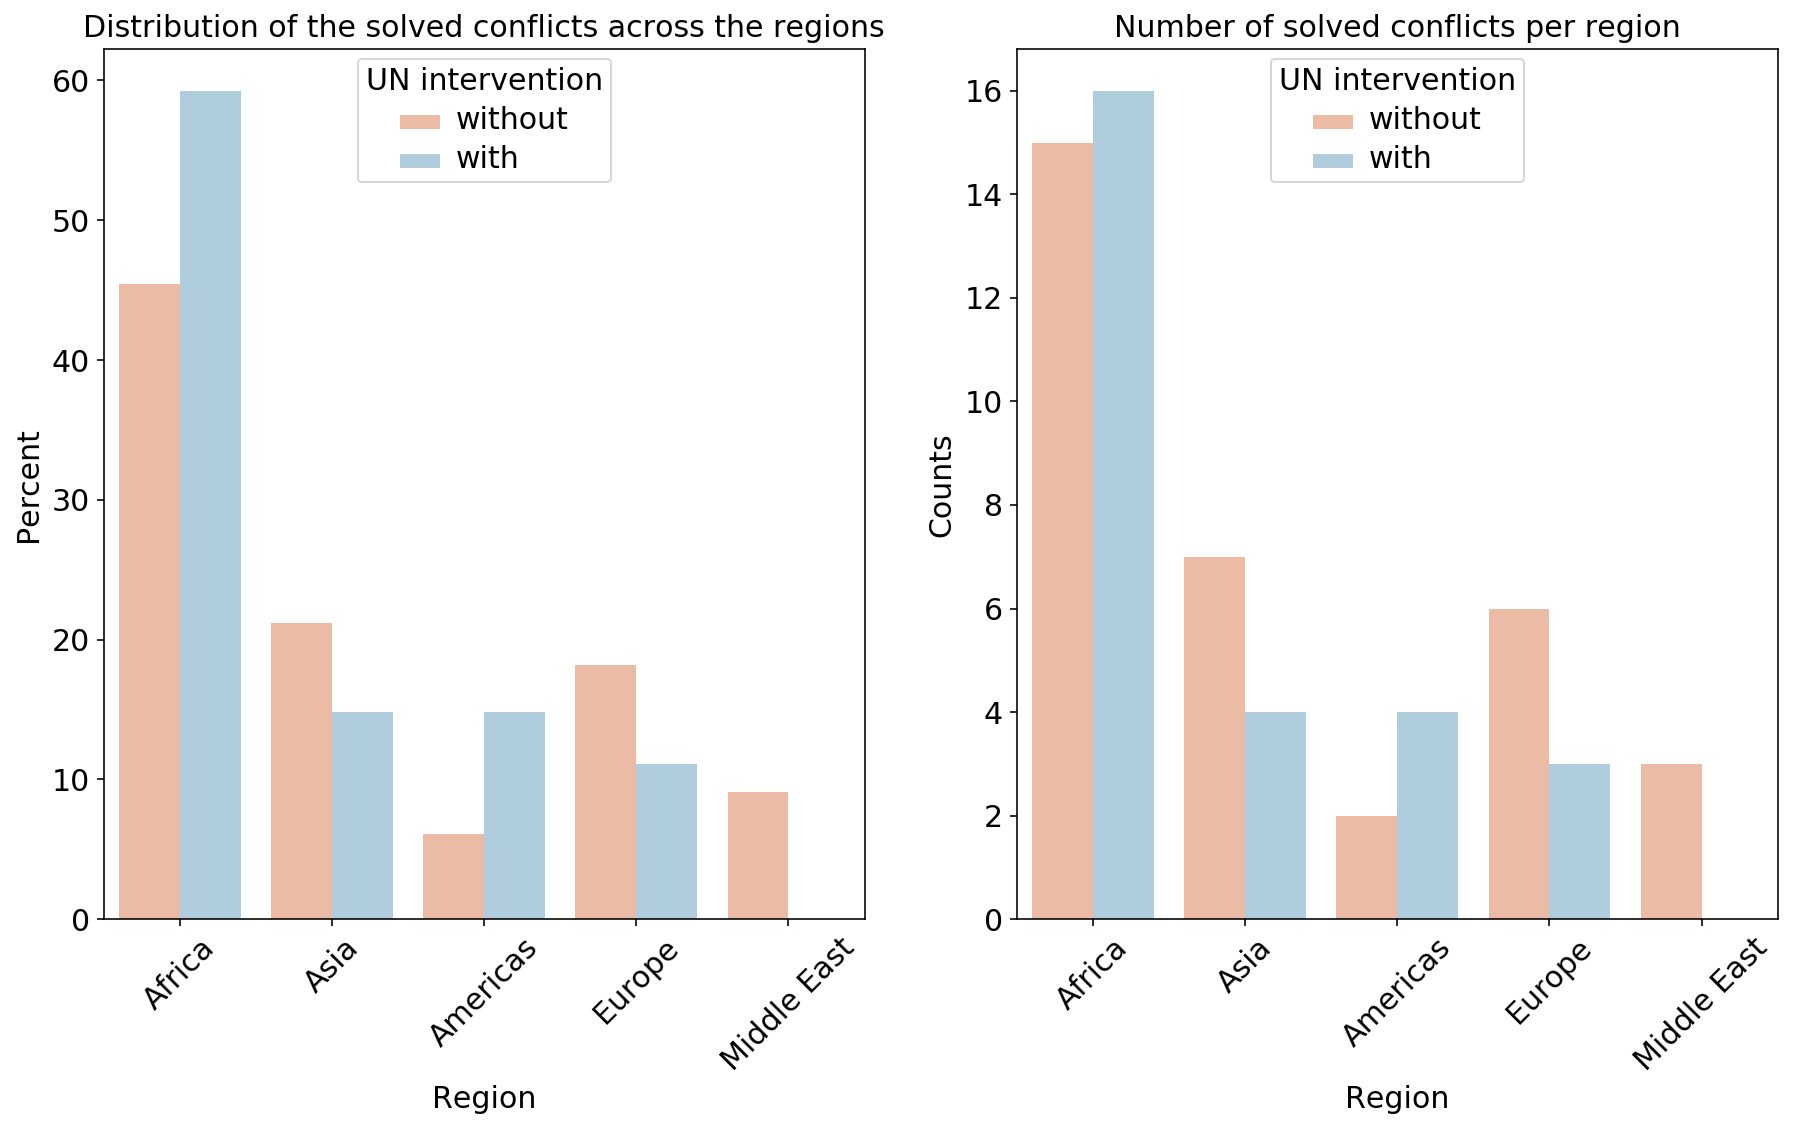

In [87]:
percent_categorical('region' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East'],
                    title = ['Distribution of the solved conflicts across the regions' , 'Number of solved conflicts per region'] 
                     , label = 'Region' , legend = ['UN intervention' , 'without' , 'with'])

In [88]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(ag['region'][ag['UN_agreement'] == 0], ag['region'][ag['UN_agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.226       0.389


## Type distribution

### With respect to the PAs

The large majority of the conflicts are internal conflicts, followed by internationalized and interstatical conflicts. Extrasystemic conflicts did not receive any peace agreements.

The distribution across the types are almost the same between the conflict that did or did not receive a peace agreement.

Here the distrib look a bit different on the plot but the p-value for the KS 2 sample test tells us that we can't reject the null hypothesis.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11867dcc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11873e278>], dtype=object)

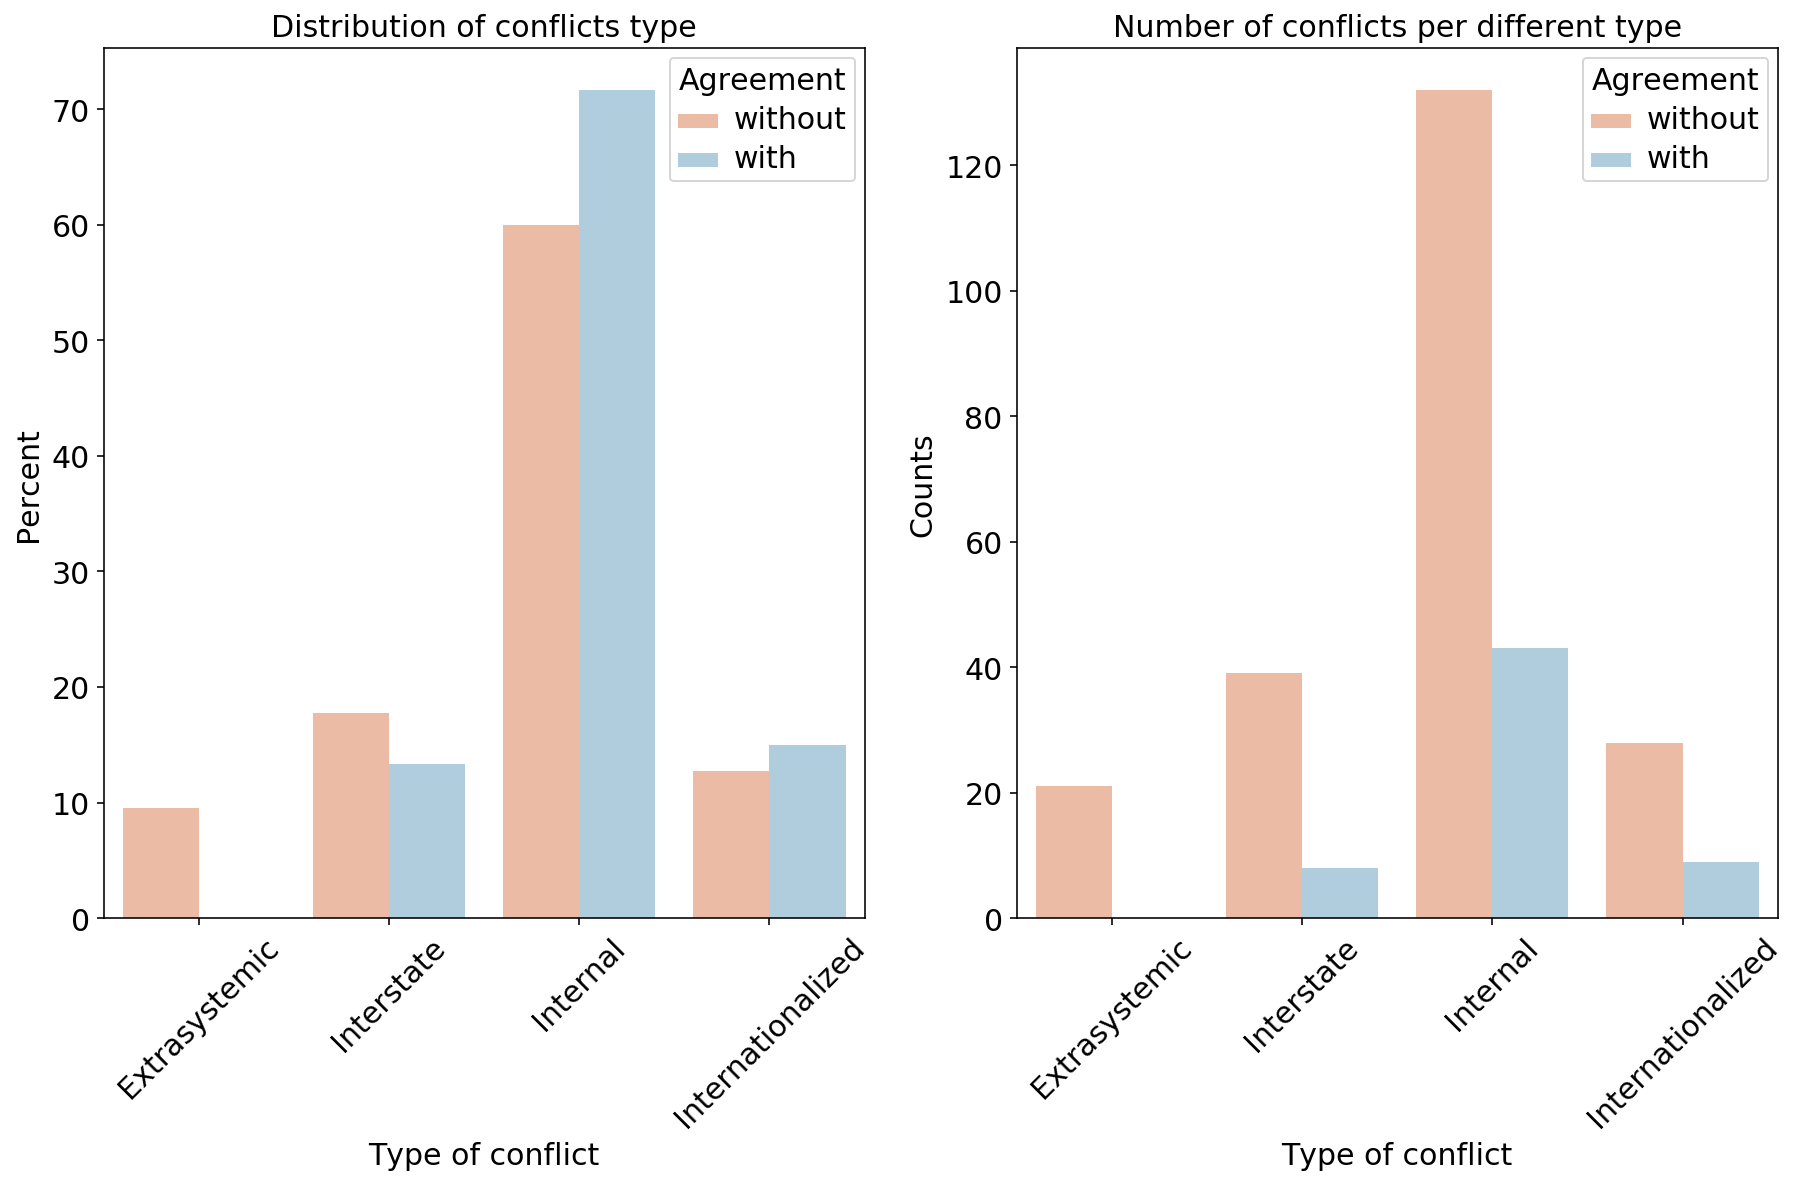

In [89]:
percent_categorical('type' , df= clean_df , grouper = 'agreement' , 
                    order = ['Extrasystemic' , 'Interstate' , 'Internal' , 'Internationalized'],
                   title = ['Distribution of conflicts type' , 'Number of conflicts per different type'],
                   label = 'Type of conflict' , 
                   legend = ['Agreement' , 'without' , 'with'])

In [90]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(clean_df['type'][clean_df['agreement'] == 0], clean_df['type'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.095       0.763


### With respect to the UN

We notice a bit of a difference between the distributions. Indeed, when we look at the conflict solved by the UN, Internationalized conflicts represents 20% of them whereas it represents less than 10% for the conflicts that received a Peace Agreement from another entity.

The UN seem to be more focused on Internationalized conflicts than Interstate conflicts compared to the control distribution.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118d14ba8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118dccac8>], dtype=object)

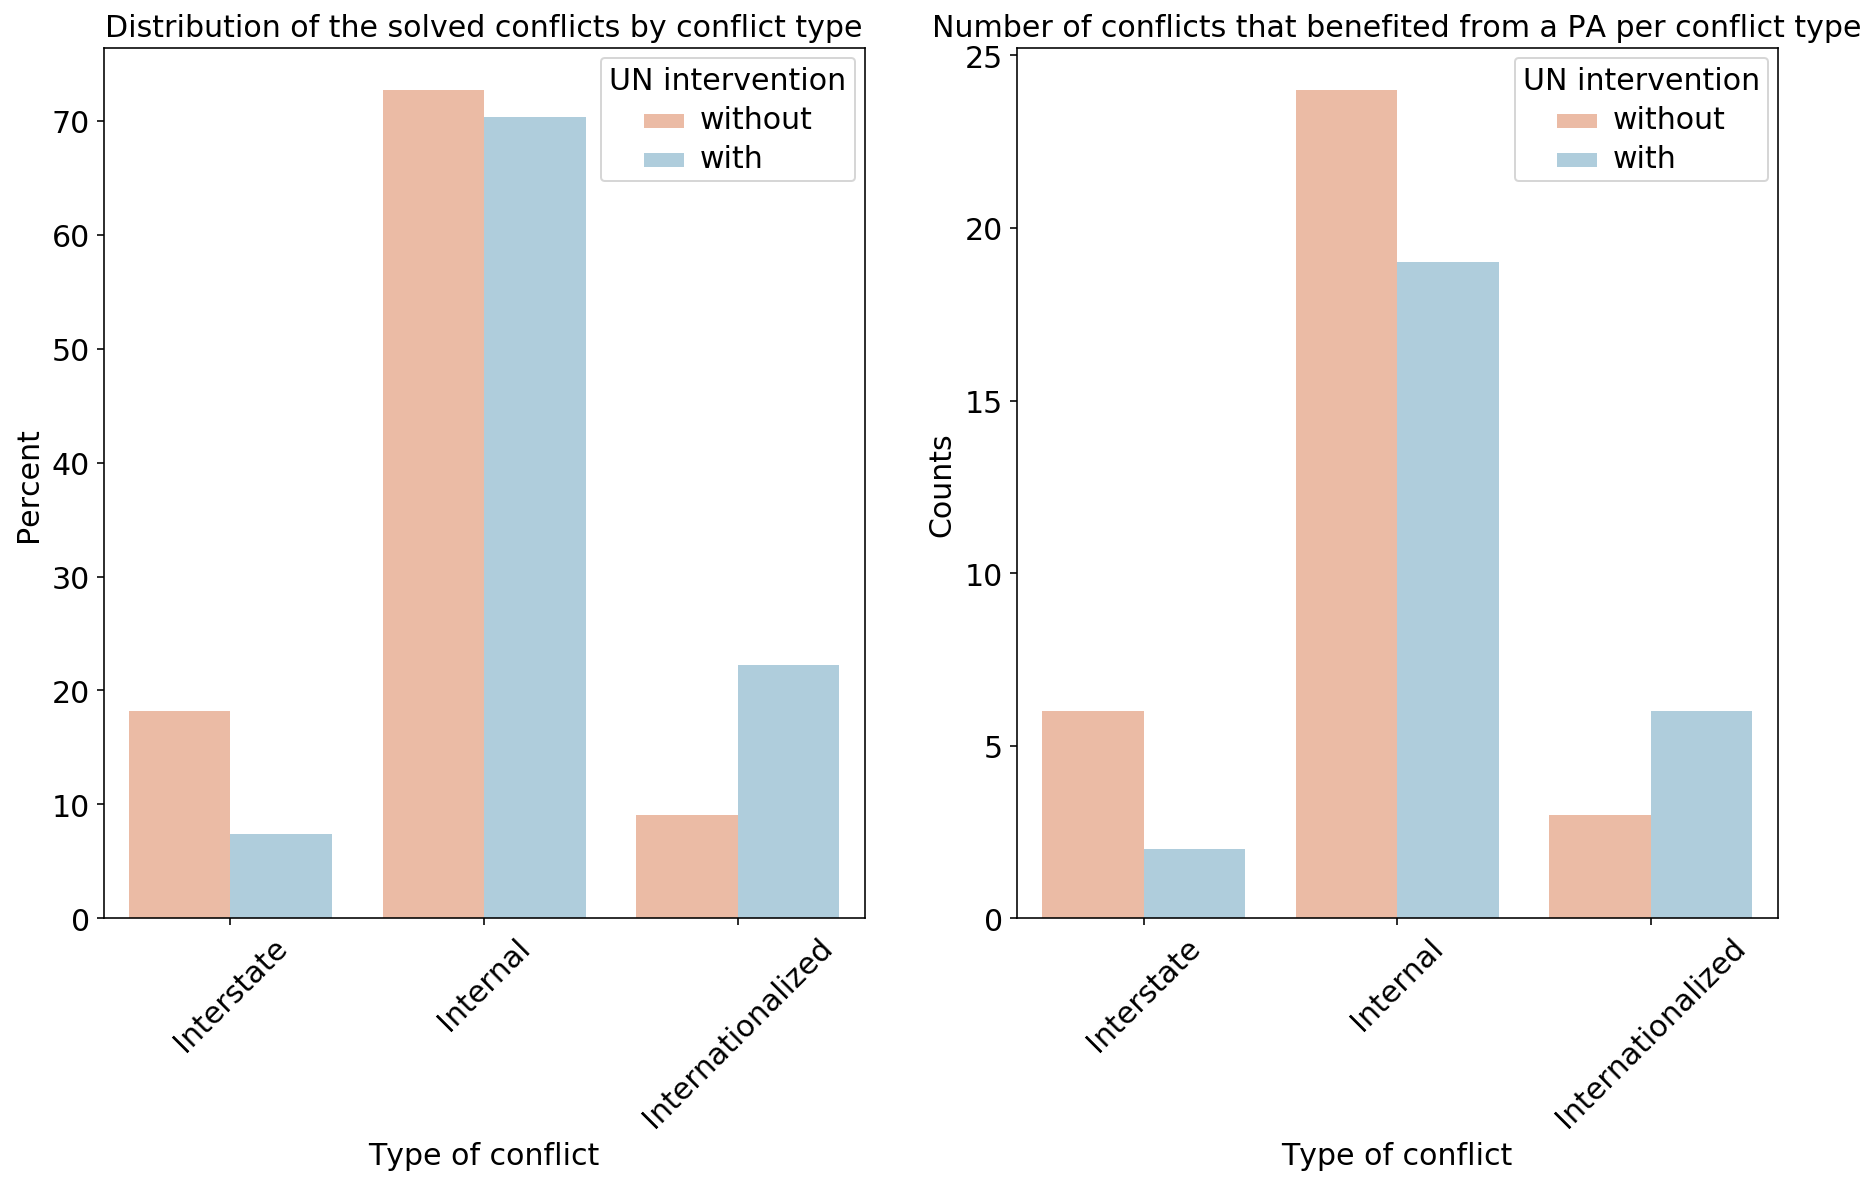

In [91]:
percent_categorical('type' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Interstate' , 'Internal' , 'Internationalized'],
                   title = ['Distribution of the solved conflicts by conflict type' , 'Number of conflicts that benefited from a PA per conflict type'],
                   label = 'Type of conflict' , 
                   legend = ['UN intervention' , 'without' , 'with'])

In [92]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(ag['type'][ag['UN_agreement'] == 0], ag['type'][ag['UN_agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.108       0.992


## `Incomp` distribution

### With respect to the agreements


There are very few conflicts that began because of both incompatibilities. The distribution of the conflicts that did not receive a peace agreement is strongly centred around territorial incompatibilities whereas the one for the conflicts that benifited from an agreement is even between Terrytory and Government incompatibilities.

P-value is higher than 0.05 so we can't reject the null for KS 2 sample

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118ea7710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118fe96a0>], dtype=object)

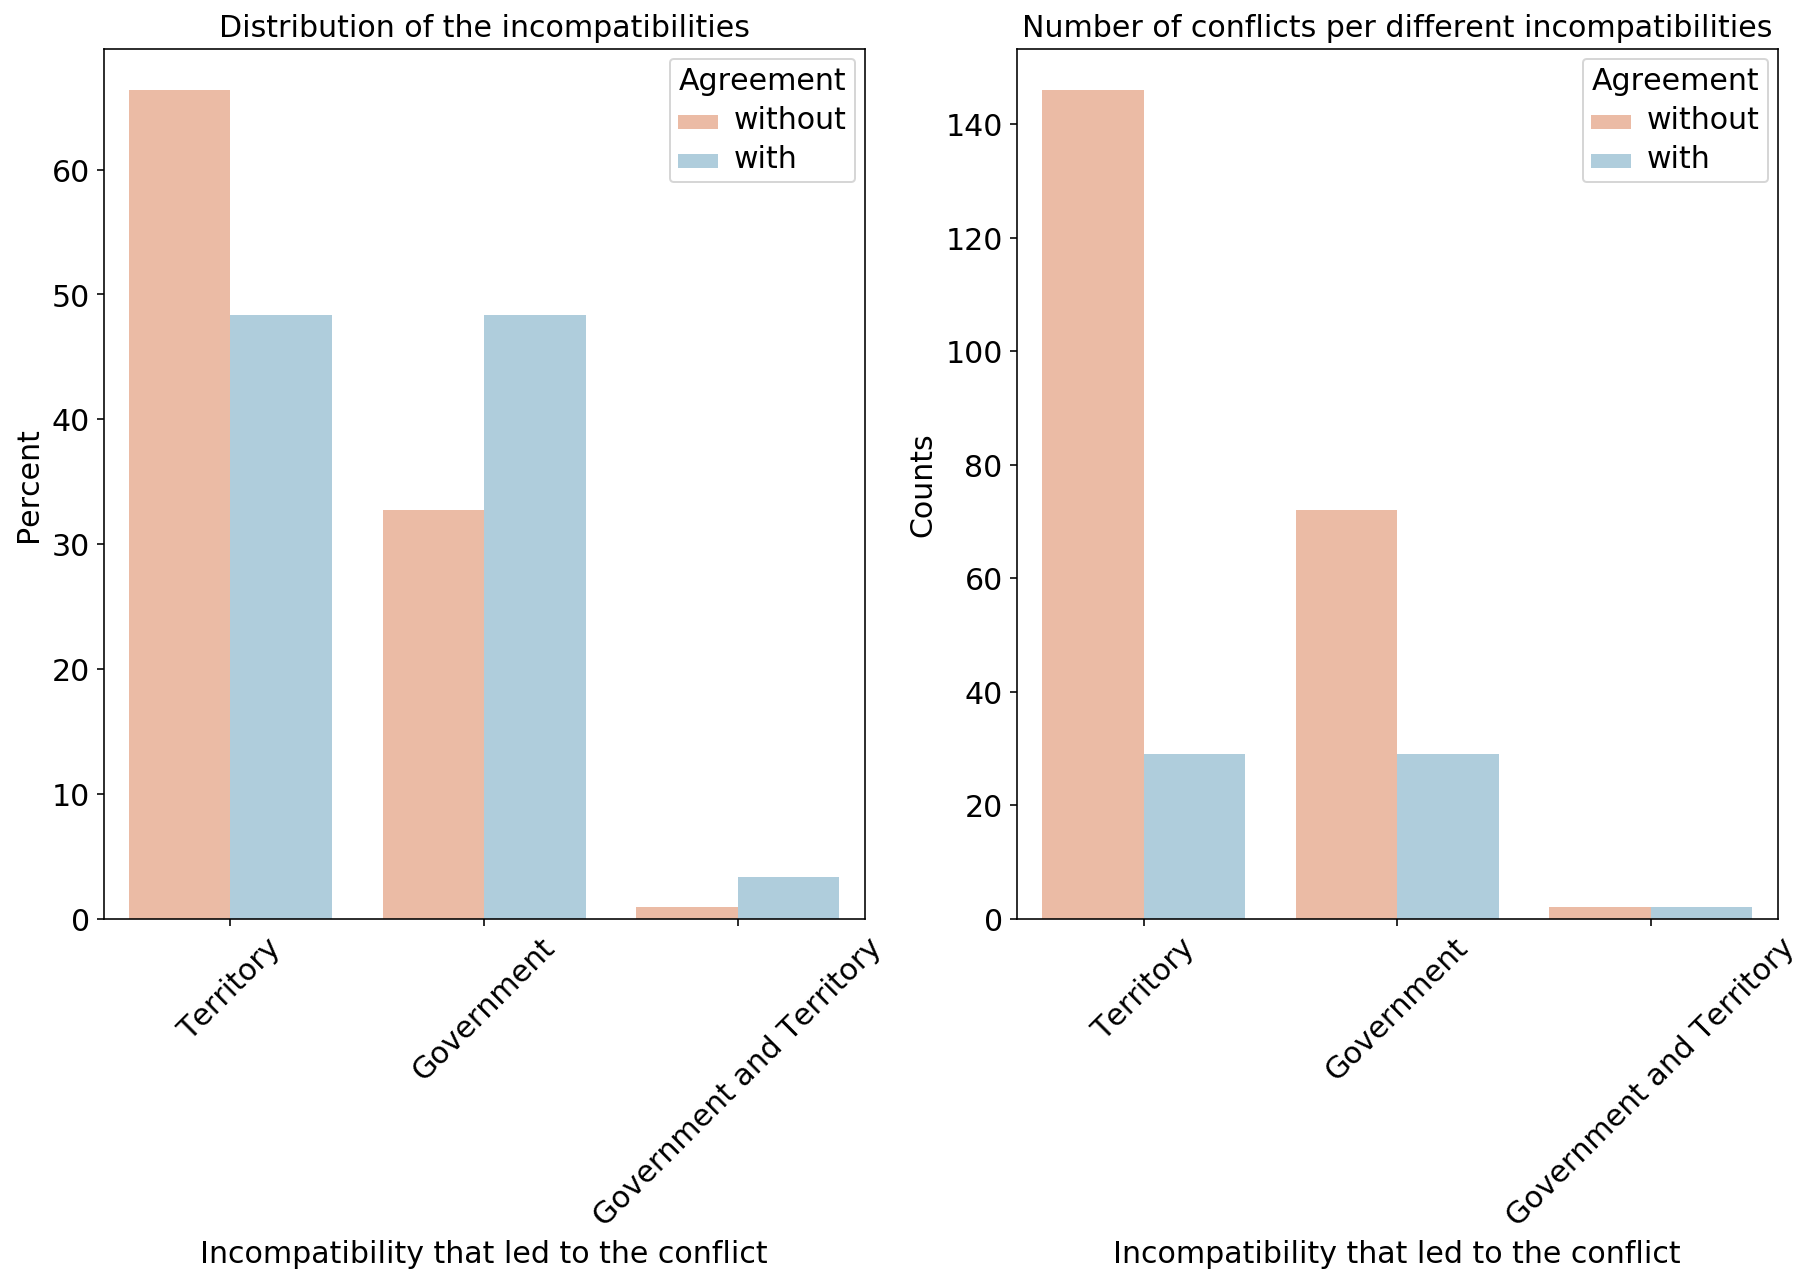

In [93]:
percent_categorical('incomp' , df= clean_df , grouper = 'agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'],
                   title = ['Distribution of the incompatibilities' , 'Number of conflicts per different incompatibilities'],
                   label = 'Incompatibility that led to the conflict' ,
                   legend = ['Agreement' , 'without' , 'with'])

In [94]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(clean_df['incomp'][clean_df['agreement'] == 0], clean_df['incomp'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.180       0.083


### With respect to the UN

These distributions are very different. Indeed, the distribution for the UN is centered around Government incomp (more than 70% of the conflicts solved by the UN) whereas the conflicts that were not solved by the UN are more centered around conflicts that began because of a Territorial incompatibility.

The p-value is very low (0.01) so we reject the null hypothesis that the two samples come from the same distribution. We will need to perform the analysis with the conflicts matched

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1190a02e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11b8a2978>], dtype=object)

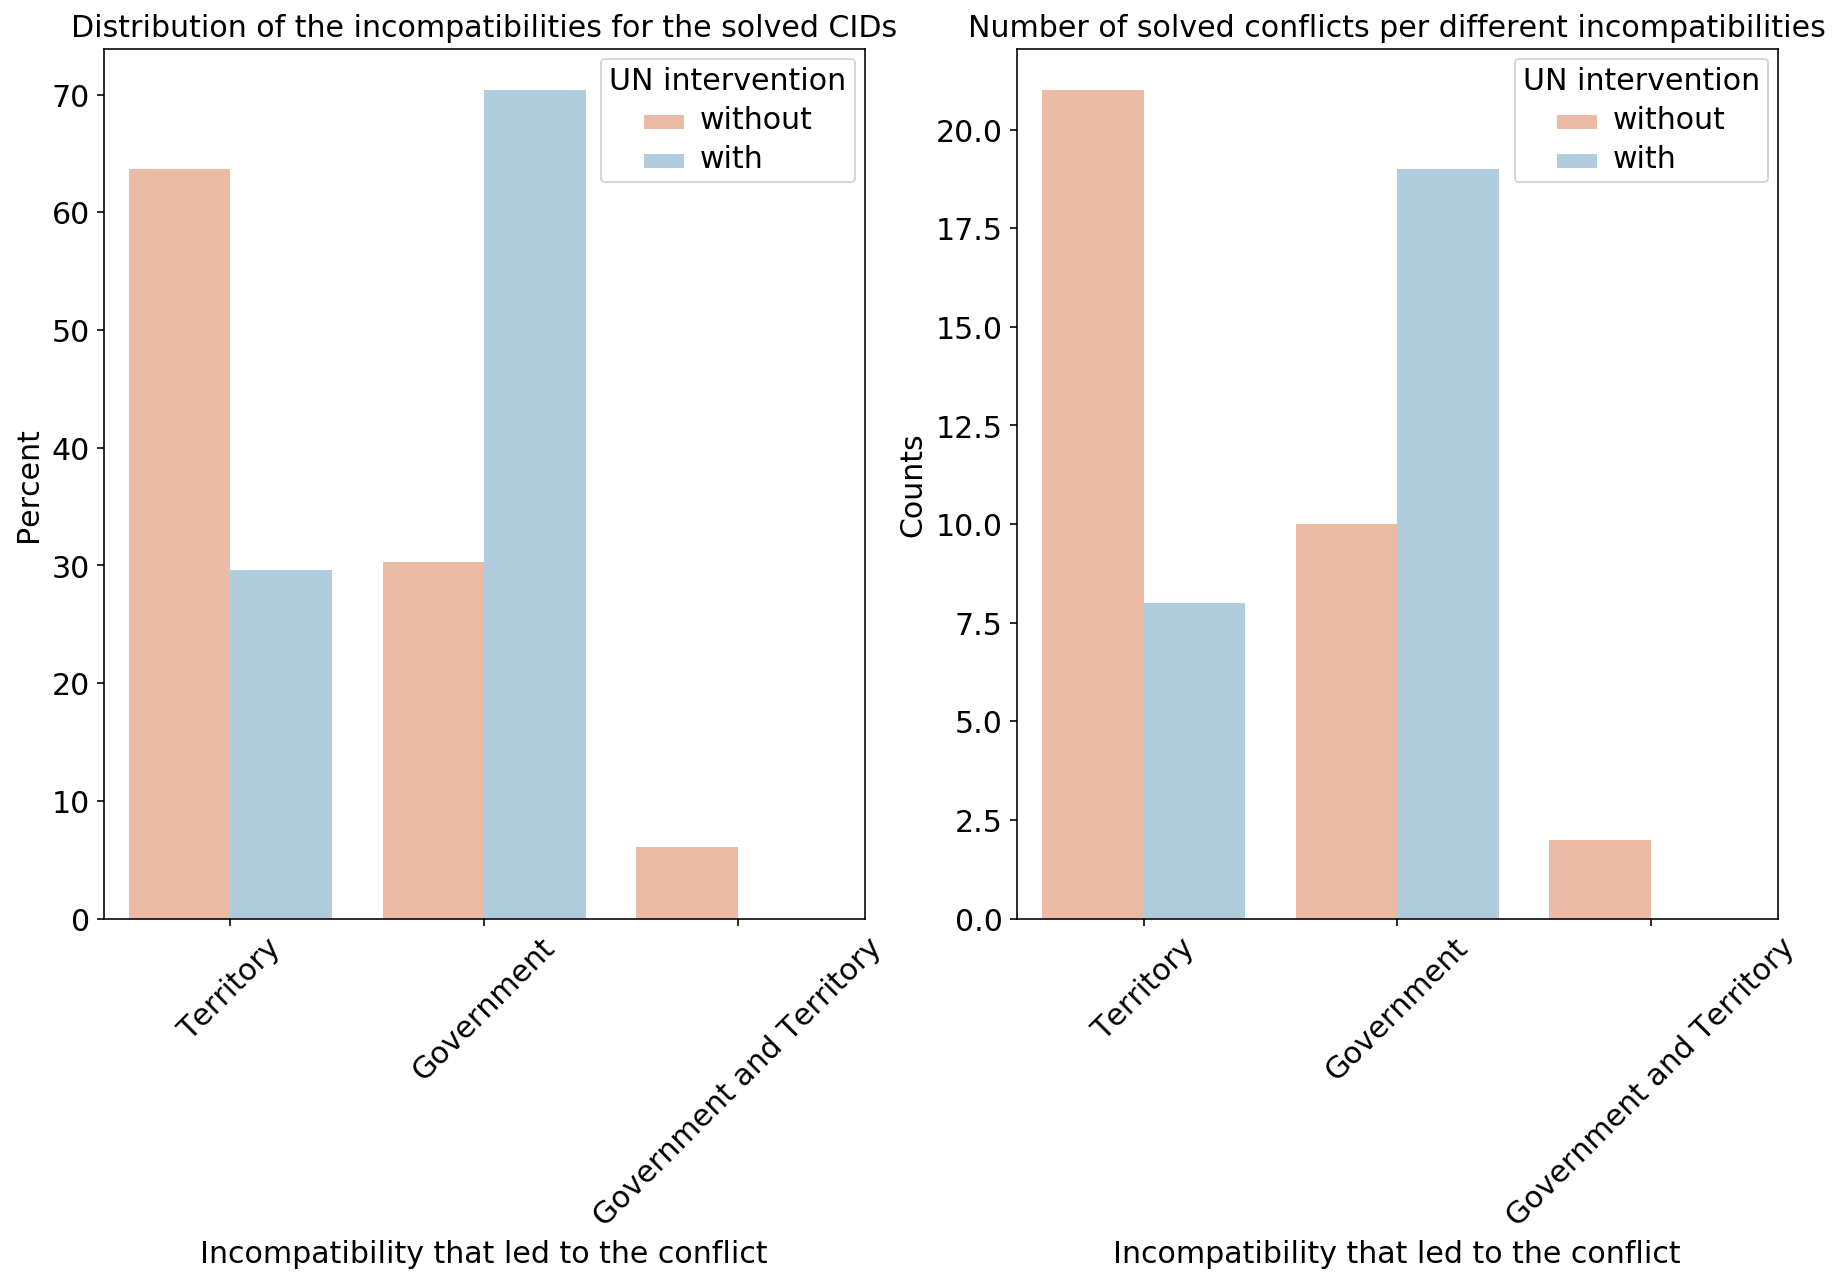

In [95]:
percent_categorical('incomp' , df= ag , grouper = 'UN_agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'],
                    title = ['Distribution of the incompatibilities for the solved CIDs' , 'Number of solved conflicts per different incompatibilities'],
                   label = 'Incompatibility that led to the conflict' , 
                   legend = ['UN intervention' , 'without' , 'with'])

In [96]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(ag['incomp'][ag['UN_agreement'] == 0], ag['incomp'][ag['UN_agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.401       0.012


## `cumint` distrib
### With respect to PA

On these distributions, we observe that peace agreements focus more on deadly conflicts than the less deadly ones. The distribution for the conflicts that did not receive a peace agreement is even between the two classes, deadly or less deadly.

p-value is high so we don't reject.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b960c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ba2f898>], dtype=object)

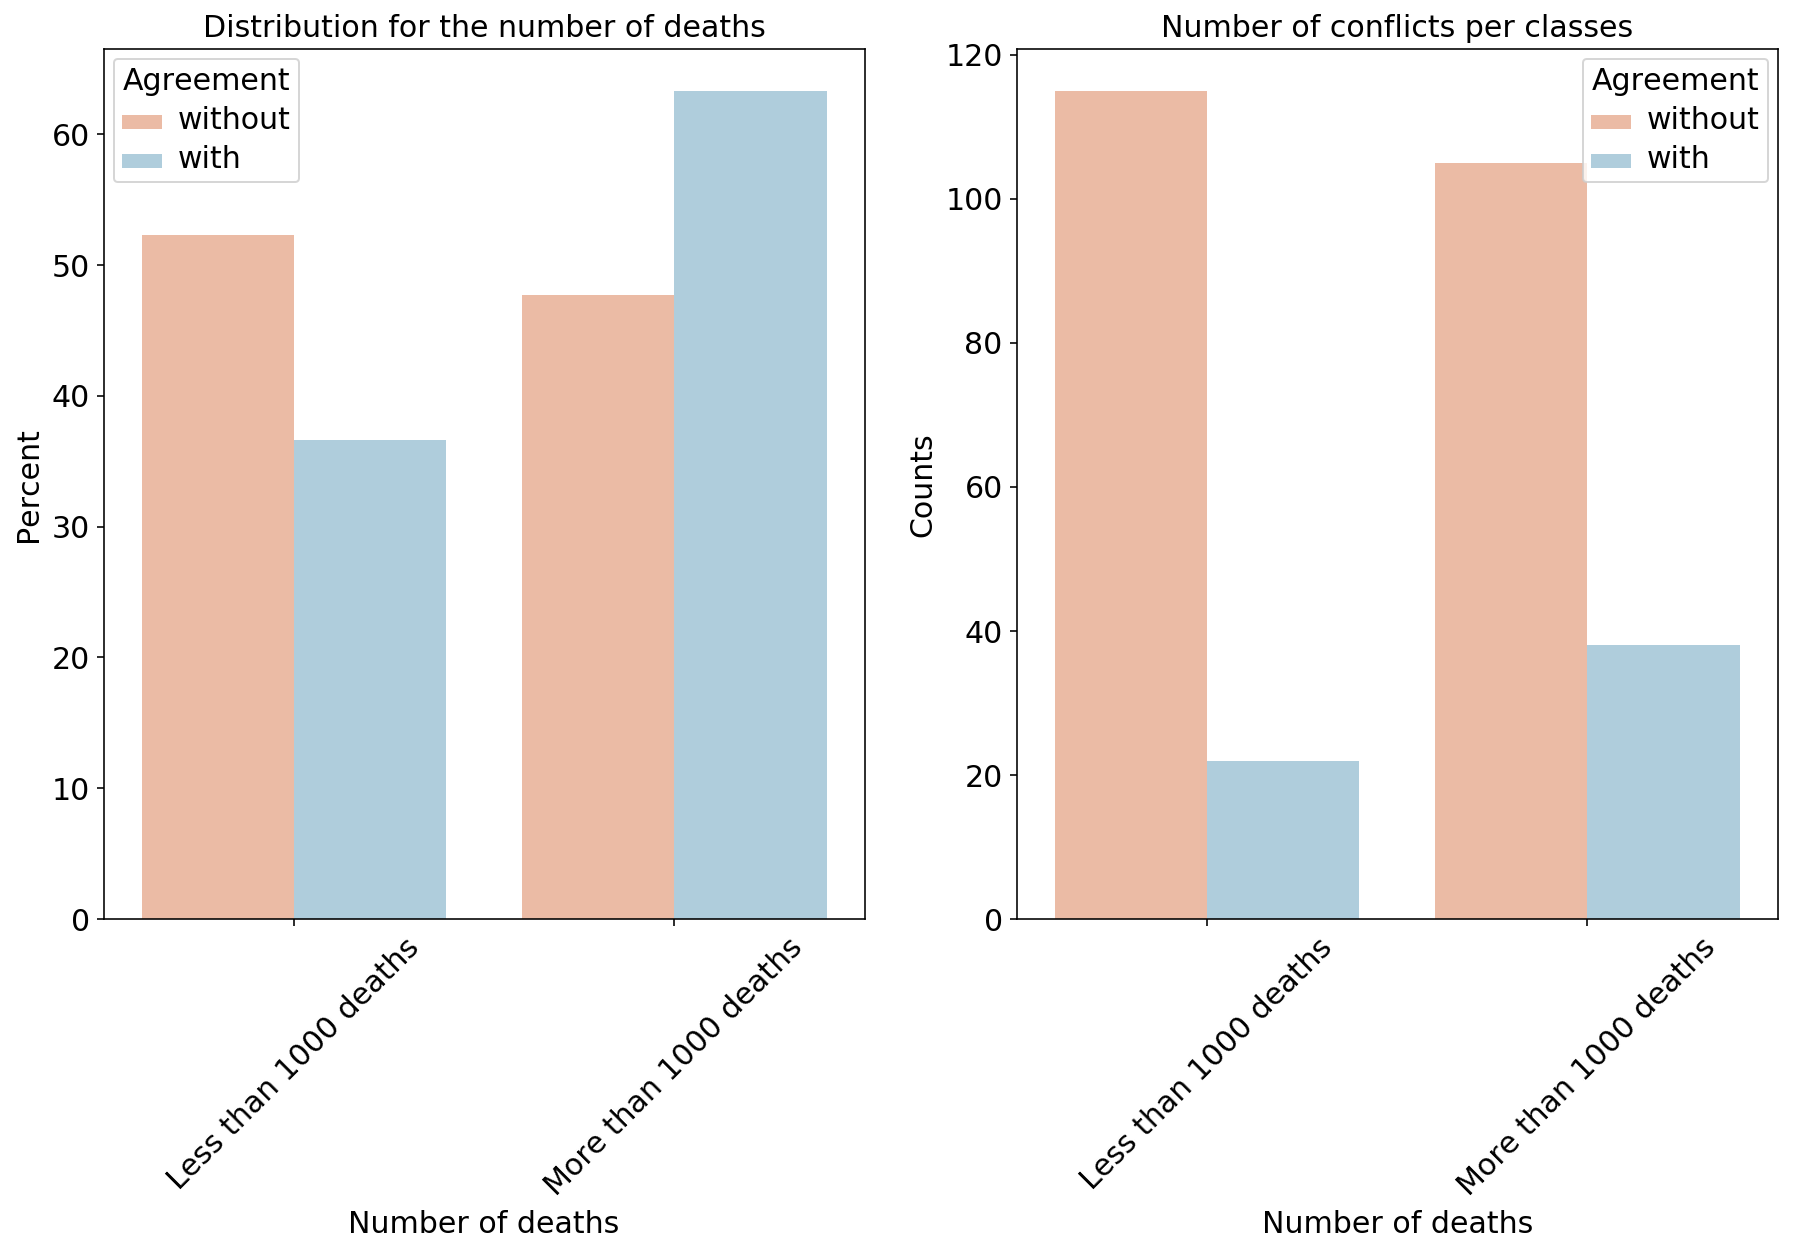

In [97]:
percent_categorical('cumint' , df= clean_df , grouper = 'agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'] ,
                   title = ['Distribution for the number of deaths' , 'Number of conflicts per classes'],
                   label = 'Number of deaths' ,
                   legend = ['Agreement' , 'without' , 'with'])

In [98]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(clean_df['cumint'][clean_df['agreement'] == 0], clean_df['cumint'][clean_df['agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.156       0.183


### With respect to the UN

Here we observe that the UN is way more focused on deadly conflicts as 80% of the conflicts solved by the UN have more than 1000 deaths. The distribution is different for the other type of peace agreements as they solve both types of conflicts equally.

After analyzing all these distribution, we observe that the UN is more involved in peace agreements for deadly, internationalized conflicts than the other solvers. These types of conflicts are known to be more difficult to solve so we will have to take this into account when we will study if the UN peace agreements are more effective than the peace agreements proposed by other actors.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bbec3c8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11bf33080>], dtype=object)

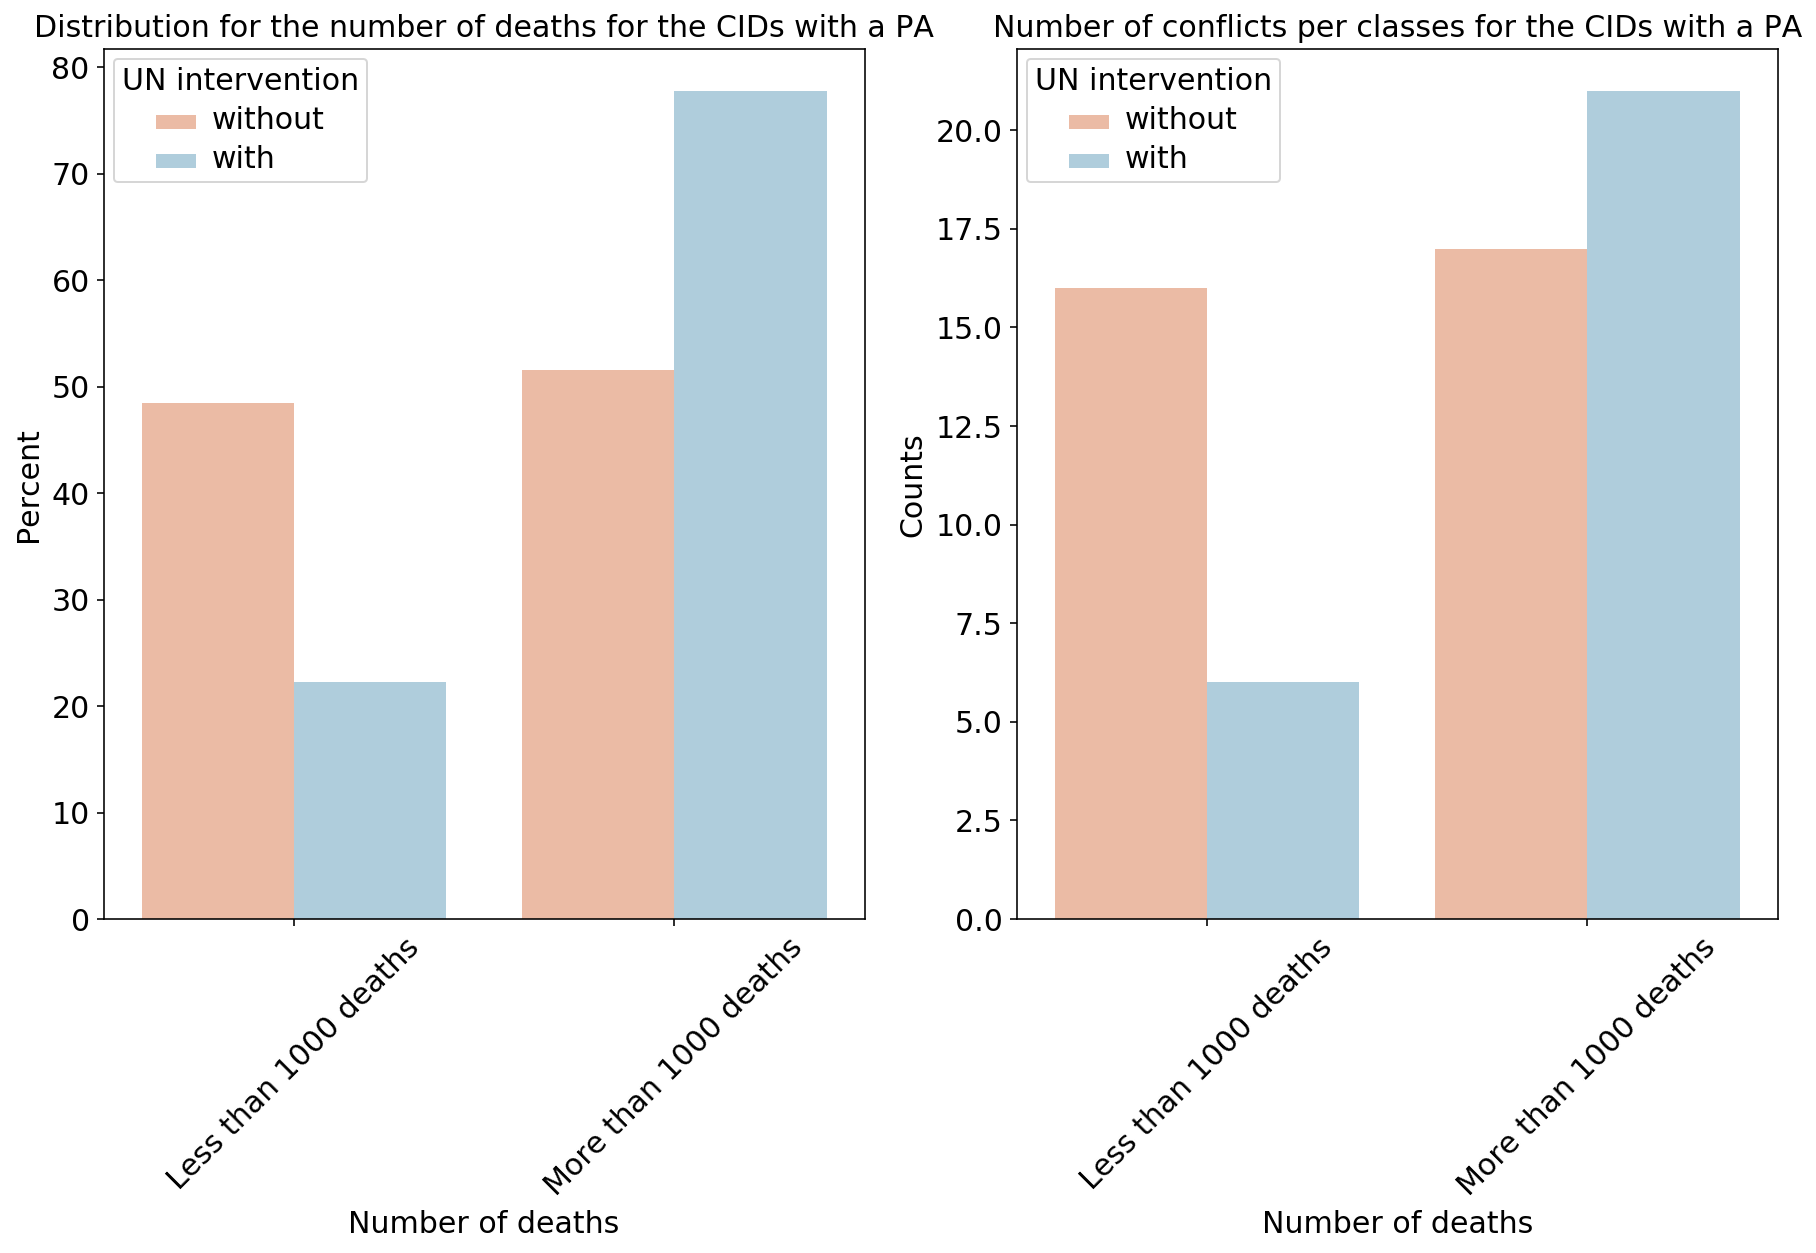

In [99]:
percent_categorical('cumint' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'],
                   title = ['Distribution for the number of deaths for the CIDs with a PA' , 'Number of conflicts per classes for the CIDs with a PA'],
                   label = 'Number of deaths' , 
                   legend = ['UN intervention' , 'without' , 'with'])

In [100]:
#KS 2 sample test to check distrib
print(('feature').ljust(10), ('statistic').ljust(10), ('p value').ljust(0), '\n') 
feature = 'duration'
ks = stats.ks_2samp(ag['cumint'][ag['UN_agreement'] == 0], ag['cumint'][ag['UN_agreement'] == 1]) 
print(feature.ljust(10), '%.3f'.ljust(10) %ks[0], '%.3f'.ljust(0) %ks[1])

feature    statistic  p value 

duration   0.263       0.219


 # Matching between conflicts (UN as treatment)

In [101]:
agreements = pa.groupby('CID').last()
print('Number of unique conflicts that had a peace agreement : %s' %(len(agreements.index)))
UN_agreements = pa[pa['UN']==1].groupby('CID').last()
Other_agreements = pa[pa['UN']==0].groupby('CID').last()
print('Number of unique conflicts that had a UN peace agreement : %s' %(len(UN_agreements.index)))
print('Number of unique conflicts that had a peace agreement that did not involve the UN: %s' %(len(Other_agreements.index)))
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df["UN_agreement"] = [1 if ele in UN_agreements.index else 0 for ele in clean_df.index]
clean_df["Other_agreement"] = [1 if ele in Other_agreements.index else 0 for ele in clean_df.index]
pa_UN_CID = pa.loc[pa['CID'].isin(clean_df[clean_df['UN_agreement'] == 1].index)]

pa_UN_CID.ended.replace(endeddic , inplace= True)

Number of unique conflicts that had a peace agreement : 60
Number of unique conflicts that had a UN peace agreement : 27
Number of unique conflicts that had a peace agreement that did not involve the UN: 50


In [102]:
pa_UN_CID.groupby(['UN' , 'ended']).count()

PAID  Region  GWNO  CID  Name  DyadName  bwdID  actorId  Inc  \
UN ended                                                                  
0  Active    40      40    40   40    40        40     40       40   40   
   Broken    29      29    29   29    29        29     29       29   29   
1  Active    45      45    45   45    45        45     45       45   45   
   Broken    23      23    23   23    23        23     23       23   23   

           pa_name   ...     txt  Link to fulltext agreement  inclusive  \
UN ended             ...                                                  
0  Active       40   ...      40                          40         40   
   Broken       29   ...      29                          29         29   
1  Active       45   ...      45                          45         45   
   Broken       23   ...      23                          23         23   

           no_dyad   pa_type  Out_iss   ProcID  Frame  All  Counter  
UN ended                                                             
0  Active        40       40        40      40     40   40       40  
   Broken        29       29        29      29     29   29       29  
1  Active        45       45        45      45     45   45       45  
   Broken        23       23        23      23     23   23       23  

[4 rows x 68 columns]

Here we notice that there is 68 and 69 conflicts in both classes, hence the matching on the peace agreements is already done when we match on the conflicts.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bfb9358>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11c213128>], dtype=object)

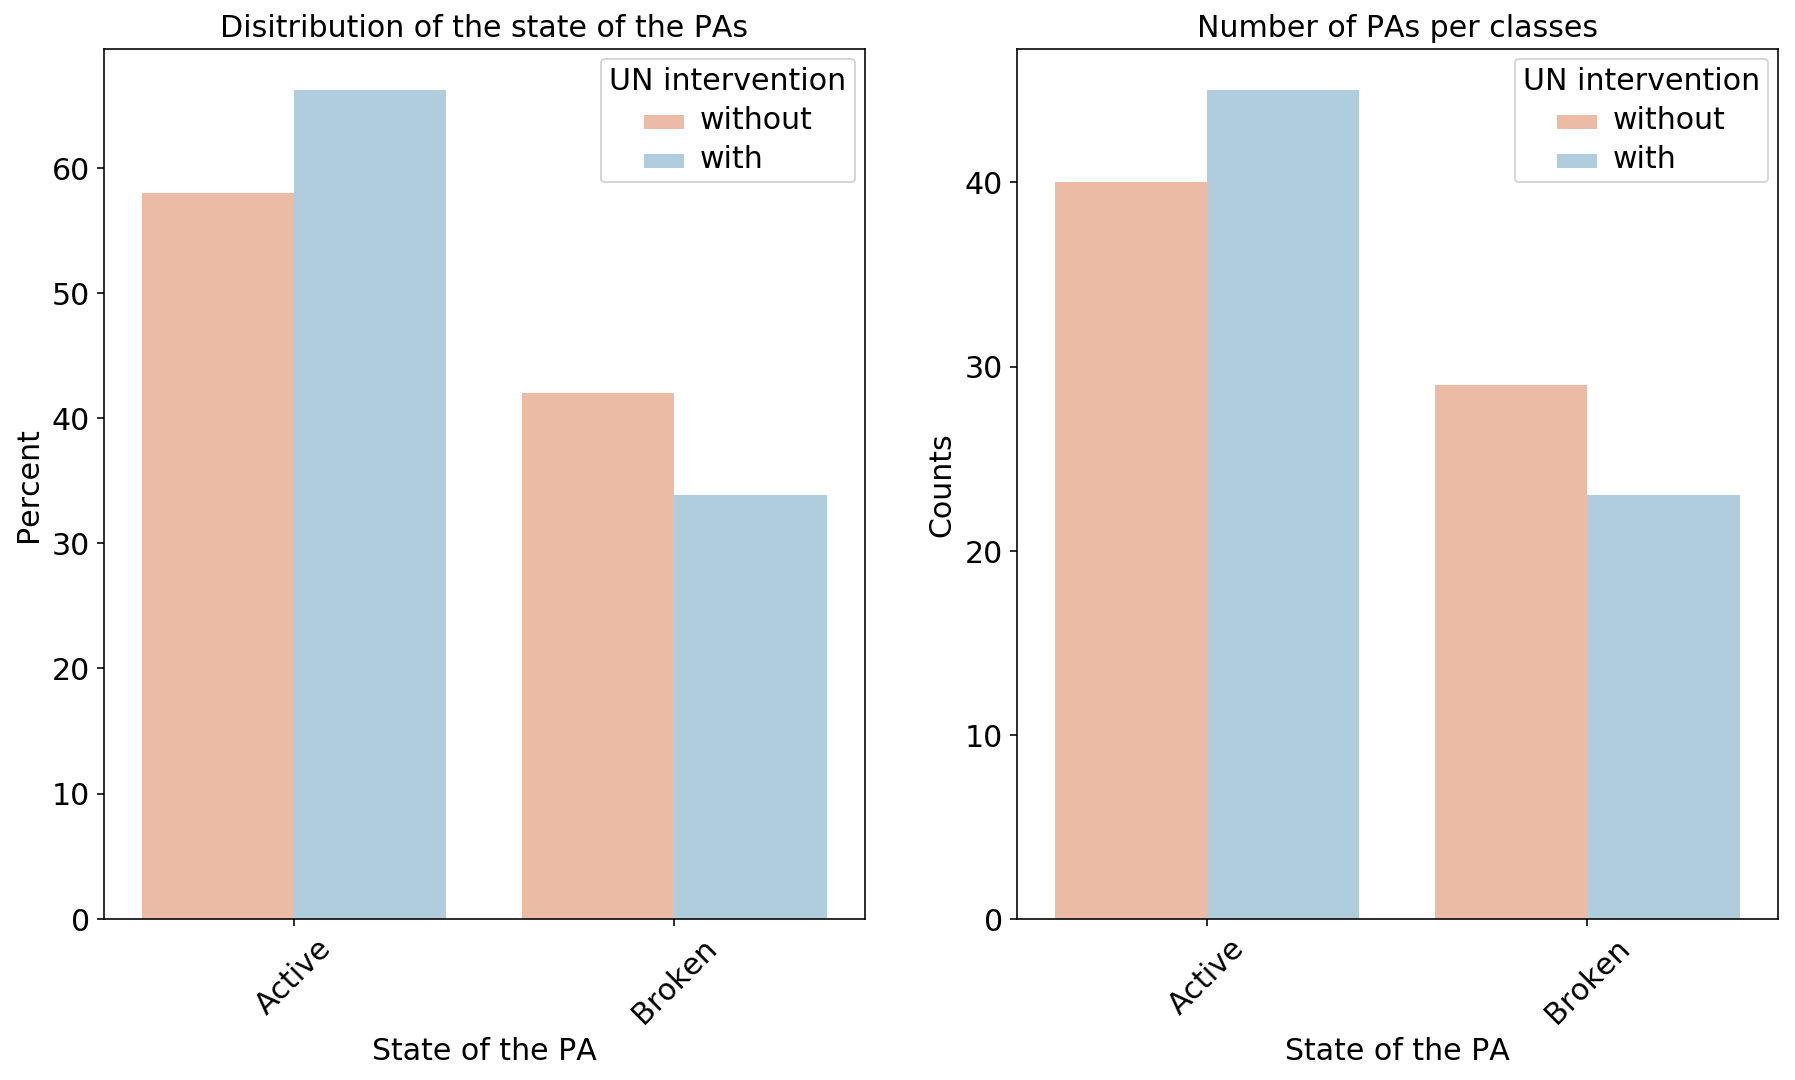

In [103]:
percent_categorical('ended', df=pa_UN_CID, grouper='UN' , 
                   order = ['Active' , 'Broken'] , title = ['Disitribution of the state of the PAs' , 'Number of PAs per classes'],
                   label = 'State of the PA',
                   legend = ['UN intervention' , 'without' , 'with'])

When matching on the conflicts as well, we observe that 42% of the conflicts solved by another 3rd party than the UN failed. This is way higher than the fail rate of the UN that is of 33%. 

When matching on the conflicts, we observe that the UN peace agreements are way more stable than the ones performed by other 3rd parties. Indeed, we observed in the previous parts that the UN was taking care of a larger part of deadly governmental conflicts compared to the other 3rd parties.
A naive analysis first showed us that the UN was performing as good as other 3rd parties if not worst, but when pushing this observational study further we showed that it is bringing more stability when it is involved in the resolution of a conflict.

In [104]:
oddsratio, pvalue = stats.fisher_exact([[40, 45], [29, 23]])
pvalue

0.37986615452014483

However, the p-value is a bit high so we cannot reject the null hypothesis that the treatments do not affect outcomes. This mean that we can't say for sure that the UN agreements are really less likely to be terminated or not.

## Map data cleaning
The goal here is to clean the geographical data columns so that the countries' names match with the names in the geojson file.

You can see the 3d code for the map in the /frontend/map directory.

In [105]:
data = json.load(open('./data/countries.geo.json'))
map_countries = set([country['properties']['name'] for country in data['features']])

In [106]:
# takes a string as input and returns the cleaned string
def clean_location(location):
    location = re.sub(r'\([^)]*\)', '', location)
    location = re.sub(', ', ',', location)
    location = re.sub(' ,', ',', location)
    return location.strip()

In [107]:
clean_df.location = clean_df.location.apply(clean_location)

In [108]:
# let's check how many countries from the data still have no matcing on the map
def print_unmatched(map_countries):
    data_countries = set(clean_df.location.values)
    no_match = []
    for entry in data_countries:
        # some entries have several countries separated by a ','
        for country in entry.split(','):
            if country not in map_countries:
                no_match.append(country)
    print("There are " + str(len(set(no_match))) + " locations that are not on the map:")
    print(set(no_match))
print_unmatched(map_countries)

There are 13 locations that are not on the map:
{'Guinea-Bissau', 'DR Congo', 'Rumania', 'South Vietnam', 'Grenada', 'South Yemen', 'Tanzania', 'FYR', 'Comoros', 'Hyderabad', 'Bosnia-Herzegovina', 'Congo', 'Serbia'}


Let's do some manual corrections for the few locations that are still unmatched:

In [109]:
manual_matchings = {
    'Bosnia-Herzegovina' : 'Bosnia and Herzegovina',
    'Tanzania' : 'United Republic of Tanzania',
    'Comoros' : 'Madagascar',
    'South Yemen' : 'Yemen',
    'DR Congo' : 'Democratic Republic of the Congo',
    'Hyderabad' : 'India',
    'South Vietnam' : 'Vietnam',
    'FYR' : 'Macedonia',
    'Grenada' : 'Spain',
    'Rumania' : 'Romania',
    'Serbia' : 'Republic of Serbia',
    'Congo' : 'Republic of the Congo',
    'Guinea-Bissau' : 'Guinea Bissau',
}
def replace_names(location):
    names = list(set([manual_matchings[x] if x in manual_matchings else x for x in location.split(',')]))
    return ','.join(names)
clean_df.location = clean_df.location.apply(replace_names)

In [110]:
print_unmatched(map_countries)

There are 0 locations that are not on the map:
set()


### Add the locations' IDs from the GeoJson to the dataframe
The GeoJSON contains for each location a unique ID. We add these locations to the dataframe to use them as unique identifiers in the front-end.

In [111]:
# build location -> locID dictionnary
loc_id_dict = dict()
for country in data['features']:
    loc_id_dict[country['properties']['name']] = country['id']
    if country['id'] == '-99':
        print(country['properties']['name'])
        
def getLocationIds(locations):
    ids = []
    for loc in locations.split(','):
        ids.append(loc_id_dict[loc])
    return ','.join(ids)
        
# Add locationID to the dataframe
clean_df['locationID'] = clean_df.location.apply(getLocationIds)
clean_df.head(30)

Northern Cyprus
Somaliland


,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration,Year,locationID
conflictid,,,,,,,,,,,,,,,
200,Bolivia,Government of Bolivia,ELN,Government,More than 1000 deaths,Internal,1946-07-18,1967-10-16,Americas,0,0,0,7760.0,1946,BOL
201,Cambodia,Government of France,Khmer Issarak,Territory,Less than 1000 deaths,Extrasystemic,1946-08-31,1953-11-09,Asia,0,0,0,2627.0,1946,KHM
202,China,Government of China,PLA,Government,More than 1000 deaths,Internal,1946-12-31,1949-12-08,Asia,0,0,0,1073.0,1946,CHN
203,Greece,Government of Greece,DSE,Government,More than 1000 deaths,Internal,1946-03-31,1949-10-16,Europe,0,0,0,1295.0,1946,GRC
204,Indonesia,Government of Netherlands,Indonesian People's Army,Territory,Less than 1000 deaths,Extrasystemic,1945-10-13,1949-08-15,Asia,0,0,0,1402.0,1945,IDN
205,Iran,Government of Iran,KDPI,Territory,More than 1000 deaths,Internal,1946-05-31,1996-07-28,Middle East,0,0,0,18321.0,1946,IRN
206,Iran,Government of Iran,Republic of Azerbaijan,Territory,Less than 1000 deaths,Internationalized,1945-11-19,1946-12-16,Middle East,0,0,0,392.0,1945,IRN
207,Israel,Government of United Kingdom,IZL [Etzel],Territory,Less than 1000 deaths,Extrasystemic,1939-03-31,1946-12-31,Middle East,0,0,0,2832.0,1939,ISR
208,Laos,Government of France,Lao Issara,Territory,More than 1000 deaths,Extrasystemic,1946-03-31,1953-12-31,Asia,0,0,0,2832.0,1946,LAO


In [112]:
#Add location IDs to the dataframe
#clean_df.head()
#clean_df['locationID'] = clean_df.location.map(loc_id_dict)
print(clean_df.location.unique().size)
print(clean_df['locationID'].unique().size)
#clean_df.head()

150
150
